# Settings

In [1]:
%env TF_KERAS = 1
import os
sep_local = os.path.sep

import sys
sys.path.append('..'+sep_local+'..')
print(sep_local)

env: TF_KERAS=1
\


In [2]:
import tensorflow as tf
print(tf.__version__)

2.1.0


In [3]:
os.chdir('..'+sep_local+'..'+sep_local+'..')
print(os.getcwd())

C:\Users\Khalid\Documents\projects\GM\Generative_Models


# Dataset loading

In [4]:
dataset_name='pokemon'

In [5]:
IMG_DIR = 'C:\\Users\\Khalid\\Documents\projects\\pokemon\DS06\\'
VAL_PCT = 20
VAL_FORMAT = 'png'

In [6]:
from training.generators.file_image_generator import create_image_lists, get_generators

Using TensorFlow backend.


In [7]:
imgs_list = create_image_lists(
    image_dir=IMG_DIR, 
    validation_pct=VAL_PCT, 
    valid_imgae_formats=VAL_FORMAT
)

  DEBUG    | Looking for images in 'all'


  INFO     | 809 file found


In [8]:
inputs_shape= IMG_SIZE=(200, 200, 3)
BATCH_SIZE = 32
latent_dim = 32
intermediate_dim = 32

In [9]:
train_gen, test_gen = get_generators(
    images_list=imgs_list, 
    image_dir=IMG_DIR, 
    image_size=IMG_SIZE, 
    batch_size=BATCH_SIZE, 
    class_mode=None
)

  INFO     | Found 662 training files


  INFO     | Found 147 validation files


In [10]:
import tensorflow as tf

In [11]:
import random
import numpy as np
from utils.augmentation.augmentor import operations, do_operation
def batch_augmentor(batch, operation=None):
    if operation is None:
        rn = random.randint(0, len(operations)-1)
        #print(operations[rn]())
        operation = operations[rn]()
    return batch, np.array([do_operation(operation, image) for image in batch])

def generator_augmentor(generator): 
    while True:
        yield batch_augmentor(next(generator))

In [12]:
batch, aug_batch = next(generator_augmentor(train_gen))

In [13]:
import matplotlib.pyplot as plt

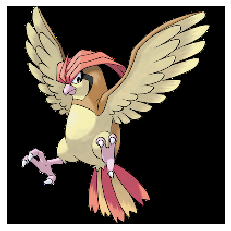

In [14]:
plt.imshow(batch[2])
plt.axis('off');
plt.show()

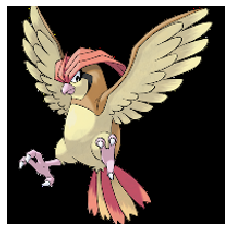

In [15]:
plt.imshow(aug_batch[2])
plt.axis('off');
plt.show()

In [16]:
train_ds = tf.data.Dataset.from_generator(
    lambda: generator_augmentor(train_gen), 
    output_types=(tf.float32, tf.float32) ,
    output_shapes=(tf.TensorShape((BATCH_SIZE, ) + IMG_SIZE), tf.TensorShape((BATCH_SIZE, ) + IMG_SIZE))
)

test_ds = tf.data.Dataset.from_generator(
    lambda: generator_augmentor(test_gen), 
    output_types=(tf.float32, tf.float32) ,
    output_shapes=(tf.TensorShape((BATCH_SIZE, ) + IMG_SIZE), tf.TensorShape((BATCH_SIZE, ) + IMG_SIZE))
)


In [17]:
_instance_scale=1.0
for data in generator_augmentor(train_gen):
    _instance_scale = float(data[0].max())
    break

In [18]:
_instance_scale

1.0

In [19]:
import numpy as np
from collections.abc import Iterable

In [20]:
if isinstance(inputs_shape, Iterable):
    _outputs_shape = np.prod(inputs_shape)

In [21]:
_outputs_shape

120000

# Model's Layers definition

In [22]:
enc_lays = [tf.keras.layers.Dense(units=intermediate_dim, activation='relu'),
            tf.keras.layers.Dense(units=intermediate_dim, activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(units=latent_dim)]

dec_lays = [tf.keras.layers.Dense(units=latent_dim, activation='relu'),
            tf.keras.layers.Dense(units=intermediate_dim, activation='relu'),
            tf.keras.layers.Dense(units=_outputs_shape),
            tf.keras.layers.Reshape(inputs_shape)]

# Model definition

In [23]:
model_name = dataset_name+'_augmented_TAE_Dense_reconst_ell'
recording_dir='recording'+sep_local+model_name

In [24]:
from training.autoencoding_basic.transformative.AE import autoencoder as AE

In [25]:
inputs_shape=IMG_SIZE

In [26]:
variables_params = \
[
    {
        'name': 'inference', 
        'inputs_shape':inputs_shape,
        'outputs_shape':latent_dim,
        'layers': enc_lays
    }

    ,
    
        {
        'name': 'generative', 
        'inputs_shape':latent_dim,
        'outputs_shape':inputs_shape,
        'layers':dec_lays
    }
]

In [27]:
from utils.data_and_files.file_utils import create_if_not_exist

In [28]:
_restore = os.path.join(recording_dir, 'var_save_dir')

In [29]:
create_if_not_exist(_restore)
_restore

'recording\\pokemon_augmented_TAE_Dense_reconst_ell\\var_save_dir'

In [30]:
#to restore trained model, set filepath=_restore

In [31]:
ae = AE( 
    name=model_name,
    inputs_shape=inputs_shape,
    outputs_shape=inputs_shape,
    latent_dim=latent_dim,
    batch_size=BATCH_SIZE,
    variables_params=variables_params, 
    filepath=None
    )

Model: "inference"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inference_inputs (InputLayer [(None, 200, 200, 3)]     0         
_________________________________________________________________
dense (Dense)                (None, 200, 200, 32)      128       
_________________________________________________________________
dense_1 (Dense)              (None, 200, 200, 32)      1056      
_________________________________________________________________
flatten (Flatten)            (None, 1280000)           0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                40960032  
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0 

  WARNING  | None


Model: "generative"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generative_inputs (InputLaye [(None, 32)]              0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 120000)            3960000   
_________________________________________________________________
reshape (Reshape)            (None, 200, 200, 3)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 200, 200, 3)       12        
_________________________________________________________________
dropout_1 (Dropout)          (None, 200, 200, 3)       0

  WARNING  | None


In [32]:
#ae.compile(metrics=None)
ae.compile()

Model: "pokemon_augmented_TAE_Dense_reconst_ell"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inference_inputs (InputLayer [(None, 200, 200, 3)]     0         
_________________________________________________________________
inference (Model)            (None, 32)                40961344  
_________________________________________________________________
generative (Model)           (None, 200, 200, 3)       3962124   
_________________________________________________________________
tf_op_layer_x_logits (Tensor [(None, 200, 200, 3)]     0         
Total params: 44,923,468
Trainable params: 44,923,398
Non-trainable params: 70
_________________________________________________________________
None


# Callbacks

In [33]:

from training.callbacks.sample_generation import SampleGeneration
from training.callbacks.save_model import ModelSaver

In [34]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='loss', 
    min_delta=1e-12, 
    patience=5, 
    verbose=1, 
    restore_best_weights=True
)

In [35]:
ms = ModelSaver(filepath=_restore,save_freq=5)

In [36]:
csv_dir = os.path.join(recording_dir, 'csv_dir')
create_if_not_exist(csv_dir)
csv_dir = os.path.join(csv_dir, ae.name+'.csv')
csv_log = tf.keras.callbacks.CSVLogger(csv_dir, append=True)
csv_dir

'recording\\pokemon_augmented_TAE_Dense_reconst_ell\\csv_dir\\pokemon_augmented_TAE_Dense_reconst_ell.csv'

In [37]:
image_gen_dir = os.path.join(recording_dir, 'image_gen_dir')
create_if_not_exist(image_gen_dir)

In [38]:
sg = SampleGeneration(latent_shape=latent_dim, filepath=image_gen_dir, gen_freq=5, save_img=True, gray_plot=False)

In [39]:
import numpy as np

# Model Training

In [ ]:
ae.fit(
    x=train_ds,
    input_kw=None,
    steps_per_epoch=1000,
    epochs=int(1e6), 
    verbose=2,
    callbacks=[ es, ms, csv_log, sg],
    workers=-1,
    use_multiprocessing=True,
    validation_data=test_ds,
    validation_steps=1000
)

Train for 1000 steps, validate for 1000 steps
Epoch 1/1000000


 101/1000 [==>...........................] - ETA: 1:14:54 - loss: 46577.2188 - psnr: 8.8103 - ssmi: 0.0538 - sharpdiff: 7.12 - ETA: 39:38 - loss: 91622.6953 - psnr: 9.1303 - ssmi: 0.0283 - sharpdiff: 5.6930 - ETA: 27:53 - loss: 115603.1875 - psnr: 9.1989 - ssmi: 0.0197 - sharpdiff: 5.212 - ETA: 22:01 - loss: 128391.8828 - psnr: 9.1432 - ssmi: 0.0155 - sharpdiff: 4.964 - ETA: 18:29 - loss: 143071.7906 - psnr: 8.8626 - ssmi: 0.0133 - sharpdiff: 4.829 - ETA: 16:07 - loss: 150840.5417 - psnr: 8.7667 - ssmi: 0.0119 - sharpdiff: 4.739 - ETA: 14:26 - loss: 146783.1618 - psnr: 8.8702 - ssmi: 0.0106 - sharpdiff: 4.674 - ETA: 13:09 - loss: 155294.5049 - psnr: 8.7500 - ssmi: 0.0102 - sharpdiff: 4.620 - ETA: 12:10 - loss: 155729.0964 - psnr: 8.7264 - ssmi: 0.0095 - sharpdiff: 4.584 - ETA: 11:23 - loss: 156629.6367 - psnr: 8.7031 - ssmi: 0.0089 - sharpdiff: 4.554 - ETA: 10:44 - loss: 161105.2507 - psnr: 8.6395 - ssmi: 0.0087 - sharpdiff: 4.525 - ETA: 10:11 - loss: 163429.8353 - psnr: 8.5994 - ssmi:

 203/1000 [=====>........................] - ETA: 4:36 - loss: 160887.1030 - psnr: 8.6030 - ssmi: 0.0047 - sharpdiff: 4.26 - ETA: 4:35 - loss: 160972.3456 - psnr: 8.6008 - ssmi: 0.0047 - sharpdiff: 4.26 - ETA: 4:35 - loss: 160870.2906 - psnr: 8.6002 - ssmi: 0.0047 - sharpdiff: 4.26 - ETA: 4:34 - loss: 161130.2947 - psnr: 8.5935 - ssmi: 0.0047 - sharpdiff: 4.26 - ETA: 4:33 - loss: 161455.1411 - psnr: 8.5900 - ssmi: 0.0047 - sharpdiff: 4.26 - ETA: 4:33 - loss: 161722.9601 - psnr: 8.5833 - ssmi: 0.0047 - sharpdiff: 4.26 - ETA: 4:32 - loss: 162016.6780 - psnr: 8.5768 - ssmi: 0.0047 - sharpdiff: 4.26 - ETA: 4:31 - loss: 162159.9414 - psnr: 8.5758 - ssmi: 0.0047 - sharpdiff: 4.26 - ETA: 4:31 - loss: 161370.1222 - psnr: 8.5902 - ssmi: 0.0047 - sharpdiff: 4.26 - ETA: 4:30 - loss: 160715.8743 - psnr: 8.6039 - ssmi: 0.0047 - sharpdiff: 4.26 - ETA: 4:29 - loss: 160138.8174 - psnr: 8.6138 - ssmi: 0.0047 - sharpdiff: 4.26 - ETA: 4:29 - loss: 159839.9619 - psnr: 8.6196 - ssmi: 0.0046 - sharpdiff: 4.

 305/1000 [========>.....................] - ETA: 3:47 - loss: 156443.6388 - psnr: 8.6212 - ssmi: 0.0044 - sharpdiff: 4.25 - ETA: 3:47 - loss: 156697.9906 - psnr: 8.6179 - ssmi: 0.0045 - sharpdiff: 4.25 - ETA: 3:47 - loss: 156384.6559 - psnr: 8.6239 - ssmi: 0.0044 - sharpdiff: 4.25 - ETA: 3:46 - loss: 156676.0976 - psnr: 8.6197 - ssmi: 0.0045 - sharpdiff: 4.25 - ETA: 3:46 - loss: 156504.2714 - psnr: 8.6236 - ssmi: 0.0044 - sharpdiff: 4.25 - ETA: 3:45 - loss: 156365.6549 - psnr: 8.6252 - ssmi: 0.0044 - sharpdiff: 4.25 - ETA: 3:45 - loss: 156420.2981 - psnr: 8.6233 - ssmi: 0.0044 - sharpdiff: 4.25 - ETA: 3:45 - loss: 156572.3407 - psnr: 8.6205 - ssmi: 0.0045 - sharpdiff: 4.25 - ETA: 3:44 - loss: 156768.3110 - psnr: 8.6173 - ssmi: 0.0045 - sharpdiff: 4.25 - ETA: 3:44 - loss: 156810.4568 - psnr: 8.6156 - ssmi: 0.0045 - sharpdiff: 4.25 - ETA: 3:44 - loss: 157016.3968 - psnr: 8.6128 - ssmi: 0.0045 - sharpdiff: 4.25 - ETA: 3:43 - loss: 157064.4452 - psnr: 8.6108 - ssmi: 0.0045 - sharpdiff: 4.

 407/1000 [===========>..................] - ETA: 3:13 - loss: 154650.0852 - psnr: 8.6182 - ssmi: 0.0044 - sharpdiff: 4.25 - ETA: 3:13 - loss: 154694.9762 - psnr: 8.6168 - ssmi: 0.0044 - sharpdiff: 4.25 - ETA: 3:13 - loss: 154511.5097 - psnr: 8.6196 - ssmi: 0.0044 - sharpdiff: 4.25 - ETA: 3:12 - loss: 154327.0569 - psnr: 8.6224 - ssmi: 0.0044 - sharpdiff: 4.25 - ETA: 3:12 - loss: 154370.5812 - psnr: 8.6207 - ssmi: 0.0044 - sharpdiff: 4.25 - ETA: 3:12 - loss: 154462.9070 - psnr: 8.6194 - ssmi: 0.0044 - sharpdiff: 4.25 - ETA: 3:11 - loss: 154484.8157 - psnr: 8.6188 - ssmi: 0.0044 - sharpdiff: 4.25 - ETA: 3:11 - loss: 154586.0507 - psnr: 8.6164 - ssmi: 0.0044 - sharpdiff: 4.25 - ETA: 3:11 - loss: 154587.2205 - psnr: 8.6160 - ssmi: 0.0044 - sharpdiff: 4.25 - ETA: 3:10 - loss: 154406.4980 - psnr: 8.6184 - ssmi: 0.0044 - sharpdiff: 4.25 - ETA: 3:10 - loss: 154210.7908 - psnr: 8.6224 - ssmi: 0.0044 - sharpdiff: 4.25 - ETA: 3:10 - loss: 154280.2430 - psnr: 8.6210 - ssmi: 0.0044 - sharpdiff: 4.

 509/1000 [==============>...............] - ETA: 2:43 - loss: 153095.0306 - psnr: 8.6171 - ssmi: 0.0044 - sharpdiff: 4.25 - ETA: 2:42 - loss: 153111.8441 - psnr: 8.6164 - ssmi: 0.0044 - sharpdiff: 4.25 - ETA: 2:42 - loss: 153185.1825 - psnr: 8.6150 - ssmi: 0.0044 - sharpdiff: 4.25 - ETA: 2:42 - loss: 152979.6464 - psnr: 8.6190 - ssmi: 0.0044 - sharpdiff: 4.25 - ETA: 2:42 - loss: 152813.4610 - psnr: 8.6217 - ssmi: 0.0043 - sharpdiff: 4.25 - ETA: 2:41 - loss: 152843.4725 - psnr: 8.6209 - ssmi: 0.0044 - sharpdiff: 4.25 - ETA: 2:41 - loss: 152952.4137 - psnr: 8.6184 - ssmi: 0.0044 - sharpdiff: 4.25 - ETA: 2:41 - loss: 152848.5357 - psnr: 8.6205 - ssmi: 0.0043 - sharpdiff: 4.25 - ETA: 2:40 - loss: 152889.6617 - psnr: 8.6194 - ssmi: 0.0044 - sharpdiff: 4.25 - ETA: 2:40 - loss: 152952.7453 - psnr: 8.6177 - ssmi: 0.0043 - sharpdiff: 4.25 - ETA: 2:40 - loss: 153103.8863 - psnr: 8.6152 - ssmi: 0.0044 - sharpdiff: 4.25 - ETA: 2:40 - loss: 153107.4118 - psnr: 8.6145 - ssmi: 0.0044 - sharpdiff: 4.

 611/1000 [=================>............] - ETA: 2:14 - loss: 151840.0797 - psnr: 8.6171 - ssmi: 0.0043 - sharpdiff: 4.26 - ETA: 2:14 - loss: 151889.5540 - psnr: 8.6163 - ssmi: 0.0044 - sharpdiff: 4.26 - ETA: 2:13 - loss: 151909.7911 - psnr: 8.6155 - ssmi: 0.0044 - sharpdiff: 4.26 - ETA: 2:13 - loss: 151768.8505 - psnr: 8.6182 - ssmi: 0.0043 - sharpdiff: 4.26 - ETA: 2:13 - loss: 151651.2936 - psnr: 8.6202 - ssmi: 0.0043 - sharpdiff: 4.26 - ETA: 2:12 - loss: 151761.1686 - psnr: 8.6190 - ssmi: 0.0044 - sharpdiff: 4.26 - ETA: 2:12 - loss: 151672.7037 - psnr: 8.6204 - ssmi: 0.0043 - sharpdiff: 4.26 - ETA: 2:12 - loss: 151683.8927 - psnr: 8.6195 - ssmi: 0.0043 - sharpdiff: 4.26 - ETA: 2:12 - loss: 151767.0400 - psnr: 8.6184 - ssmi: 0.0044 - sharpdiff: 4.26 - ETA: 2:11 - loss: 151664.1882 - psnr: 8.6198 - ssmi: 0.0043 - sharpdiff: 4.26 - ETA: 2:11 - loss: 151707.5659 - psnr: 8.6188 - ssmi: 0.0044 - sharpdiff: 4.26 - ETA: 2:11 - loss: 151744.7717 - psnr: 8.6178 - ssmi: 0.0044 - sharpdiff: 4.

 713/1000 [====================>.........] - ETA: 1:45 - loss: 149343.7963 - psnr: 8.6475 - ssmi: 0.0043 - sharpdiff: 4.26 - ETA: 1:45 - loss: 149252.5478 - psnr: 8.6488 - ssmi: 0.0043 - sharpdiff: 4.26 - ETA: 1:45 - loss: 149272.7035 - psnr: 8.6482 - ssmi: 0.0043 - sharpdiff: 4.26 - ETA: 1:45 - loss: 149146.3578 - psnr: 8.6507 - ssmi: 0.0043 - sharpdiff: 4.26 - ETA: 1:44 - loss: 149045.9125 - psnr: 8.6524 - ssmi: 0.0043 - sharpdiff: 4.26 - ETA: 1:44 - loss: 148948.9915 - psnr: 8.6541 - ssmi: 0.0043 - sharpdiff: 4.26 - ETA: 1:44 - loss: 148966.4718 - psnr: 8.6536 - ssmi: 0.0043 - sharpdiff: 4.26 - ETA: 1:43 - loss: 149033.5422 - psnr: 8.6518 - ssmi: 0.0043 - sharpdiff: 4.26 - ETA: 1:43 - loss: 148937.6984 - psnr: 8.6532 - ssmi: 0.0043 - sharpdiff: 4.26 - ETA: 1:43 - loss: 148873.3290 - psnr: 8.6547 - ssmi: 0.0043 - sharpdiff: 4.26 - ETA: 1:43 - loss: 148740.2711 - psnr: 8.6574 - ssmi: 0.0043 - sharpdiff: 4.26 - ETA: 1:42 - loss: 148799.2477 - psnr: 8.6564 - ssmi: 0.0043 - sharpdiff: 4.

 815/1000 [=======================>......] - ETA: 1:17 - loss: 146911.8479 - psnr: 8.6746 - ssmi: 0.0043 - sharpdiff: 4.26 - ETA: 1:17 - loss: 146828.2267 - psnr: 8.6759 - ssmi: 0.0043 - sharpdiff: 4.26 - ETA: 1:17 - loss: 146770.2975 - psnr: 8.6767 - ssmi: 0.0043 - sharpdiff: 4.26 - ETA: 1:16 - loss: 146828.1650 - psnr: 8.6752 - ssmi: 0.0043 - sharpdiff: 4.26 - ETA: 1:16 - loss: 146713.9371 - psnr: 8.6775 - ssmi: 0.0043 - sharpdiff: 4.26 - ETA: 1:16 - loss: 146730.8257 - psnr: 8.6767 - ssmi: 0.0043 - sharpdiff: 4.26 - ETA: 1:16 - loss: 146735.5531 - psnr: 8.6763 - ssmi: 0.0043 - sharpdiff: 4.26 - ETA: 1:15 - loss: 146757.8665 - psnr: 8.6756 - ssmi: 0.0043 - sharpdiff: 4.26 - ETA: 1:15 - loss: 146783.8092 - psnr: 8.6750 - ssmi: 0.0043 - sharpdiff: 4.26 - ETA: 1:15 - loss: 146691.0160 - psnr: 8.6766 - ssmi: 0.0043 - sharpdiff: 4.26 - ETA: 1:15 - loss: 146753.4512 - psnr: 8.6753 - ssmi: 0.0043 - sharpdiff: 4.26 - ETA: 1:14 - loss: 146672.9458 - psnr: 8.6767 - ssmi: 0.0043 - sharpdiff: 4.

 917/1000 [==========================>...] - ETA: 49s - loss: 145437.6654 - psnr: 8.6861 - ssmi: 0.0043 - sharpdiff: 4.267 - ETA: 49s - loss: 145447.0028 - psnr: 8.6855 - ssmi: 0.0043 - sharpdiff: 4.267 - ETA: 49s - loss: 145461.7643 - psnr: 8.6851 - ssmi: 0.0043 - sharpdiff: 4.267 - ETA: 49s - loss: 145474.4236 - psnr: 8.6847 - ssmi: 0.0043 - sharpdiff: 4.268 - ETA: 48s - loss: 145518.2060 - psnr: 8.6838 - ssmi: 0.0044 - sharpdiff: 4.268 - ETA: 48s - loss: 145530.5790 - psnr: 8.6830 - ssmi: 0.0044 - sharpdiff: 4.268 - ETA: 48s - loss: 145492.4676 - psnr: 8.6835 - ssmi: 0.0044 - sharpdiff: 4.268 - ETA: 47s - loss: 145465.8221 - psnr: 8.6838 - ssmi: 0.0044 - sharpdiff: 4.268 - ETA: 47s - loss: 145493.9416 - psnr: 8.6831 - ssmi: 0.0044 - sharpdiff: 4.268 - ETA: 47s - loss: 145506.8766 - psnr: 8.6825 - ssmi: 0.0044 - sharpdiff: 4.268 - ETA: 47s - loss: 145516.7981 - psnr: 8.6819 - ssmi: 0.0044 - sharpdiff: 4.268 - ETA: 46s - loss: 145439.9251 - psnr: 8.6834 - ssmi: 0.0044 - sharpdiff: 4.2

1000/1000 [==============================] - ETA: 22s - loss: 143915.8426 - psnr: 8.6995 - ssmi: 0.0044 - sharpdiff: 4.270 - ETA: 21s - loss: 143830.8360 - psnr: 8.7012 - ssmi: 0.0044 - sharpdiff: 4.270 - ETA: 21s - loss: 143838.1283 - psnr: 8.7010 - ssmi: 0.0044 - sharpdiff: 4.270 - ETA: 21s - loss: 143771.0072 - psnr: 8.7022 - ssmi: 0.0044 - sharpdiff: 4.270 - ETA: 21s - loss: 143703.6469 - psnr: 8.7034 - ssmi: 0.0044 - sharpdiff: 4.270 - ETA: 20s - loss: 143707.3227 - psnr: 8.7032 - ssmi: 0.0044 - sharpdiff: 4.270 - ETA: 20s - loss: 143754.2498 - psnr: 8.7025 - ssmi: 0.0044 - sharpdiff: 4.270 - ETA: 20s - loss: 143693.1546 - psnr: 8.7035 - ssmi: 0.0044 - sharpdiff: 4.270 - ETA: 20s - loss: 143749.3593 - psnr: 8.7024 - ssmi: 0.0044 - sharpdiff: 4.270 - ETA: 19s - loss: 143774.6948 - psnr: 8.7018 - ssmi: 0.0044 - sharpdiff: 4.270 - ETA: 19s - loss: 143798.0496 - psnr: 8.7012 - ssmi: 0.0044 - sharpdiff: 4.270 - ETA: 19s - loss: 143839.8060 - psnr: 8.7000 - ssmi: 0.0044 - sharpdiff: 4.2

 102/1000 [==>...........................] - ETA: 4:54 - loss: 154680.1094 - psnr: 8.2363 - ssmi: 0.0055 - sharpdiff: 4.30 - ETA: 4:43 - loss: 123693.0742 - psnr: 8.9758 - ssmi: 0.0047 - sharpdiff: 4.33 - ETA: 4:37 - loss: 133312.6536 - psnr: 8.7279 - ssmi: 0.0049 - sharpdiff: 4.32 - ETA: 4:33 - loss: 132676.5137 - psnr: 8.7168 - ssmi: 0.0048 - sharpdiff: 4.33 - ETA: 4:32 - loss: 126279.0203 - psnr: 8.8456 - ssmi: 0.0047 - sharpdiff: 4.33 - ETA: 4:53 - loss: 131108.6003 - psnr: 8.7591 - ssmi: 0.0048 - sharpdiff: 4.33 - ETA: 4:49 - loss: 121661.1077 - psnr: 8.9775 - ssmi: 0.0046 - sharpdiff: 4.30 - ETA: 4:46 - loss: 124815.2954 - psnr: 8.9183 - ssmi: 0.0048 - sharpdiff: 4.31 - ETA: 4:42 - loss: 127744.3424 - psnr: 8.8437 - ssmi: 0.0049 - sharpdiff: 4.31 - ETA: 4:41 - loss: 132430.4363 - psnr: 8.7837 - ssmi: 0.0051 - sharpdiff: 4.31 - ETA: 4:39 - loss: 126455.8271 - psnr: 8.9152 - ssmi: 0.0050 - sharpdiff: 4.30 - ETA: 4:37 - loss: 126827.7855 - psnr: 8.9212 - ssmi: 0.0049 - sharpdiff: 4.

 204/1000 [=====>........................] - ETA: 3:59 - loss: 122219.2759 - psnr: 8.9566 - ssmi: 0.0047 - sharpdiff: 4.30 - ETA: 3:58 - loss: 122368.8165 - psnr: 8.9539 - ssmi: 0.0047 - sharpdiff: 4.30 - ETA: 3:58 - loss: 122638.8937 - psnr: 8.9483 - ssmi: 0.0047 - sharpdiff: 4.30 - ETA: 3:58 - loss: 122404.3839 - psnr: 8.9554 - ssmi: 0.0047 - sharpdiff: 4.30 - ETA: 3:57 - loss: 122903.6728 - psnr: 8.9457 - ssmi: 0.0048 - sharpdiff: 4.30 - ETA: 3:57 - loss: 123313.5348 - psnr: 8.9408 - ssmi: 0.0048 - sharpdiff: 4.30 - ETA: 3:57 - loss: 123848.7763 - psnr: 8.9320 - ssmi: 0.0048 - sharpdiff: 4.30 - ETA: 3:57 - loss: 124031.3350 - psnr: 8.9270 - ssmi: 0.0048 - sharpdiff: 4.30 - ETA: 3:56 - loss: 124255.7490 - psnr: 8.9202 - ssmi: 0.0048 - sharpdiff: 4.30 - ETA: 3:56 - loss: 124715.5159 - psnr: 8.9120 - ssmi: 0.0048 - sharpdiff: 4.30 - ETA: 3:56 - loss: 124319.6259 - psnr: 8.9208 - ssmi: 0.0048 - sharpdiff: 4.30 - ETA: 3:55 - loss: 124530.9125 - psnr: 8.9144 - ssmi: 0.0048 - sharpdiff: 4.

 306/1000 [========>.....................] - ETA: 3:31 - loss: 127141.5536 - psnr: 8.8463 - ssmi: 0.0050 - sharpdiff: 4.31 - ETA: 3:31 - loss: 127169.0019 - psnr: 8.8460 - ssmi: 0.0050 - sharpdiff: 4.31 - ETA: 3:31 - loss: 126976.3766 - psnr: 8.8491 - ssmi: 0.0050 - sharpdiff: 4.31 - ETA: 3:30 - loss: 127029.1580 - psnr: 8.8470 - ssmi: 0.0050 - sharpdiff: 4.31 - ETA: 3:30 - loss: 127247.5621 - psnr: 8.8429 - ssmi: 0.0050 - sharpdiff: 4.31 - ETA: 3:30 - loss: 127382.4174 - psnr: 8.8384 - ssmi: 0.0050 - sharpdiff: 4.31 - ETA: 3:29 - loss: 127098.8733 - psnr: 8.8447 - ssmi: 0.0050 - sharpdiff: 4.31 - ETA: 3:29 - loss: 126930.0871 - psnr: 8.8479 - ssmi: 0.0050 - sharpdiff: 4.31 - ETA: 3:29 - loss: 126715.8016 - psnr: 8.8530 - ssmi: 0.0050 - sharpdiff: 4.31 - ETA: 3:29 - loss: 126818.3962 - psnr: 8.8503 - ssmi: 0.0050 - sharpdiff: 4.31 - ETA: 3:28 - loss: 126852.4700 - psnr: 8.8492 - ssmi: 0.0050 - sharpdiff: 4.31 - ETA: 3:28 - loss: 126637.8349 - psnr: 8.8539 - ssmi: 0.0050 - sharpdiff: 4.

 408/1000 [===========>..................] - ETA: 3:04 - loss: 126567.1037 - psnr: 8.8436 - ssmi: 0.0052 - sharpdiff: 4.33 - ETA: 3:04 - loss: 126591.4266 - psnr: 8.8427 - ssmi: 0.0052 - sharpdiff: 4.33 - ETA: 3:03 - loss: 126681.7035 - psnr: 8.8404 - ssmi: 0.0052 - sharpdiff: 4.33 - ETA: 3:03 - loss: 126511.9264 - psnr: 8.8440 - ssmi: 0.0052 - sharpdiff: 4.33 - ETA: 3:03 - loss: 126315.3827 - psnr: 8.8484 - ssmi: 0.0052 - sharpdiff: 4.33 - ETA: 3:02 - loss: 126389.4906 - psnr: 8.8467 - ssmi: 0.0052 - sharpdiff: 4.33 - ETA: 3:02 - loss: 126429.4043 - psnr: 8.8458 - ssmi: 0.0052 - sharpdiff: 4.33 - ETA: 3:02 - loss: 126262.0651 - psnr: 8.8494 - ssmi: 0.0052 - sharpdiff: 4.33 - ETA: 3:02 - loss: 126130.5303 - psnr: 8.8519 - ssmi: 0.0052 - sharpdiff: 4.33 - ETA: 3:01 - loss: 125982.5358 - psnr: 8.8551 - ssmi: 0.0052 - sharpdiff: 4.33 - ETA: 3:01 - loss: 126100.8626 - psnr: 8.8518 - ssmi: 0.0052 - sharpdiff: 4.33 - ETA: 3:01 - loss: 125966.5224 - psnr: 8.8541 - ssmi: 0.0052 - sharpdiff: 4.

 510/1000 [==============>...............] - ETA: 2:37 - loss: 124346.8082 - psnr: 8.8782 - ssmi: 0.0053 - sharpdiff: 4.33 - ETA: 2:37 - loss: 124440.3893 - psnr: 8.8765 - ssmi: 0.0053 - sharpdiff: 4.33 - ETA: 2:36 - loss: 124293.9630 - psnr: 8.8798 - ssmi: 0.0053 - sharpdiff: 4.33 - ETA: 2:36 - loss: 124334.8745 - psnr: 8.8787 - ssmi: 0.0053 - sharpdiff: 4.33 - ETA: 2:36 - loss: 124357.7119 - psnr: 8.8777 - ssmi: 0.0053 - sharpdiff: 4.33 - ETA: 2:36 - loss: 124435.7548 - psnr: 8.8761 - ssmi: 0.0053 - sharpdiff: 4.33 - ETA: 2:35 - loss: 124517.1551 - psnr: 8.8741 - ssmi: 0.0053 - sharpdiff: 4.33 - ETA: 2:35 - loss: 124401.3713 - psnr: 8.8766 - ssmi: 0.0053 - sharpdiff: 4.33 - ETA: 2:35 - loss: 124256.2862 - psnr: 8.8800 - ssmi: 0.0053 - sharpdiff: 4.33 - ETA: 2:34 - loss: 124144.9518 - psnr: 8.8828 - ssmi: 0.0053 - sharpdiff: 4.33 - ETA: 2:34 - loss: 124036.8042 - psnr: 8.8850 - ssmi: 0.0053 - sharpdiff: 4.33 - ETA: 2:34 - loss: 124089.2475 - psnr: 8.8834 - ssmi: 0.0053 - sharpdiff: 4.

 612/1000 [=================>............] - ETA: 2:10 - loss: 124034.2903 - psnr: 8.8728 - ssmi: 0.0055 - sharpdiff: 4.34 - ETA: 2:09 - loss: 124071.7959 - psnr: 8.8716 - ssmi: 0.0055 - sharpdiff: 4.34 - ETA: 2:09 - loss: 123970.5860 - psnr: 8.8737 - ssmi: 0.0055 - sharpdiff: 4.34 - ETA: 2:09 - loss: 123883.6388 - psnr: 8.8752 - ssmi: 0.0055 - sharpdiff: 4.34 - ETA: 2:09 - loss: 123790.2053 - psnr: 8.8771 - ssmi: 0.0055 - sharpdiff: 4.34 - ETA: 2:08 - loss: 123812.0149 - psnr: 8.8764 - ssmi: 0.0055 - sharpdiff: 4.34 - ETA: 2:08 - loss: 123856.8277 - psnr: 8.8751 - ssmi: 0.0055 - sharpdiff: 4.34 - ETA: 2:08 - loss: 123761.1539 - psnr: 8.8769 - ssmi: 0.0055 - sharpdiff: 4.34 - ETA: 2:07 - loss: 123663.8127 - psnr: 8.8791 - ssmi: 0.0055 - sharpdiff: 4.34 - ETA: 2:07 - loss: 123716.7941 - psnr: 8.8777 - ssmi: 0.0055 - sharpdiff: 4.34 - ETA: 2:07 - loss: 123770.7793 - psnr: 8.8764 - ssmi: 0.0055 - sharpdiff: 4.34 - ETA: 2:07 - loss: 123779.1166 - psnr: 8.8760 - ssmi: 0.0055 - sharpdiff: 4.

 714/1000 [====================>.........] - ETA: 1:42 - loss: 123013.7555 - psnr: 8.8845 - ssmi: 0.0057 - sharpdiff: 4.35 - ETA: 1:42 - loss: 123057.3849 - psnr: 8.8830 - ssmi: 0.0057 - sharpdiff: 4.35 - ETA: 1:42 - loss: 122965.9378 - psnr: 8.8849 - ssmi: 0.0057 - sharpdiff: 4.35 - ETA: 1:42 - loss: 122922.4829 - psnr: 8.8855 - ssmi: 0.0057 - sharpdiff: 4.35 - ETA: 1:41 - loss: 122820.9649 - psnr: 8.8878 - ssmi: 0.0057 - sharpdiff: 4.35 - ETA: 1:41 - loss: 122839.1010 - psnr: 8.8874 - ssmi: 0.0057 - sharpdiff: 4.35 - ETA: 1:41 - loss: 122899.3393 - psnr: 8.8859 - ssmi: 0.0057 - sharpdiff: 4.35 - ETA: 1:41 - loss: 122901.2568 - psnr: 8.8857 - ssmi: 0.0057 - sharpdiff: 4.35 - ETA: 1:40 - loss: 122896.5348 - psnr: 8.8858 - ssmi: 0.0057 - sharpdiff: 4.35 - ETA: 1:40 - loss: 122926.8897 - psnr: 8.8846 - ssmi: 0.0057 - sharpdiff: 4.35 - ETA: 1:40 - loss: 122846.0955 - psnr: 8.8863 - ssmi: 0.0057 - sharpdiff: 4.35 - ETA: 1:40 - loss: 122917.3679 - psnr: 8.8852 - ssmi: 0.0057 - sharpdiff: 4.

 816/1000 [=======================>......] - ETA: 1:15 - loss: 121754.5573 - psnr: 8.8981 - ssmi: 0.0058 - sharpdiff: 4.36 - ETA: 1:15 - loss: 121772.1157 - psnr: 8.8975 - ssmi: 0.0058 - sharpdiff: 4.36 - ETA: 1:15 - loss: 121696.4644 - psnr: 8.8993 - ssmi: 0.0058 - sharpdiff: 4.36 - ETA: 1:14 - loss: 121616.2272 - psnr: 8.9010 - ssmi: 0.0058 - sharpdiff: 4.36 - ETA: 1:14 - loss: 121570.3865 - psnr: 8.9017 - ssmi: 0.0058 - sharpdiff: 4.36 - ETA: 1:14 - loss: 121487.1799 - psnr: 8.9039 - ssmi: 0.0058 - sharpdiff: 4.36 - ETA: 1:14 - loss: 121401.7074 - psnr: 8.9059 - ssmi: 0.0058 - sharpdiff: 4.36 - ETA: 1:13 - loss: 121393.6322 - psnr: 8.9059 - ssmi: 0.0058 - sharpdiff: 4.36 - ETA: 1:13 - loss: 121330.5035 - psnr: 8.9072 - ssmi: 0.0058 - sharpdiff: 4.36 - ETA: 1:13 - loss: 121339.5827 - psnr: 8.9070 - ssmi: 0.0058 - sharpdiff: 4.36 - ETA: 1:13 - loss: 121416.2493 - psnr: 8.9057 - ssmi: 0.0058 - sharpdiff: 4.36 - ETA: 1:12 - loss: 121447.4257 - psnr: 8.9048 - ssmi: 0.0058 - sharpdiff: 4.

 918/1000 [==========================>...] - ETA: 48s - loss: 120325.8359 - psnr: 8.9195 - ssmi: 0.0061 - sharpdiff: 4.373 - ETA: 48s - loss: 120344.2541 - psnr: 8.9189 - ssmi: 0.0061 - sharpdiff: 4.373 - ETA: 48s - loss: 120266.4850 - psnr: 8.9207 - ssmi: 0.0061 - sharpdiff: 4.373 - ETA: 47s - loss: 120264.1234 - psnr: 8.9207 - ssmi: 0.0061 - sharpdiff: 4.373 - ETA: 47s - loss: 120284.4519 - psnr: 8.9202 - ssmi: 0.0061 - sharpdiff: 4.374 - ETA: 47s - loss: 120306.5799 - psnr: 8.9197 - ssmi: 0.0061 - sharpdiff: 4.374 - ETA: 47s - loss: 120282.5215 - psnr: 8.9198 - ssmi: 0.0061 - sharpdiff: 4.374 - ETA: 46s - loss: 120301.7475 - psnr: 8.9190 - ssmi: 0.0061 - sharpdiff: 4.374 - ETA: 46s - loss: 120247.2212 - psnr: 8.9201 - ssmi: 0.0061 - sharpdiff: 4.374 - ETA: 46s - loss: 120263.2390 - psnr: 8.9195 - ssmi: 0.0061 - sharpdiff: 4.374 - ETA: 45s - loss: 120209.3451 - psnr: 8.9206 - ssmi: 0.0061 - sharpdiff: 4.374 - ETA: 45s - loss: 120232.3710 - psnr: 8.9200 - ssmi: 0.0061 - sharpdiff: 4.3

1000/1000 [==============================] - ETA: 21s - loss: 118642.8688 - psnr: 8.9464 - ssmi: 0.0063 - sharpdiff: 4.385 - ETA: 21s - loss: 118579.1297 - psnr: 8.9478 - ssmi: 0.0063 - sharpdiff: 4.385 - ETA: 20s - loss: 118532.7193 - psnr: 8.9488 - ssmi: 0.0063 - sharpdiff: 4.385 - ETA: 20s - loss: 118538.6726 - psnr: 8.9485 - ssmi: 0.0063 - sharpdiff: 4.386 - ETA: 20s - loss: 118554.5214 - psnr: 8.9483 - ssmi: 0.0063 - sharpdiff: 4.386 - ETA: 20s - loss: 118573.4513 - psnr: 8.9476 - ssmi: 0.0063 - sharpdiff: 4.386 - ETA: 19s - loss: 118515.1276 - psnr: 8.9489 - ssmi: 0.0063 - sharpdiff: 4.386 - ETA: 19s - loss: 118452.9160 - psnr: 8.9505 - ssmi: 0.0063 - sharpdiff: 4.386 - ETA: 19s - loss: 118451.6500 - psnr: 8.9503 - ssmi: 0.0063 - sharpdiff: 4.386 - ETA: 19s - loss: 118429.9108 - psnr: 8.9505 - ssmi: 0.0063 - sharpdiff: 4.386 - ETA: 18s - loss: 118389.2385 - psnr: 8.9512 - ssmi: 0.0063 - sharpdiff: 4.387 - ETA: 18s - loss: 118356.2589 - psnr: 8.9515 - ssmi: 0.0063 - sharpdiff: 4.3

 102/1000 [==>...........................] - ETA: 4:28 - loss: 69568.2812 - psnr: 9.9664 - ssmi: 0.0056 - sharpdiff: 4.533 - ETA: 4:27 - loss: 91320.6289 - psnr: 9.4235 - ssmi: 0.0075 - sharpdiff: 4.545 - ETA: 4:27 - loss: 84132.9245 - psnr: 9.5912 - ssmi: 0.0075 - sharpdiff: 4.538 - ETA: 4:27 - loss: 94440.2812 - psnr: 9.3374 - ssmi: 0.0083 - sharpdiff: 4.533 - ETA: 4:27 - loss: 89497.2906 - psnr: 9.4720 - ssmi: 0.0078 - sharpdiff: 4.530 - ETA: 4:26 - loss: 89432.7083 - psnr: 9.4984 - ssmi: 0.0079 - sharpdiff: 4.531 - ETA: 4:26 - loss: 85158.3811 - psnr: 9.6055 - ssmi: 0.0074 - sharpdiff: 4.495 - ETA: 4:26 - loss: 83378.5728 - psnr: 9.6381 - ssmi: 0.0073 - sharpdiff: 4.502 - ETA: 4:25 - loss: 88147.8398 - psnr: 9.5222 - ssmi: 0.0076 - sharpdiff: 4.510 - ETA: 4:25 - loss: 93173.1512 - psnr: 9.4269 - ssmi: 0.0082 - sharpdiff: 4.512 - ETA: 4:26 - loss: 95524.0572 - psnr: 9.3789 - ssmi: 0.0084 - sharpdiff: 4.516 - ETA: 4:26 - loss: 97786.5303 - psnr: 9.3129 - ssmi: 0.0086 - sharpdiff: 4.5

 204/1000 [=====>........................] - ETA: 3:58 - loss: 98404.1688 - psnr: 9.3268 - ssmi: 0.0089 - sharpdiff: 4.514 - ETA: 3:58 - loss: 98727.0328 - psnr: 9.3196 - ssmi: 0.0090 - sharpdiff: 4.515 - ETA: 3:58 - loss: 98427.9105 - psnr: 9.3259 - ssmi: 0.0090 - sharpdiff: 4.515 - ETA: 3:57 - loss: 98775.1288 - psnr: 9.3188 - ssmi: 0.0090 - sharpdiff: 4.516 - ETA: 3:57 - loss: 99040.3419 - psnr: 9.3128 - ssmi: 0.0090 - sharpdiff: 4.516 - ETA: 3:57 - loss: 99321.2768 - psnr: 9.3053 - ssmi: 0.0091 - sharpdiff: 4.516 - ETA: 3:57 - loss: 99442.3404 - psnr: 9.3058 - ssmi: 0.0091 - sharpdiff: 4.517 - ETA: 3:56 - loss: 99152.2064 - psnr: 9.3124 - ssmi: 0.0091 - sharpdiff: 4.518 - ETA: 3:56 - loss: 98831.9408 - psnr: 9.3199 - ssmi: 0.0091 - sharpdiff: 4.518 - ETA: 3:56 - loss: 98476.3894 - psnr: 9.3281 - ssmi: 0.0090 - sharpdiff: 4.517 - ETA: 3:55 - loss: 98178.4394 - psnr: 9.3349 - ssmi: 0.0090 - sharpdiff: 4.517 - ETA: 3:55 - loss: 98649.0327 - psnr: 9.3258 - ssmi: 0.0090 - sharpdiff: 4.5

 306/1000 [========>.....................] - ETA: 3:31 - loss: 100441.6982 - psnr: 9.2869 - ssmi: 0.0098 - sharpdiff: 4.53 - ETA: 3:30 - loss: 100651.9979 - psnr: 9.2831 - ssmi: 0.0098 - sharpdiff: 4.53 - ETA: 3:30 - loss: 100681.1069 - psnr: 9.2820 - ssmi: 0.0098 - sharpdiff: 4.53 - ETA: 3:30 - loss: 100702.3454 - psnr: 9.2808 - ssmi: 0.0098 - sharpdiff: 4.53 - ETA: 3:30 - loss: 100784.4215 - psnr: 9.2779 - ssmi: 0.0098 - sharpdiff: 4.53 - ETA: 3:29 - loss: 100850.3721 - psnr: 9.2757 - ssmi: 0.0098 - sharpdiff: 4.53 - ETA: 3:29 - loss: 100861.4949 - psnr: 9.2752 - ssmi: 0.0098 - sharpdiff: 4.53 - ETA: 3:29 - loss: 100979.0675 - psnr: 9.2717 - ssmi: 0.0098 - sharpdiff: 4.53 - ETA: 3:28 - loss: 101000.3418 - psnr: 9.2707 - ssmi: 0.0098 - sharpdiff: 4.53 - ETA: 3:28 - loss: 100802.0248 - psnr: 9.2752 - ssmi: 0.0098 - sharpdiff: 4.53 - ETA: 3:28 - loss: 100882.6043 - psnr: 9.2719 - ssmi: 0.0098 - sharpdiff: 4.53 - ETA: 3:28 - loss: 100683.4764 - psnr: 9.2764 - ssmi: 0.0098 - sharpdiff: 4.

 408/1000 [===========>..................] - ETA: 3:03 - loss: 100233.2508 - psnr: 9.2682 - ssmi: 0.0101 - sharpdiff: 4.54 - ETA: 3:03 - loss: 100240.0824 - psnr: 9.2676 - ssmi: 0.0101 - sharpdiff: 4.54 - ETA: 3:03 - loss: 100275.6021 - psnr: 9.2660 - ssmi: 0.0101 - sharpdiff: 4.54 - ETA: 3:03 - loss: 100131.1512 - psnr: 9.2693 - ssmi: 0.0101 - sharpdiff: 4.54 - ETA: 3:02 - loss: 100185.7098 - psnr: 9.2680 - ssmi: 0.0101 - sharpdiff: 4.54 - ETA: 3:02 - loss: 100197.9660 - psnr: 9.2679 - ssmi: 0.0101 - sharpdiff: 4.54 - ETA: 3:02 - loss: 100213.6830 - psnr: 9.2674 - ssmi: 0.0101 - sharpdiff: 4.54 - ETA: 3:02 - loss: 100318.6616 - psnr: 9.2650 - ssmi: 0.0101 - sharpdiff: 4.54 - ETA: 3:01 - loss: 100225.6457 - psnr: 9.2669 - ssmi: 0.0101 - sharpdiff: 4.54 - ETA: 3:01 - loss: 100278.0020 - psnr: 9.2649 - ssmi: 0.0101 - sharpdiff: 4.54 - ETA: 3:01 - loss: 100166.6029 - psnr: 9.2672 - ssmi: 0.0101 - sharpdiff: 4.54 - ETA: 3:00 - loss: 100208.6876 - psnr: 9.2661 - ssmi: 0.0102 - sharpdiff: 4.

 510/1000 [==============>...............] - ETA: 2:36 - loss: 99158.4690 - psnr: 9.2833 - ssmi: 0.0106 - sharpdiff: 4.565 - ETA: 2:36 - loss: 99063.6276 - psnr: 9.2858 - ssmi: 0.0106 - sharpdiff: 4.565 - ETA: 2:36 - loss: 99141.4159 - psnr: 9.2833 - ssmi: 0.0106 - sharpdiff: 4.566 - ETA: 2:35 - loss: 99151.5545 - psnr: 9.2830 - ssmi: 0.0106 - sharpdiff: 4.566 - ETA: 2:35 - loss: 99148.6923 - psnr: 9.2828 - ssmi: 0.0107 - sharpdiff: 4.566 - ETA: 2:35 - loss: 99087.4637 - psnr: 9.2845 - ssmi: 0.0107 - sharpdiff: 4.566 - ETA: 2:35 - loss: 99114.5395 - psnr: 9.2836 - ssmi: 0.0107 - sharpdiff: 4.566 - ETA: 2:34 - loss: 99147.8911 - psnr: 9.2832 - ssmi: 0.0107 - sharpdiff: 4.567 - ETA: 2:34 - loss: 99184.2835 - psnr: 9.2818 - ssmi: 0.0107 - sharpdiff: 4.567 - ETA: 2:34 - loss: 99097.4695 - psnr: 9.2839 - ssmi: 0.0107 - sharpdiff: 4.567 - ETA: 2:34 - loss: 99130.3139 - psnr: 9.2828 - ssmi: 0.0107 - sharpdiff: 4.567 - ETA: 2:33 - loss: 99141.0004 - psnr: 9.2821 - ssmi: 0.0107 - sharpdiff: 4.5

 612/1000 [=================>............] - ETA: 2:09 - loss: 98607.1565 - psnr: 9.2865 - ssmi: 0.0112 - sharpdiff: 4.583 - ETA: 2:09 - loss: 98672.6123 - psnr: 9.2849 - ssmi: 0.0112 - sharpdiff: 4.583 - ETA: 2:09 - loss: 98583.3136 - psnr: 9.2869 - ssmi: 0.0112 - sharpdiff: 4.583 - ETA: 2:08 - loss: 98618.0266 - psnr: 9.2859 - ssmi: 0.0112 - sharpdiff: 4.583 - ETA: 2:08 - loss: 98555.7780 - psnr: 9.2871 - ssmi: 0.0112 - sharpdiff: 4.583 - ETA: 2:08 - loss: 98477.0463 - psnr: 9.2890 - ssmi: 0.0112 - sharpdiff: 4.583 - ETA: 2:08 - loss: 98402.9042 - psnr: 9.2908 - ssmi: 0.0112 - sharpdiff: 4.583 - ETA: 2:07 - loss: 98376.7770 - psnr: 9.2908 - ssmi: 0.0112 - sharpdiff: 4.584 - ETA: 2:07 - loss: 98297.3838 - psnr: 9.2929 - ssmi: 0.0112 - sharpdiff: 4.584 - ETA: 2:07 - loss: 98333.4695 - psnr: 9.2916 - ssmi: 0.0112 - sharpdiff: 4.584 - ETA: 2:07 - loss: 98251.5343 - psnr: 9.2934 - ssmi: 0.0112 - sharpdiff: 4.584 - ETA: 2:06 - loss: 98168.6542 - psnr: 9.2952 - ssmi: 0.0112 - sharpdiff: 4.5

 714/1000 [====================>.........] - ETA: 1:42 - loss: 97486.1315 - psnr: 9.3042 - ssmi: 0.0117 - sharpdiff: 4.599 - ETA: 1:42 - loss: 97415.3550 - psnr: 9.3058 - ssmi: 0.0117 - sharpdiff: 4.599 - ETA: 1:42 - loss: 97344.7011 - psnr: 9.3073 - ssmi: 0.0117 - sharpdiff: 4.598 - ETA: 1:41 - loss: 97384.5451 - psnr: 9.3067 - ssmi: 0.0117 - sharpdiff: 4.599 - ETA: 1:41 - loss: 97317.9787 - psnr: 9.3083 - ssmi: 0.0117 - sharpdiff: 4.599 - ETA: 1:41 - loss: 97316.7636 - psnr: 9.3078 - ssmi: 0.0117 - sharpdiff: 4.599 - ETA: 1:41 - loss: 97313.2368 - psnr: 9.3079 - ssmi: 0.0118 - sharpdiff: 4.599 - ETA: 1:40 - loss: 97247.3633 - psnr: 9.3093 - ssmi: 0.0117 - sharpdiff: 4.599 - ETA: 1:40 - loss: 97306.4781 - psnr: 9.3082 - ssmi: 0.0118 - sharpdiff: 4.599 - ETA: 1:40 - loss: 97346.0374 - psnr: 9.3071 - ssmi: 0.0118 - sharpdiff: 4.599 - ETA: 1:40 - loss: 97332.6678 - psnr: 9.3075 - ssmi: 0.0118 - sharpdiff: 4.600 - ETA: 1:39 - loss: 97267.4284 - psnr: 9.3093 - ssmi: 0.0118 - sharpdiff: 4.6

 817/1000 [=======================>......] - ETA: 1:15 - loss: 96890.2092 - psnr: 9.3113 - ssmi: 0.0122 - sharpdiff: 4.613 - ETA: 1:15 - loss: 96860.3077 - psnr: 9.3119 - ssmi: 0.0122 - sharpdiff: 4.613 - ETA: 1:15 - loss: 96834.1386 - psnr: 9.3126 - ssmi: 0.0122 - sharpdiff: 4.613 - ETA: 1:14 - loss: 96848.5042 - psnr: 9.3120 - ssmi: 0.0122 - sharpdiff: 4.614 - ETA: 1:14 - loss: 96849.2784 - psnr: 9.3118 - ssmi: 0.0122 - sharpdiff: 4.614 - ETA: 1:14 - loss: 96805.3000 - psnr: 9.3128 - ssmi: 0.0122 - sharpdiff: 4.614 - ETA: 1:14 - loss: 96792.3054 - psnr: 9.3127 - ssmi: 0.0122 - sharpdiff: 4.614 - ETA: 1:13 - loss: 96813.9980 - psnr: 9.3120 - ssmi: 0.0122 - sharpdiff: 4.614 - ETA: 1:13 - loss: 96829.2832 - psnr: 9.3112 - ssmi: 0.0122 - sharpdiff: 4.615 - ETA: 1:13 - loss: 96785.6407 - psnr: 9.3126 - ssmi: 0.0123 - sharpdiff: 4.615 - ETA: 1:13 - loss: 96820.2478 - psnr: 9.3113 - ssmi: 0.0123 - sharpdiff: 4.615 - ETA: 1:12 - loss: 96814.5208 - psnr: 9.3113 - ssmi: 0.0123 - sharpdiff: 4.6

 922/1000 [==========================>...] - ETA: 48s - loss: 96077.0434 - psnr: 9.3210 - ssmi: 0.0128 - sharpdiff: 4.63 - ETA: 48s - loss: 96096.1445 - psnr: 9.3201 - ssmi: 0.0128 - sharpdiff: 4.63 - ETA: 47s - loss: 96079.6462 - psnr: 9.3207 - ssmi: 0.0129 - sharpdiff: 4.63 - ETA: 47s - loss: 96092.2298 - psnr: 9.3202 - ssmi: 0.0129 - sharpdiff: 4.63 - ETA: 47s - loss: 96108.3739 - psnr: 9.3198 - ssmi: 0.0129 - sharpdiff: 4.63 - ETA: 47s - loss: 96132.4013 - psnr: 9.3195 - ssmi: 0.0129 - sharpdiff: 4.63 - ETA: 46s - loss: 96140.0893 - psnr: 9.3193 - ssmi: 0.0129 - sharpdiff: 4.63 - ETA: 46s - loss: 96139.2335 - psnr: 9.3192 - ssmi: 0.0129 - sharpdiff: 4.63 - ETA: 46s - loss: 96153.1025 - psnr: 9.3185 - ssmi: 0.0129 - sharpdiff: 4.63 - ETA: 45s - loss: 96155.6974 - psnr: 9.3184 - ssmi: 0.0129 - sharpdiff: 4.63 - ETA: 45s - loss: 96114.1658 - psnr: 9.3191 - ssmi: 0.0129 - sharpdiff: 4.63 - ETA: 45s - loss: 96125.0542 - psnr: 9.3187 - ssmi: 0.0130 - sharpdiff: 4.63 - ETA: 45s - loss: 96

1000/1000 [==============================] - ETA: 20s - loss: 95305.8016 - psnr: 9.3286 - ssmi: 0.0134 - sharpdiff: 4.64 - ETA: 20s - loss: 95263.1425 - psnr: 9.3294 - ssmi: 0.0134 - sharpdiff: 4.64 - ETA: 19s - loss: 95267.3258 - psnr: 9.3292 - ssmi: 0.0134 - sharpdiff: 4.64 - ETA: 19s - loss: 95264.9602 - psnr: 9.3290 - ssmi: 0.0134 - sharpdiff: 4.64 - ETA: 19s - loss: 95258.1617 - psnr: 9.3289 - ssmi: 0.0134 - sharpdiff: 4.64 - ETA: 19s - loss: 95284.1512 - psnr: 9.3284 - ssmi: 0.0134 - sharpdiff: 4.64 - ETA: 18s - loss: 95240.1521 - psnr: 9.3293 - ssmi: 0.0134 - sharpdiff: 4.64 - ETA: 18s - loss: 95236.9063 - psnr: 9.3293 - ssmi: 0.0134 - sharpdiff: 4.64 - ETA: 18s - loss: 95230.2589 - psnr: 9.3291 - ssmi: 0.0134 - sharpdiff: 4.64 - ETA: 18s - loss: 95223.8430 - psnr: 9.3291 - ssmi: 0.0134 - sharpdiff: 4.64 - ETA: 17s - loss: 95194.8394 - psnr: 9.3298 - ssmi: 0.0134 - sharpdiff: 4.64 - ETA: 17s - loss: 95149.9627 - psnr: 9.3307 - ssmi: 0.0134 - sharpdiff: 4.64 - ETA: 17s - loss: 95

 102/1000 [==>...........................] - ETA: 4:50 - loss: 58770.6406 - psnr: 9.9887 - ssmi: 0.0119 - sharpdiff: 4.861 - ETA: 4:42 - loss: 77958.1562 - psnr: 9.5240 - ssmi: 0.0177 - sharpdiff: 4.831 - ETA: 4:39 - loss: 73062.9766 - psnr: 9.7282 - ssmi: 0.0181 - sharpdiff: 4.853 - ETA: 4:35 - loss: 76785.6035 - psnr: 9.6405 - ssmi: 0.0191 - sharpdiff: 4.861 - ETA: 4:33 - loss: 84674.2172 - psnr: 9.5050 - ssmi: 0.0209 - sharpdiff: 4.871 - ETA: 4:32 - loss: 89199.5469 - psnr: 9.4529 - ssmi: 0.0225 - sharpdiff: 4.865 - ETA: 4:31 - loss: 86448.1283 - psnr: 9.5026 - ssmi: 0.0223 - sharpdiff: 4.855 - ETA: 4:31 - loss: 91197.2012 - psnr: 9.4210 - ssmi: 0.0239 - sharpdiff: 4.857 - ETA: 4:30 - loss: 86970.2630 - psnr: 9.4946 - ssmi: 0.0217 - sharpdiff: 4.817 - ETA: 4:30 - loss: 84351.0000 - psnr: 9.5380 - ssmi: 0.0208 - sharpdiff: 4.820 - ETA: 4:29 - loss: 85189.4212 - psnr: 9.5131 - ssmi: 0.0214 - sharpdiff: 4.824 - ETA: 4:28 - loss: 85806.5605 - psnr: 9.4895 - ssmi: 0.0216 - sharpdiff: 4.8

 204/1000 [=====>........................] - ETA: 3:58 - loss: 86420.3776 - psnr: 9.4328 - ssmi: 0.0202 - sharpdiff: 4.828 - ETA: 3:58 - loss: 86603.0574 - psnr: 9.4263 - ssmi: 0.0202 - sharpdiff: 4.828 - ETA: 3:58 - loss: 86333.2927 - psnr: 9.4332 - ssmi: 0.0201 - sharpdiff: 4.828 - ETA: 3:57 - loss: 86607.9440 - psnr: 9.4247 - ssmi: 0.0202 - sharpdiff: 4.829 - ETA: 3:57 - loss: 86736.4691 - psnr: 9.4212 - ssmi: 0.0203 - sharpdiff: 4.830 - ETA: 3:57 - loss: 86697.1706 - psnr: 9.4206 - ssmi: 0.0203 - sharpdiff: 4.831 - ETA: 3:57 - loss: 86760.0717 - psnr: 9.4183 - ssmi: 0.0203 - sharpdiff: 4.831 - ETA: 3:56 - loss: 86474.5907 - psnr: 9.4240 - ssmi: 0.0202 - sharpdiff: 4.828 - ETA: 3:56 - loss: 86169.9225 - psnr: 9.4315 - ssmi: 0.0201 - sharpdiff: 4.829 - ETA: 3:56 - loss: 86395.1538 - psnr: 9.4255 - ssmi: 0.0202 - sharpdiff: 4.830 - ETA: 3:56 - loss: 86352.0876 - psnr: 9.4262 - ssmi: 0.0202 - sharpdiff: 4.830 - ETA: 3:55 - loss: 86449.0405 - psnr: 9.4237 - ssmi: 0.0203 - sharpdiff: 4.8

 306/1000 [========>.....................] - ETA: 3:31 - loss: 84567.5396 - psnr: 9.4571 - ssmi: 0.0208 - sharpdiff: 4.853 - ETA: 3:31 - loss: 84679.6212 - psnr: 9.4539 - ssmi: 0.0209 - sharpdiff: 4.853 - ETA: 3:30 - loss: 84542.2894 - psnr: 9.4579 - ssmi: 0.0209 - sharpdiff: 4.854 - ETA: 3:30 - loss: 84544.3115 - psnr: 9.4574 - ssmi: 0.0209 - sharpdiff: 4.854 - ETA: 3:30 - loss: 84653.7760 - psnr: 9.4540 - ssmi: 0.0209 - sharpdiff: 4.854 - ETA: 3:30 - loss: 84516.5004 - psnr: 9.4570 - ssmi: 0.0209 - sharpdiff: 4.855 - ETA: 3:29 - loss: 84379.3815 - psnr: 9.4593 - ssmi: 0.0208 - sharpdiff: 4.853 - ETA: 3:29 - loss: 84232.8642 - psnr: 9.4620 - ssmi: 0.0207 - sharpdiff: 4.851 - ETA: 3:29 - loss: 84268.9842 - psnr: 9.4603 - ssmi: 0.0208 - sharpdiff: 4.852 - ETA: 3:28 - loss: 84124.7219 - psnr: 9.4628 - ssmi: 0.0207 - sharpdiff: 4.850 - ETA: 3:28 - loss: 84169.5671 - psnr: 9.4609 - ssmi: 0.0207 - sharpdiff: 4.850 - ETA: 3:28 - loss: 84223.1032 - psnr: 9.4596 - ssmi: 0.0208 - sharpdiff: 4.8

 408/1000 [===========>..................] - ETA: 3:04 - loss: 83668.5736 - psnr: 9.4714 - ssmi: 0.0215 - sharpdiff: 4.864 - ETA: 3:03 - loss: 83577.1299 - psnr: 9.4732 - ssmi: 0.0214 - sharpdiff: 4.864 - ETA: 3:03 - loss: 83581.1891 - psnr: 9.4731 - ssmi: 0.0214 - sharpdiff: 4.864 - ETA: 3:03 - loss: 83675.8761 - psnr: 9.4717 - ssmi: 0.0215 - sharpdiff: 4.864 - ETA: 3:03 - loss: 83682.1553 - psnr: 9.4712 - ssmi: 0.0215 - sharpdiff: 4.864 - ETA: 3:02 - loss: 83734.6530 - psnr: 9.4696 - ssmi: 0.0215 - sharpdiff: 4.865 - ETA: 3:02 - loss: 83835.4545 - psnr: 9.4682 - ssmi: 0.0216 - sharpdiff: 4.865 - ETA: 3:02 - loss: 83740.4781 - psnr: 9.4707 - ssmi: 0.0216 - sharpdiff: 4.865 - ETA: 3:02 - loss: 83793.8803 - psnr: 9.4689 - ssmi: 0.0216 - sharpdiff: 4.865 - ETA: 3:01 - loss: 83772.3313 - psnr: 9.4698 - ssmi: 0.0216 - sharpdiff: 4.866 - ETA: 3:01 - loss: 83782.1203 - psnr: 9.4698 - ssmi: 0.0216 - sharpdiff: 4.866 - ETA: 3:01 - loss: 83683.9519 - psnr: 9.4716 - ssmi: 0.0216 - sharpdiff: 4.8

 510/1000 [==============>...............] - ETA: 2:37 - loss: 82681.2995 - psnr: 9.4821 - ssmi: 0.0219 - sharpdiff: 4.874 - ETA: 2:36 - loss: 82576.4307 - psnr: 9.4852 - ssmi: 0.0219 - sharpdiff: 4.874 - ETA: 2:36 - loss: 82507.0052 - psnr: 9.4864 - ssmi: 0.0219 - sharpdiff: 4.873 - ETA: 2:36 - loss: 82521.7139 - psnr: 9.4857 - ssmi: 0.0219 - sharpdiff: 4.874 - ETA: 2:36 - loss: 82535.6332 - psnr: 9.4846 - ssmi: 0.0219 - sharpdiff: 4.874 - ETA: 2:35 - loss: 82456.5285 - psnr: 9.4865 - ssmi: 0.0219 - sharpdiff: 4.874 - ETA: 2:35 - loss: 82484.8961 - psnr: 9.4854 - ssmi: 0.0219 - sharpdiff: 4.874 - ETA: 2:35 - loss: 82413.7815 - psnr: 9.4872 - ssmi: 0.0219 - sharpdiff: 4.874 - ETA: 2:34 - loss: 82402.2523 - psnr: 9.4877 - ssmi: 0.0219 - sharpdiff: 4.874 - ETA: 2:34 - loss: 82369.3869 - psnr: 9.4882 - ssmi: 0.0219 - sharpdiff: 4.875 - ETA: 2:34 - loss: 82306.6764 - psnr: 9.4898 - ssmi: 0.0219 - sharpdiff: 4.875 - ETA: 2:34 - loss: 82309.9783 - psnr: 9.4896 - ssmi: 0.0219 - sharpdiff: 4.8

 612/1000 [=================>............] - ETA: 2:10 - loss: 82312.6711 - psnr: 9.4787 - ssmi: 0.0223 - sharpdiff: 4.882 - ETA: 2:09 - loss: 82249.7810 - psnr: 9.4805 - ssmi: 0.0223 - sharpdiff: 4.882 - ETA: 2:09 - loss: 82196.3758 - psnr: 9.4816 - ssmi: 0.0223 - sharpdiff: 4.883 - ETA: 2:09 - loss: 82253.3889 - psnr: 9.4806 - ssmi: 0.0224 - sharpdiff: 4.883 - ETA: 2:08 - loss: 82245.5032 - psnr: 9.4806 - ssmi: 0.0224 - sharpdiff: 4.883 - ETA: 2:08 - loss: 82189.7279 - psnr: 9.4819 - ssmi: 0.0223 - sharpdiff: 4.883 - ETA: 2:08 - loss: 82206.5847 - psnr: 9.4812 - ssmi: 0.0224 - sharpdiff: 4.883 - ETA: 2:08 - loss: 82240.3453 - psnr: 9.4808 - ssmi: 0.0224 - sharpdiff: 4.883 - ETA: 2:07 - loss: 82188.5453 - psnr: 9.4817 - ssmi: 0.0224 - sharpdiff: 4.884 - ETA: 2:07 - loss: 82190.0026 - psnr: 9.4814 - ssmi: 0.0224 - sharpdiff: 4.884 - ETA: 2:07 - loss: 82199.2277 - psnr: 9.4807 - ssmi: 0.0224 - sharpdiff: 4.884 - ETA: 2:07 - loss: 82198.6371 - psnr: 9.4804 - ssmi: 0.0224 - sharpdiff: 4.8

 714/1000 [====================>.........] - ETA: 1:42 - loss: 81069.3499 - psnr: 9.4945 - ssmi: 0.0227 - sharpdiff: 4.894 - ETA: 1:42 - loss: 81023.2796 - psnr: 9.4952 - ssmi: 0.0227 - sharpdiff: 4.893 - ETA: 1:42 - loss: 81014.2766 - psnr: 9.4956 - ssmi: 0.0227 - sharpdiff: 4.893 - ETA: 1:42 - loss: 81044.5687 - psnr: 9.4952 - ssmi: 0.0227 - sharpdiff: 4.894 - ETA: 1:41 - loss: 80995.0092 - psnr: 9.4963 - ssmi: 0.0227 - sharpdiff: 4.894 - ETA: 1:41 - loss: 81017.0116 - psnr: 9.4952 - ssmi: 0.0227 - sharpdiff: 4.894 - ETA: 1:41 - loss: 81008.3160 - psnr: 9.4953 - ssmi: 0.0227 - sharpdiff: 4.894 - ETA: 1:41 - loss: 80959.2890 - psnr: 9.4961 - ssmi: 0.0227 - sharpdiff: 4.894 - ETA: 1:40 - loss: 80966.4686 - psnr: 9.4958 - ssmi: 0.0227 - sharpdiff: 4.894 - ETA: 1:40 - loss: 80966.1359 - psnr: 9.4957 - ssmi: 0.0227 - sharpdiff: 4.894 - ETA: 1:40 - loss: 80967.7026 - psnr: 9.4956 - ssmi: 0.0227 - sharpdiff: 4.894 - ETA: 1:39 - loss: 80916.2438 - psnr: 9.4970 - ssmi: 0.0227 - sharpdiff: 4.8

 817/1000 [=======================>......] - ETA: 1:15 - loss: 80515.1608 - psnr: 9.4948 - ssmi: 0.0232 - sharpdiff: 4.905 - ETA: 1:15 - loss: 80528.0831 - psnr: 9.4943 - ssmi: 0.0232 - sharpdiff: 4.905 - ETA: 1:15 - loss: 80525.6476 - psnr: 9.4940 - ssmi: 0.0232 - sharpdiff: 4.905 - ETA: 1:15 - loss: 80530.6507 - psnr: 9.4935 - ssmi: 0.0232 - sharpdiff: 4.906 - ETA: 1:14 - loss: 80520.0729 - psnr: 9.4939 - ssmi: 0.0232 - sharpdiff: 4.906 - ETA: 1:14 - loss: 80510.9186 - psnr: 9.4938 - ssmi: 0.0232 - sharpdiff: 4.906 - ETA: 1:14 - loss: 80515.8129 - psnr: 9.4932 - ssmi: 0.0233 - sharpdiff: 4.906 - ETA: 1:13 - loss: 80477.9511 - psnr: 9.4942 - ssmi: 0.0233 - sharpdiff: 4.906 - ETA: 1:13 - loss: 80510.1837 - psnr: 9.4937 - ssmi: 0.0233 - sharpdiff: 4.906 - ETA: 1:13 - loss: 80473.9739 - psnr: 9.4944 - ssmi: 0.0233 - sharpdiff: 4.906 - ETA: 1:13 - loss: 80466.3664 - psnr: 9.4947 - ssmi: 0.0233 - sharpdiff: 4.906 - ETA: 1:12 - loss: 80466.9124 - psnr: 9.4945 - ssmi: 0.0233 - sharpdiff: 4.9

 922/1000 [==========================>...] - ETA: 48s - loss: 79654.7566 - psnr: 9.5032 - ssmi: 0.0236 - sharpdiff: 4.91 - ETA: 48s - loss: 79671.6901 - psnr: 9.5028 - ssmi: 0.0236 - sharpdiff: 4.91 - ETA: 47s - loss: 79629.6264 - psnr: 9.5040 - ssmi: 0.0236 - sharpdiff: 4.91 - ETA: 47s - loss: 79632.1388 - psnr: 9.5039 - ssmi: 0.0236 - sharpdiff: 4.91 - ETA: 47s - loss: 79599.1652 - psnr: 9.5044 - ssmi: 0.0236 - sharpdiff: 4.91 - ETA: 47s - loss: 79575.3727 - psnr: 9.5049 - ssmi: 0.0236 - sharpdiff: 4.91 - ETA: 46s - loss: 79577.7470 - psnr: 9.5045 - ssmi: 0.0236 - sharpdiff: 4.91 - ETA: 46s - loss: 79539.5726 - psnr: 9.5055 - ssmi: 0.0236 - sharpdiff: 4.91 - ETA: 46s - loss: 79590.6399 - psnr: 9.5046 - ssmi: 0.0236 - sharpdiff: 4.91 - ETA: 46s - loss: 79623.6084 - psnr: 9.5037 - ssmi: 0.0237 - sharpdiff: 4.91 - ETA: 45s - loss: 79667.2731 - psnr: 9.5027 - ssmi: 0.0237 - sharpdiff: 4.91 - ETA: 45s - loss: 79674.0109 - psnr: 9.5023 - ssmi: 0.0237 - sharpdiff: 4.91 - ETA: 45s - loss: 79

1000/1000 [==============================] - ETA: 20s - loss: 78759.2911 - psnr: 9.5117 - ssmi: 0.0238 - sharpdiff: 4.92 - ETA: 20s - loss: 78762.7647 - psnr: 9.5115 - ssmi: 0.0238 - sharpdiff: 4.92 - ETA: 19s - loss: 78730.7389 - psnr: 9.5123 - ssmi: 0.0238 - sharpdiff: 4.92 - ETA: 19s - loss: 78742.5418 - psnr: 9.5117 - ssmi: 0.0238 - sharpdiff: 4.92 - ETA: 19s - loss: 78744.5792 - psnr: 9.5114 - ssmi: 0.0239 - sharpdiff: 4.92 - ETA: 19s - loss: 78741.5150 - psnr: 9.5114 - ssmi: 0.0239 - sharpdiff: 4.92 - ETA: 18s - loss: 78741.3193 - psnr: 9.5111 - ssmi: 0.0239 - sharpdiff: 4.92 - ETA: 18s - loss: 78735.4051 - psnr: 9.5112 - ssmi: 0.0239 - sharpdiff: 4.92 - ETA: 18s - loss: 78730.2926 - psnr: 9.5111 - ssmi: 0.0239 - sharpdiff: 4.92 - ETA: 18s - loss: 78749.5930 - psnr: 9.5107 - ssmi: 0.0239 - sharpdiff: 4.92 - ETA: 17s - loss: 78749.0629 - psnr: 9.5105 - ssmi: 0.0239 - sharpdiff: 4.92 - ETA: 17s - loss: 78754.2292 - psnr: 9.5100 - ssmi: 0.0239 - sharpdiff: 4.92 - ETA: 17s - loss: 78

 102/1000 [==>...........................] - ETA: 4:34 - loss: 46709.0078 - psnr: 10.2919 - ssmi: 0.0227 - sharpdiff: 5.09 - ETA: 4:29 - loss: 62807.9336 - psnr: 9.7220 - ssmi: 0.0275 - sharpdiff: 5.0495 - ETA: 4:29 - loss: 57943.6120 - psnr: 9.8925 - ssmi: 0.0255 - sharpdiff: 5.043 - ETA: 4:28 - loss: 66222.6719 - psnr: 9.6538 - ssmi: 0.0284 - sharpdiff: 5.058 - ETA: 4:28 - loss: 61938.3766 - psnr: 9.7927 - ssmi: 0.0258 - sharpdiff: 5.059 - ETA: 4:27 - loss: 59073.4674 - psnr: 9.9048 - ssmi: 0.0241 - sharpdiff: 5.064 - ETA: 4:26 - loss: 57906.0608 - psnr: 9.9359 - ssmi: 0.0235 - sharpdiff: 5.060 - ETA: 4:26 - loss: 60736.2124 - psnr: 9.8457 - ssmi: 0.0244 - sharpdiff: 5.055 - ETA: 4:25 - loss: 65276.2539 - psnr: 9.7455 - ssmi: 0.0269 - sharpdiff: 5.056 - ETA: 4:24 - loss: 66709.1770 - psnr: 9.6961 - ssmi: 0.0271 - sharpdiff: 5.052 - ETA: 4:24 - loss: 67751.8420 - psnr: 9.6443 - ssmi: 0.0273 - sharpdiff: 5.046 - ETA: 4:24 - loss: 66268.3753 - psnr: 9.6657 - ssmi: 0.0254 - sharpdiff: 5.

 204/1000 [=====>........................] - ETA: 3:58 - loss: 68638.7949 - psnr: 9.6277 - ssmi: 0.0274 - sharpdiff: 5.029 - ETA: 3:58 - loss: 68653.0824 - psnr: 9.6267 - ssmi: 0.0275 - sharpdiff: 5.029 - ETA: 3:57 - loss: 68801.4766 - psnr: 9.6217 - ssmi: 0.0275 - sharpdiff: 5.030 - ETA: 3:57 - loss: 68593.8206 - psnr: 9.6277 - ssmi: 0.0274 - sharpdiff: 5.030 - ETA: 3:57 - loss: 68567.0044 - psnr: 9.6292 - ssmi: 0.0275 - sharpdiff: 5.030 - ETA: 3:57 - loss: 68400.0935 - psnr: 9.6318 - ssmi: 0.0273 - sharpdiff: 5.027 - ETA: 3:56 - loss: 68471.6664 - psnr: 9.6281 - ssmi: 0.0273 - sharpdiff: 5.027 - ETA: 3:56 - loss: 68510.2599 - psnr: 9.6265 - ssmi: 0.0274 - sharpdiff: 5.027 - ETA: 3:56 - loss: 68323.0568 - psnr: 9.6307 - ssmi: 0.0273 - sharpdiff: 5.027 - ETA: 3:56 - loss: 68431.1414 - psnr: 9.6253 - ssmi: 0.0273 - sharpdiff: 5.027 - ETA: 3:55 - loss: 68290.6184 - psnr: 9.6274 - ssmi: 0.0271 - sharpdiff: 5.024 - ETA: 3:55 - loss: 68417.1367 - psnr: 9.6218 - ssmi: 0.0272 - sharpdiff: 5.0

 306/1000 [========>.....................] - ETA: 3:31 - loss: 67172.4469 - psnr: 9.6511 - ssmi: 0.0270 - sharpdiff: 5.028 - ETA: 3:30 - loss: 67074.3928 - psnr: 9.6542 - ssmi: 0.0269 - sharpdiff: 5.029 - ETA: 3:30 - loss: 67239.9161 - psnr: 9.6517 - ssmi: 0.0270 - sharpdiff: 5.029 - ETA: 3:30 - loss: 67156.6433 - psnr: 9.6530 - ssmi: 0.0269 - sharpdiff: 5.027 - ETA: 3:29 - loss: 67362.1765 - psnr: 9.6493 - ssmi: 0.0270 - sharpdiff: 5.028 - ETA: 3:29 - loss: 67419.1919 - psnr: 9.6474 - ssmi: 0.0270 - sharpdiff: 5.028 - ETA: 3:29 - loss: 67618.8490 - psnr: 9.6424 - ssmi: 0.0271 - sharpdiff: 5.028 - ETA: 3:29 - loss: 67700.9968 - psnr: 9.6395 - ssmi: 0.0271 - sharpdiff: 5.029 - ETA: 3:28 - loss: 67770.9873 - psnr: 9.6375 - ssmi: 0.0272 - sharpdiff: 5.029 - ETA: 3:28 - loss: 67681.4062 - psnr: 9.6394 - ssmi: 0.0271 - sharpdiff: 5.027 - ETA: 3:28 - loss: 67667.1709 - psnr: 9.6398 - ssmi: 0.0271 - sharpdiff: 5.027 - ETA: 3:28 - loss: 67606.0483 - psnr: 9.6409 - ssmi: 0.0271 - sharpdiff: 5.0

 408/1000 [===========>..................] - ETA: 3:04 - loss: 67176.9232 - psnr: 9.6360 - ssmi: 0.0279 - sharpdiff: 5.044 - ETA: 3:03 - loss: 67104.1379 - psnr: 9.6380 - ssmi: 0.0278 - sharpdiff: 5.044 - ETA: 3:03 - loss: 67127.1712 - psnr: 9.6373 - ssmi: 0.0279 - sharpdiff: 5.045 - ETA: 3:03 - loss: 67162.6768 - psnr: 9.6365 - ssmi: 0.0279 - sharpdiff: 5.045 - ETA: 3:03 - loss: 67162.6289 - psnr: 9.6365 - ssmi: 0.0279 - sharpdiff: 5.045 - ETA: 3:02 - loss: 67169.6449 - psnr: 9.6362 - ssmi: 0.0280 - sharpdiff: 5.045 - ETA: 3:02 - loss: 67208.7976 - psnr: 9.6349 - ssmi: 0.0280 - sharpdiff: 5.045 - ETA: 3:02 - loss: 67241.3408 - psnr: 9.6337 - ssmi: 0.0280 - sharpdiff: 5.046 - ETA: 3:02 - loss: 67179.6980 - psnr: 9.6347 - ssmi: 0.0279 - sharpdiff: 5.044 - ETA: 3:01 - loss: 67118.4151 - psnr: 9.6362 - ssmi: 0.0279 - sharpdiff: 5.045 - ETA: 3:01 - loss: 67118.7818 - psnr: 9.6355 - ssmi: 0.0279 - sharpdiff: 5.045 - ETA: 3:01 - loss: 67142.6005 - psnr: 9.6350 - ssmi: 0.0280 - sharpdiff: 5.0

 510/1000 [==============>...............] - ETA: 2:37 - loss: 66766.5601 - psnr: 9.6343 - ssmi: 0.0281 - sharpdiff: 5.048 - ETA: 2:36 - loss: 66772.9532 - psnr: 9.6338 - ssmi: 0.0281 - sharpdiff: 5.048 - ETA: 2:36 - loss: 66812.5302 - psnr: 9.6330 - ssmi: 0.0282 - sharpdiff: 5.049 - ETA: 2:36 - loss: 66857.1834 - psnr: 9.6315 - ssmi: 0.0282 - sharpdiff: 5.049 - ETA: 2:36 - loss: 66809.3722 - psnr: 9.6324 - ssmi: 0.0282 - sharpdiff: 5.048 - ETA: 2:35 - loss: 66833.8790 - psnr: 9.6310 - ssmi: 0.0282 - sharpdiff: 5.048 - ETA: 2:35 - loss: 66864.8963 - psnr: 9.6304 - ssmi: 0.0282 - sharpdiff: 5.048 - ETA: 2:35 - loss: 66891.8588 - psnr: 9.6294 - ssmi: 0.0282 - sharpdiff: 5.049 - ETA: 2:34 - loss: 66850.9417 - psnr: 9.6300 - ssmi: 0.0282 - sharpdiff: 5.048 - ETA: 2:34 - loss: 66855.7592 - psnr: 9.6298 - ssmi: 0.0282 - sharpdiff: 5.048 - ETA: 2:34 - loss: 66809.5301 - psnr: 9.6306 - ssmi: 0.0281 - sharpdiff: 5.047 - ETA: 2:34 - loss: 66750.0425 - psnr: 9.6325 - ssmi: 0.0281 - sharpdiff: 5.0

 612/1000 [=================>............] - ETA: 2:09 - loss: 65937.5128 - psnr: 9.6397 - ssmi: 0.0276 - sharpdiff: 5.046 - ETA: 2:09 - loss: 65899.8363 - psnr: 9.6408 - ssmi: 0.0276 - sharpdiff: 5.046 - ETA: 2:09 - loss: 65860.1571 - psnr: 9.6420 - ssmi: 0.0276 - sharpdiff: 5.046 - ETA: 2:09 - loss: 65884.2964 - psnr: 9.6406 - ssmi: 0.0276 - sharpdiff: 5.046 - ETA: 2:08 - loss: 65868.8948 - psnr: 9.6412 - ssmi: 0.0277 - sharpdiff: 5.046 - ETA: 2:08 - loss: 65892.1086 - psnr: 9.6407 - ssmi: 0.0277 - sharpdiff: 5.046 - ETA: 2:08 - loss: 65858.7757 - psnr: 9.6413 - ssmi: 0.0276 - sharpdiff: 5.046 - ETA: 2:08 - loss: 65867.0774 - psnr: 9.6410 - ssmi: 0.0276 - sharpdiff: 5.046 - ETA: 2:07 - loss: 65936.4171 - psnr: 9.6395 - ssmi: 0.0276 - sharpdiff: 5.046 - ETA: 2:07 - loss: 65944.7643 - psnr: 9.6392 - ssmi: 0.0277 - sharpdiff: 5.046 - ETA: 2:07 - loss: 65908.2023 - psnr: 9.6398 - ssmi: 0.0276 - sharpdiff: 5.046 - ETA: 2:06 - loss: 65967.6543 - psnr: 9.6390 - ssmi: 0.0276 - sharpdiff: 5.0

 714/1000 [====================>.........] - ETA: 1:42 - loss: 65645.2612 - psnr: 9.6401 - ssmi: 0.0279 - sharpdiff: 5.052 - ETA: 1:42 - loss: 65635.9549 - psnr: 9.6404 - ssmi: 0.0279 - sharpdiff: 5.052 - ETA: 1:42 - loss: 65628.4202 - psnr: 9.6402 - ssmi: 0.0279 - sharpdiff: 5.052 - ETA: 1:42 - loss: 65596.2715 - psnr: 9.6409 - ssmi: 0.0279 - sharpdiff: 5.052 - ETA: 1:41 - loss: 65579.7791 - psnr: 9.6412 - ssmi: 0.0279 - sharpdiff: 5.052 - ETA: 1:41 - loss: 65584.3051 - psnr: 9.6415 - ssmi: 0.0279 - sharpdiff: 5.052 - ETA: 1:41 - loss: 65649.3271 - psnr: 9.6406 - ssmi: 0.0279 - sharpdiff: 5.053 - ETA: 1:41 - loss: 65611.2792 - psnr: 9.6414 - ssmi: 0.0279 - sharpdiff: 5.053 - ETA: 1:40 - loss: 65575.1227 - psnr: 9.6425 - ssmi: 0.0279 - sharpdiff: 5.053 - ETA: 1:40 - loss: 65547.8207 - psnr: 9.6428 - ssmi: 0.0279 - sharpdiff: 5.052 - ETA: 1:40 - loss: 65567.6179 - psnr: 9.6423 - ssmi: 0.0279 - sharpdiff: 5.052 - ETA: 1:39 - loss: 65577.0922 - psnr: 9.6421 - ssmi: 0.0279 - sharpdiff: 5.0

 817/1000 [=======================>......] - ETA: 1:15 - loss: 64831.1019 - psnr: 9.6505 - ssmi: 0.0277 - sharpdiff: 5.054 - ETA: 1:15 - loss: 64841.7594 - psnr: 9.6499 - ssmi: 0.0277 - sharpdiff: 5.054 - ETA: 1:15 - loss: 64807.6081 - psnr: 9.6509 - ssmi: 0.0277 - sharpdiff: 5.055 - ETA: 1:14 - loss: 64798.9351 - psnr: 9.6510 - ssmi: 0.0277 - sharpdiff: 5.055 - ETA: 1:14 - loss: 64773.6105 - psnr: 9.6513 - ssmi: 0.0276 - sharpdiff: 5.054 - ETA: 1:14 - loss: 64761.5205 - psnr: 9.6517 - ssmi: 0.0276 - sharpdiff: 5.054 - ETA: 1:14 - loss: 64728.9554 - psnr: 9.6527 - ssmi: 0.0276 - sharpdiff: 5.055 - ETA: 1:13 - loss: 64701.8955 - psnr: 9.6533 - ssmi: 0.0276 - sharpdiff: 5.055 - ETA: 1:13 - loss: 64680.3457 - psnr: 9.6535 - ssmi: 0.0276 - sharpdiff: 5.054 - ETA: 1:13 - loss: 64657.3189 - psnr: 9.6539 - ssmi: 0.0276 - sharpdiff: 5.054 - ETA: 1:13 - loss: 64624.9734 - psnr: 9.6549 - ssmi: 0.0275 - sharpdiff: 5.054 - ETA: 1:12 - loss: 64642.3480 - psnr: 9.6546 - ssmi: 0.0276 - sharpdiff: 5.0

 922/1000 [==========================>...] - ETA: 48s - loss: 64007.2601 - psnr: 9.6606 - ssmi: 0.0277 - sharpdiff: 5.05 - ETA: 48s - loss: 64013.7670 - psnr: 9.6601 - ssmi: 0.0277 - sharpdiff: 5.05 - ETA: 47s - loss: 64023.9793 - psnr: 9.6595 - ssmi: 0.0278 - sharpdiff: 5.05 - ETA: 47s - loss: 63997.6171 - psnr: 9.6602 - ssmi: 0.0277 - sharpdiff: 5.05 - ETA: 47s - loss: 64012.6173 - psnr: 9.6595 - ssmi: 0.0278 - sharpdiff: 5.05 - ETA: 47s - loss: 63984.6920 - psnr: 9.6603 - ssmi: 0.0278 - sharpdiff: 5.05 - ETA: 46s - loss: 63990.1639 - psnr: 9.6600 - ssmi: 0.0278 - sharpdiff: 5.05 - ETA: 46s - loss: 63970.2595 - psnr: 9.6604 - ssmi: 0.0278 - sharpdiff: 5.05 - ETA: 46s - loss: 63950.5455 - psnr: 9.6611 - ssmi: 0.0278 - sharpdiff: 5.05 - ETA: 45s - loss: 63951.3832 - psnr: 9.6609 - ssmi: 0.0278 - sharpdiff: 5.05 - ETA: 45s - loss: 63924.4095 - psnr: 9.6615 - ssmi: 0.0278 - sharpdiff: 5.05 - ETA: 45s - loss: 63917.8664 - psnr: 9.6615 - ssmi: 0.0278 - sharpdiff: 5.05 - ETA: 45s - loss: 63

1000/1000 [==============================] - ETA: 20s - loss: 63397.3083 - psnr: 9.6706 - ssmi: 0.0282 - sharpdiff: 5.06 - ETA: 20s - loss: 63381.7291 - psnr: 9.6711 - ssmi: 0.0282 - sharpdiff: 5.06 - ETA: 19s - loss: 63390.5103 - psnr: 9.6707 - ssmi: 0.0282 - sharpdiff: 5.06 - ETA: 19s - loss: 63395.1716 - psnr: 9.6705 - ssmi: 0.0283 - sharpdiff: 5.06 - ETA: 19s - loss: 63396.2551 - psnr: 9.6702 - ssmi: 0.0283 - sharpdiff: 5.06 - ETA: 19s - loss: 63380.5942 - psnr: 9.6703 - ssmi: 0.0282 - sharpdiff: 5.06 - ETA: 18s - loss: 63376.6916 - psnr: 9.6703 - ssmi: 0.0282 - sharpdiff: 5.06 - ETA: 18s - loss: 63381.4880 - psnr: 9.6700 - ssmi: 0.0283 - sharpdiff: 5.06 - ETA: 18s - loss: 63383.4581 - psnr: 9.6696 - ssmi: 0.0283 - sharpdiff: 5.06 - ETA: 18s - loss: 63360.6783 - psnr: 9.6702 - ssmi: 0.0283 - sharpdiff: 5.06 - ETA: 17s - loss: 63337.5392 - psnr: 9.6707 - ssmi: 0.0282 - sharpdiff: 5.06 - ETA: 17s - loss: 63318.6224 - psnr: 9.6710 - ssmi: 0.0282 - sharpdiff: 5.06 - ETA: 17s - loss: 63

 102/1000 [==>...........................] - ETA: 4:28 - loss: 63858.5586 - psnr: 9.7047 - ssmi: 0.0359 - sharpdiff: 5.230 - ETA: 4:27 - loss: 73781.8105 - psnr: 9.5665 - ssmi: 0.0407 - sharpdiff: 5.205 - ETA: 4:26 - loss: 72838.9935 - psnr: 9.4108 - ssmi: 0.0396 - sharpdiff: 5.208 - ETA: 4:26 - loss: 66115.2539 - psnr: 9.6642 - ssmi: 0.0369 - sharpdiff: 5.223 - ETA: 4:26 - loss: 63490.6492 - psnr: 9.7394 - ssmi: 0.0358 - sharpdiff: 5.230 - ETA: 4:25 - loss: 59527.4727 - psnr: 9.8343 - ssmi: 0.0330 - sharpdiff: 5.223 - ETA: 4:24 - loss: 60962.2422 - psnr: 9.7377 - ssmi: 0.0343 - sharpdiff: 5.223 - ETA: 4:24 - loss: 59974.2988 - psnr: 9.7349 - ssmi: 0.0334 - sharpdiff: 5.211 - ETA: 4:24 - loss: 58436.5317 - psnr: 9.7582 - ssmi: 0.0302 - sharpdiff: 5.158 - ETA: 4:24 - loss: 56759.2473 - psnr: 9.8028 - ssmi: 0.0290 - sharpdiff: 5.158 - ETA: 4:23 - loss: 55055.8853 - psnr: 9.8612 - ssmi: 0.0279 - sharpdiff: 5.162 - ETA: 4:23 - loss: 54884.5407 - psnr: 9.8659 - ssmi: 0.0285 - sharpdiff: 5.1

 204/1000 [=====>........................] - ETA: 3:58 - loss: 56217.5585 - psnr: 9.7914 - ssmi: 0.0325 - sharpdiff: 5.179 - ETA: 3:58 - loss: 56125.0989 - psnr: 9.7917 - ssmi: 0.0322 - sharpdiff: 5.175 - ETA: 3:58 - loss: 56050.6901 - psnr: 9.7933 - ssmi: 0.0321 - sharpdiff: 5.175 - ETA: 3:57 - loss: 55944.9769 - psnr: 9.7943 - ssmi: 0.0319 - sharpdiff: 5.171 - ETA: 3:57 - loss: 56071.5061 - psnr: 9.7890 - ssmi: 0.0319 - sharpdiff: 5.171 - ETA: 3:57 - loss: 56131.5803 - psnr: 9.7877 - ssmi: 0.0319 - sharpdiff: 5.171 - ETA: 3:57 - loss: 56045.2268 - psnr: 9.7881 - ssmi: 0.0317 - sharpdiff: 5.168 - ETA: 3:56 - loss: 56084.1533 - psnr: 9.7855 - ssmi: 0.0318 - sharpdiff: 5.168 - ETA: 3:56 - loss: 56198.8511 - psnr: 9.7799 - ssmi: 0.0318 - sharpdiff: 5.168 - ETA: 3:56 - loss: 56085.4798 - psnr: 9.7825 - ssmi: 0.0317 - sharpdiff: 5.168 - ETA: 3:55 - loss: 55982.4665 - psnr: 9.7844 - ssmi: 0.0314 - sharpdiff: 5.164 - ETA: 3:55 - loss: 56157.6461 - psnr: 9.7820 - ssmi: 0.0316 - sharpdiff: 5.1

 306/1000 [========>.....................] - ETA: 3:31 - loss: 55171.8281 - psnr: 9.7998 - ssmi: 0.0301 - sharpdiff: 5.150 - ETA: 3:31 - loss: 55151.0602 - psnr: 9.8019 - ssmi: 0.0301 - sharpdiff: 5.150 - ETA: 3:30 - loss: 55116.1843 - psnr: 9.8018 - ssmi: 0.0300 - sharpdiff: 5.149 - ETA: 3:30 - loss: 55138.7960 - psnr: 9.8015 - ssmi: 0.0300 - sharpdiff: 5.149 - ETA: 3:30 - loss: 55251.1414 - psnr: 9.7998 - ssmi: 0.0301 - sharpdiff: 5.149 - ETA: 3:30 - loss: 55260.2754 - psnr: 9.7997 - ssmi: 0.0301 - sharpdiff: 5.150 - ETA: 3:29 - loss: 55294.2362 - psnr: 9.7989 - ssmi: 0.0302 - sharpdiff: 5.150 - ETA: 3:29 - loss: 55228.0523 - psnr: 9.8010 - ssmi: 0.0301 - sharpdiff: 5.151 - ETA: 3:29 - loss: 55325.4972 - psnr: 9.7972 - ssmi: 0.0301 - sharpdiff: 5.151 - ETA: 3:29 - loss: 55280.9006 - psnr: 9.7976 - ssmi: 0.0300 - sharpdiff: 5.149 - ETA: 3:28 - loss: 55317.3241 - psnr: 9.7950 - ssmi: 0.0300 - sharpdiff: 5.149 - ETA: 3:28 - loss: 55313.7067 - psnr: 9.7947 - ssmi: 0.0301 - sharpdiff: 5.1

 408/1000 [===========>..................] - ETA: 3:04 - loss: 54576.4207 - psnr: 9.8121 - ssmi: 0.0301 - sharpdiff: 5.155 - ETA: 3:03 - loss: 54540.9580 - psnr: 9.8131 - ssmi: 0.0301 - sharpdiff: 5.155 - ETA: 3:03 - loss: 54584.9948 - psnr: 9.8112 - ssmi: 0.0301 - sharpdiff: 5.155 - ETA: 3:03 - loss: 54641.2629 - psnr: 9.8103 - ssmi: 0.0302 - sharpdiff: 5.156 - ETA: 3:03 - loss: 54593.2969 - psnr: 9.8117 - ssmi: 0.0301 - sharpdiff: 5.156 - ETA: 3:02 - loss: 54582.9890 - psnr: 9.8120 - ssmi: 0.0302 - sharpdiff: 5.156 - ETA: 3:02 - loss: 54548.5586 - psnr: 9.8131 - ssmi: 0.0301 - sharpdiff: 5.157 - ETA: 3:02 - loss: 54504.1555 - psnr: 9.8150 - ssmi: 0.0301 - sharpdiff: 5.157 - ETA: 3:02 - loss: 54564.9100 - psnr: 9.8144 - ssmi: 0.0302 - sharpdiff: 5.157 - ETA: 3:01 - loss: 54647.8821 - psnr: 9.8118 - ssmi: 0.0302 - sharpdiff: 5.157 - ETA: 3:01 - loss: 54695.2094 - psnr: 9.8098 - ssmi: 0.0303 - sharpdiff: 5.158 - ETA: 3:01 - loss: 54748.8504 - psnr: 9.8068 - ssmi: 0.0303 - sharpdiff: 5.1

 510/1000 [==============>...............] - ETA: 2:37 - loss: 54526.3472 - psnr: 9.8050 - ssmi: 0.0305 - sharpdiff: 5.163 - ETA: 2:36 - loss: 54545.8423 - psnr: 9.8043 - ssmi: 0.0305 - sharpdiff: 5.164 - ETA: 2:36 - loss: 54528.0544 - psnr: 9.8045 - ssmi: 0.0305 - sharpdiff: 5.164 - ETA: 2:36 - loss: 54514.3180 - psnr: 9.8052 - ssmi: 0.0305 - sharpdiff: 5.164 - ETA: 2:36 - loss: 54570.1143 - psnr: 9.8049 - ssmi: 0.0306 - sharpdiff: 5.165 - ETA: 2:35 - loss: 54538.6056 - psnr: 9.8066 - ssmi: 0.0306 - sharpdiff: 5.165 - ETA: 2:35 - loss: 54608.0012 - psnr: 9.8053 - ssmi: 0.0307 - sharpdiff: 5.165 - ETA: 2:35 - loss: 54650.2828 - psnr: 9.8042 - ssmi: 0.0307 - sharpdiff: 5.166 - ETA: 2:34 - loss: 54610.6657 - psnr: 9.8056 - ssmi: 0.0307 - sharpdiff: 5.166 - ETA: 2:34 - loss: 54627.0070 - psnr: 9.8048 - ssmi: 0.0307 - sharpdiff: 5.166 - ETA: 2:34 - loss: 54669.3692 - psnr: 9.8043 - ssmi: 0.0308 - sharpdiff: 5.166 - ETA: 2:34 - loss: 54628.7605 - psnr: 9.8056 - ssmi: 0.0307 - sharpdiff: 5.1

 612/1000 [=================>............] - ETA: 2:10 - loss: 54436.1501 - psnr: 9.8101 - ssmi: 0.0313 - sharpdiff: 5.174 - ETA: 2:09 - loss: 54443.6398 - psnr: 9.8097 - ssmi: 0.0313 - sharpdiff: 5.174 - ETA: 2:09 - loss: 54434.6060 - psnr: 9.8101 - ssmi: 0.0313 - sharpdiff: 5.174 - ETA: 2:09 - loss: 54431.7480 - psnr: 9.8104 - ssmi: 0.0314 - sharpdiff: 5.174 - ETA: 2:09 - loss: 54445.7949 - psnr: 9.8101 - ssmi: 0.0314 - sharpdiff: 5.175 - ETA: 2:08 - loss: 54446.0437 - psnr: 9.8102 - ssmi: 0.0314 - sharpdiff: 5.175 - ETA: 2:08 - loss: 54489.9961 - psnr: 9.8093 - ssmi: 0.0315 - sharpdiff: 5.175 - ETA: 2:08 - loss: 54470.8099 - psnr: 9.8093 - ssmi: 0.0314 - sharpdiff: 5.174 - ETA: 2:07 - loss: 54462.9986 - psnr: 9.8096 - ssmi: 0.0315 - sharpdiff: 5.175 - ETA: 2:07 - loss: 54453.3637 - psnr: 9.8098 - ssmi: 0.0315 - sharpdiff: 5.175 - ETA: 2:07 - loss: 54435.9764 - psnr: 9.8103 - ssmi: 0.0315 - sharpdiff: 5.175 - ETA: 2:07 - loss: 54416.4269 - psnr: 9.8104 - ssmi: 0.0314 - sharpdiff: 5.1

 714/1000 [====================>.........] - ETA: 1:42 - loss: 53846.1813 - psnr: 9.8285 - ssmi: 0.0318 - sharpdiff: 5.184 - ETA: 1:42 - loss: 53832.5452 - psnr: 9.8285 - ssmi: 0.0317 - sharpdiff: 5.183 - ETA: 1:42 - loss: 53825.7136 - psnr: 9.8287 - ssmi: 0.0318 - sharpdiff: 5.183 - ETA: 1:42 - loss: 53797.3688 - psnr: 9.8297 - ssmi: 0.0317 - sharpdiff: 5.183 - ETA: 1:41 - loss: 53844.6562 - psnr: 9.8290 - ssmi: 0.0318 - sharpdiff: 5.184 - ETA: 1:41 - loss: 53835.1308 - psnr: 9.8294 - ssmi: 0.0318 - sharpdiff: 5.184 - ETA: 1:41 - loss: 53843.3511 - psnr: 9.8289 - ssmi: 0.0318 - sharpdiff: 5.184 - ETA: 1:41 - loss: 53843.3343 - psnr: 9.8290 - ssmi: 0.0318 - sharpdiff: 5.184 - ETA: 1:40 - loss: 53847.9502 - psnr: 9.8287 - ssmi: 0.0318 - sharpdiff: 5.184 - ETA: 1:40 - loss: 53824.7295 - psnr: 9.8292 - ssmi: 0.0318 - sharpdiff: 5.184 - ETA: 1:40 - loss: 53814.2702 - psnr: 9.8295 - ssmi: 0.0318 - sharpdiff: 5.185 - ETA: 1:40 - loss: 53791.9912 - psnr: 9.8303 - ssmi: 0.0318 - sharpdiff: 5.1

 817/1000 [=======================>......] - ETA: 1:15 - loss: 53442.3122 - psnr: 9.8327 - ssmi: 0.0319 - sharpdiff: 5.189 - ETA: 1:15 - loss: 53450.6937 - psnr: 9.8324 - ssmi: 0.0319 - sharpdiff: 5.189 - ETA: 1:15 - loss: 53452.5740 - psnr: 9.8321 - ssmi: 0.0320 - sharpdiff: 5.189 - ETA: 1:15 - loss: 53455.9677 - psnr: 9.8319 - ssmi: 0.0320 - sharpdiff: 5.190 - ETA: 1:14 - loss: 53456.1815 - psnr: 9.8318 - ssmi: 0.0320 - sharpdiff: 5.190 - ETA: 1:14 - loss: 53464.0102 - psnr: 9.8313 - ssmi: 0.0320 - sharpdiff: 5.190 - ETA: 1:14 - loss: 53447.6359 - psnr: 9.8317 - ssmi: 0.0320 - sharpdiff: 5.190 - ETA: 1:13 - loss: 53446.4247 - psnr: 9.8317 - ssmi: 0.0320 - sharpdiff: 5.190 - ETA: 1:13 - loss: 53471.8413 - psnr: 9.8311 - ssmi: 0.0320 - sharpdiff: 5.191 - ETA: 1:13 - loss: 53470.0929 - psnr: 9.8310 - ssmi: 0.0321 - sharpdiff: 5.191 - ETA: 1:13 - loss: 53458.2060 - psnr: 9.8309 - ssmi: 0.0320 - sharpdiff: 5.190 - ETA: 1:12 - loss: 53435.4590 - psnr: 9.8316 - ssmi: 0.0320 - sharpdiff: 5.1

 922/1000 [==========================>...] - ETA: 48s - loss: 52942.0587 - psnr: 9.8449 - ssmi: 0.0323 - sharpdiff: 5.20 - ETA: 48s - loss: 52931.3533 - psnr: 9.8449 - ssmi: 0.0323 - sharpdiff: 5.20 - ETA: 47s - loss: 52930.2214 - psnr: 9.8448 - ssmi: 0.0323 - sharpdiff: 5.20 - ETA: 47s - loss: 52918.8785 - psnr: 9.8449 - ssmi: 0.0323 - sharpdiff: 5.20 - ETA: 47s - loss: 52910.0606 - psnr: 9.8452 - ssmi: 0.0323 - sharpdiff: 5.20 - ETA: 47s - loss: 52912.6490 - psnr: 9.8449 - ssmi: 0.0323 - sharpdiff: 5.20 - ETA: 46s - loss: 52903.4325 - psnr: 9.8450 - ssmi: 0.0323 - sharpdiff: 5.19 - ETA: 46s - loss: 52886.4007 - psnr: 9.8455 - ssmi: 0.0323 - sharpdiff: 5.20 - ETA: 46s - loss: 52885.7074 - psnr: 9.8457 - ssmi: 0.0323 - sharpdiff: 5.20 - ETA: 46s - loss: 52877.8454 - psnr: 9.8459 - ssmi: 0.0323 - sharpdiff: 5.20 - ETA: 45s - loss: 52881.5229 - psnr: 9.8457 - ssmi: 0.0323 - sharpdiff: 5.20 - ETA: 45s - loss: 52861.3678 - psnr: 9.8463 - ssmi: 0.0323 - sharpdiff: 5.20 - ETA: 45s - loss: 52

1000/1000 [==============================] - ETA: 20s - loss: 52433.8659 - psnr: 9.8530 - ssmi: 0.0325 - sharpdiff: 5.20 - ETA: 20s - loss: 52429.5337 - psnr: 9.8534 - ssmi: 0.0325 - sharpdiff: 5.20 - ETA: 19s - loss: 52447.5727 - psnr: 9.8529 - ssmi: 0.0325 - sharpdiff: 5.20 - ETA: 19s - loss: 52440.2234 - psnr: 9.8532 - ssmi: 0.0325 - sharpdiff: 5.20 - ETA: 19s - loss: 52460.2827 - psnr: 9.8532 - ssmi: 0.0326 - sharpdiff: 5.20 - ETA: 19s - loss: 52458.7521 - psnr: 9.8530 - ssmi: 0.0326 - sharpdiff: 5.21 - ETA: 18s - loss: 52450.1112 - psnr: 9.8530 - ssmi: 0.0326 - sharpdiff: 5.20 - ETA: 18s - loss: 52451.2126 - psnr: 9.8528 - ssmi: 0.0326 - sharpdiff: 5.20 - ETA: 18s - loss: 52455.0807 - psnr: 9.8525 - ssmi: 0.0326 - sharpdiff: 5.21 - ETA: 18s - loss: 52447.2574 - psnr: 9.8525 - ssmi: 0.0325 - sharpdiff: 5.20 - ETA: 17s - loss: 52462.8861 - psnr: 9.8524 - ssmi: 0.0326 - sharpdiff: 5.20 - ETA: 17s - loss: 52444.8565 - psnr: 9.8530 - ssmi: 0.0326 - sharpdiff: 5.20 - ETA: 17s - loss: 52

 102/1000 [==>...........................] - ETA: 4:54 - loss: 36299.4180 - psnr: 10.4362 - ssmi: 0.0201 - sharpdiff: 5.35 - ETA: 4:45 - loss: 59163.7559 - psnr: 9.8916 - ssmi: 0.0399 - sharpdiff: 5.3523 - ETA: 4:38 - loss: 59988.4987 - psnr: 9.8399 - ssmi: 0.0476 - sharpdiff: 5.372 - ETA: 4:34 - loss: 55297.5771 - psnr: 9.9788 - ssmi: 0.0456 - sharpdiff: 5.379 - ETA: 4:32 - loss: 53341.1227 - psnr: 10.0201 - ssmi: 0.0453 - sharpdiff: 5.36 - ETA: 4:31 - loss: 55475.3431 - psnr: 9.9232 - ssmi: 0.0460 - sharpdiff: 5.3518 - ETA: 4:30 - loss: 53978.7812 - psnr: 9.9068 - ssmi: 0.0401 - sharpdiff: 5.275 - ETA: 4:31 - loss: 53045.1621 - psnr: 9.8962 - ssmi: 0.0406 - sharpdiff: 5.275 - ETA: 4:30 - loss: 52176.5625 - psnr: 9.9237 - ssmi: 0.0402 - sharpdiff: 5.289 - ETA: 4:30 - loss: 50508.6672 - psnr: 9.9719 - ssmi: 0.0383 - sharpdiff: 5.300 - ETA: 4:29 - loss: 51941.4141 - psnr: 9.9394 - ssmi: 0.0393 - sharpdiff: 5.301 - ETA: 4:28 - loss: 50763.5475 - psnr: 9.9792 - ssmi: 0.0392 - sharpdiff: 5

 204/1000 [=====>........................] - ETA: 3:58 - loss: 47702.1993 - psnr: 9.9903 - ssmi: 0.0353 - sharpdiff: 5.302 - ETA: 3:58 - loss: 47797.6379 - psnr: 9.9840 - ssmi: 0.0353 - sharpdiff: 5.302 - ETA: 3:58 - loss: 47681.5539 - psnr: 9.9885 - ssmi: 0.0352 - sharpdiff: 5.303 - ETA: 3:57 - loss: 47644.7344 - psnr: 9.9900 - ssmi: 0.0353 - sharpdiff: 5.303 - ETA: 3:57 - loss: 47564.8129 - psnr: 9.9917 - ssmi: 0.0351 - sharpdiff: 5.304 - ETA: 3:57 - loss: 47448.8445 - psnr: 9.9958 - ssmi: 0.0350 - sharpdiff: 5.304 - ETA: 3:56 - loss: 47528.9106 - psnr: 9.9907 - ssmi: 0.0349 - sharpdiff: 5.304 - ETA: 3:56 - loss: 47528.4035 - psnr: 9.9895 - ssmi: 0.0350 - sharpdiff: 5.304 - ETA: 3:56 - loss: 47569.3114 - psnr: 9.9880 - ssmi: 0.0350 - sharpdiff: 5.304 - ETA: 3:56 - loss: 47604.6076 - psnr: 9.9841 - ssmi: 0.0351 - sharpdiff: 5.305 - ETA: 3:55 - loss: 47557.3363 - psnr: 9.9833 - ssmi: 0.0349 - sharpdiff: 5.301 - ETA: 3:55 - loss: 47665.2189 - psnr: 9.9790 - ssmi: 0.0349 - sharpdiff: 5.3

 306/1000 [========>.....................] - ETA: 3:31 - loss: 47079.6937 - psnr: 9.9981 - ssmi: 0.0357 - sharpdiff: 5.317 - ETA: 3:31 - loss: 47101.6149 - psnr: 9.9983 - ssmi: 0.0357 - sharpdiff: 5.318 - ETA: 3:31 - loss: 47049.4633 - psnr: 9.9999 - ssmi: 0.0357 - sharpdiff: 5.318 - ETA: 3:31 - loss: 47115.4400 - psnr: 9.9964 - ssmi: 0.0357 - sharpdiff: 5.318 - ETA: 3:30 - loss: 47053.9267 - psnr: 9.9991 - ssmi: 0.0356 - sharpdiff: 5.318 - ETA: 3:30 - loss: 47005.4270 - psnr: 10.0005 - ssmi: 0.0355 - sharpdiff: 5.31 - ETA: 3:30 - loss: 46990.5592 - psnr: 10.0009 - ssmi: 0.0356 - sharpdiff: 5.31 - ETA: 3:30 - loss: 46971.2743 - psnr: 10.0020 - ssmi: 0.0356 - sharpdiff: 5.31 - ETA: 3:29 - loss: 46955.1845 - psnr: 10.0009 - ssmi: 0.0355 - sharpdiff: 5.31 - ETA: 3:29 - loss: 46946.8014 - psnr: 10.0014 - ssmi: 0.0355 - sharpdiff: 5.31 - ETA: 3:29 - loss: 46929.8232 - psnr: 10.0006 - ssmi: 0.0353 - sharpdiff: 5.31 - ETA: 3:29 - loss: 46919.6789 - psnr: 10.0000 - ssmi: 0.0354 - sharpdiff: 5.

 408/1000 [===========>..................] - ETA: 3:04 - loss: 46797.3423 - psnr: 10.0030 - ssmi: 0.0352 - sharpdiff: 5.31 - ETA: 3:04 - loss: 46787.0616 - psnr: 10.0024 - ssmi: 0.0351 - sharpdiff: 5.31 - ETA: 3:04 - loss: 46774.3060 - psnr: 10.0019 - ssmi: 0.0350 - sharpdiff: 5.31 - ETA: 3:04 - loss: 46784.9201 - psnr: 10.0019 - ssmi: 0.0350 - sharpdiff: 5.31 - ETA: 3:03 - loss: 46799.6950 - psnr: 10.0002 - ssmi: 0.0351 - sharpdiff: 5.31 - ETA: 3:03 - loss: 46765.7243 - psnr: 10.0013 - ssmi: 0.0350 - sharpdiff: 5.31 - ETA: 3:03 - loss: 46764.9000 - psnr: 10.0005 - ssmi: 0.0351 - sharpdiff: 5.31 - ETA: 3:02 - loss: 46753.8326 - psnr: 9.9998 - ssmi: 0.0350 - sharpdiff: 5.3143 - ETA: 3:02 - loss: 46769.2214 - psnr: 9.9993 - ssmi: 0.0349 - sharpdiff: 5.314 - ETA: 3:02 - loss: 46751.2650 - psnr: 10.0005 - ssmi: 0.0350 - sharpdiff: 5.31 - ETA: 3:02 - loss: 46770.4636 - psnr: 10.0003 - ssmi: 0.0350 - sharpdiff: 5.31 - ETA: 3:01 - loss: 46776.2079 - psnr: 9.9994 - ssmi: 0.0350 - sharpdiff: 5.

 510/1000 [==============>...............] - ETA: 2:37 - loss: 46240.3908 - psnr: 10.0116 - ssmi: 0.0352 - sharpdiff: 5.32 - ETA: 2:37 - loss: 46236.3058 - psnr: 10.0114 - ssmi: 0.0353 - sharpdiff: 5.32 - ETA: 2:36 - loss: 46221.9319 - psnr: 10.0115 - ssmi: 0.0353 - sharpdiff: 5.32 - ETA: 2:36 - loss: 46228.9611 - psnr: 10.0111 - ssmi: 0.0353 - sharpdiff: 5.32 - ETA: 2:36 - loss: 46199.1870 - psnr: 10.0123 - ssmi: 0.0352 - sharpdiff: 5.32 - ETA: 2:36 - loss: 46201.6140 - psnr: 10.0123 - ssmi: 0.0353 - sharpdiff: 5.32 - ETA: 2:35 - loss: 46176.9085 - psnr: 10.0132 - ssmi: 0.0352 - sharpdiff: 5.32 - ETA: 2:35 - loss: 46168.6442 - psnr: 10.0135 - ssmi: 0.0352 - sharpdiff: 5.32 - ETA: 2:35 - loss: 46175.5812 - psnr: 10.0131 - ssmi: 0.0352 - sharpdiff: 5.32 - ETA: 2:35 - loss: 46148.5838 - psnr: 10.0142 - ssmi: 0.0352 - sharpdiff: 5.32 - ETA: 2:34 - loss: 46115.8700 - psnr: 10.0158 - ssmi: 0.0352 - sharpdiff: 5.32 - ETA: 2:34 - loss: 46090.5057 - psnr: 10.0167 - ssmi: 0.0352 - sharpdiff: 5.

 612/1000 [=================>............] - ETA: 2:10 - loss: 46106.5172 - psnr: 10.0164 - ssmi: 0.0357 - sharpdiff: 5.33 - ETA: 2:09 - loss: 46129.3113 - psnr: 10.0163 - ssmi: 0.0357 - sharpdiff: 5.33 - ETA: 2:09 - loss: 46109.2981 - psnr: 10.0168 - ssmi: 0.0357 - sharpdiff: 5.33 - ETA: 2:09 - loss: 46151.9609 - psnr: 10.0161 - ssmi: 0.0357 - sharpdiff: 5.33 - ETA: 2:09 - loss: 46148.0359 - psnr: 10.0157 - ssmi: 0.0357 - sharpdiff: 5.33 - ETA: 2:08 - loss: 46134.3844 - psnr: 10.0165 - ssmi: 0.0357 - sharpdiff: 5.33 - ETA: 2:08 - loss: 46164.3372 - psnr: 10.0161 - ssmi: 0.0357 - sharpdiff: 5.33 - ETA: 2:08 - loss: 46161.1732 - psnr: 10.0159 - ssmi: 0.0357 - sharpdiff: 5.33 - ETA: 2:08 - loss: 46197.7812 - psnr: 10.0147 - ssmi: 0.0358 - sharpdiff: 5.33 - ETA: 2:07 - loss: 46183.5806 - psnr: 10.0149 - ssmi: 0.0357 - sharpdiff: 5.33 - ETA: 2:07 - loss: 46192.7041 - psnr: 10.0145 - ssmi: 0.0357 - sharpdiff: 5.33 - ETA: 2:07 - loss: 46171.2838 - psnr: 10.0157 - ssmi: 0.0357 - sharpdiff: 5.

 714/1000 [====================>.........] - ETA: 1:43 - loss: 45779.3368 - psnr: 10.0287 - ssmi: 0.0361 - sharpdiff: 5.34 - ETA: 1:42 - loss: 45763.5944 - psnr: 10.0297 - ssmi: 0.0361 - sharpdiff: 5.34 - ETA: 1:42 - loss: 45770.2804 - psnr: 10.0290 - ssmi: 0.0361 - sharpdiff: 5.34 - ETA: 1:42 - loss: 45748.4258 - psnr: 10.0300 - ssmi: 0.0361 - sharpdiff: 5.34 - ETA: 1:42 - loss: 45746.4865 - psnr: 10.0297 - ssmi: 0.0362 - sharpdiff: 5.34 - ETA: 1:41 - loss: 45753.0871 - psnr: 10.0296 - ssmi: 0.0362 - sharpdiff: 5.34 - ETA: 1:41 - loss: 45747.7893 - psnr: 10.0295 - ssmi: 0.0362 - sharpdiff: 5.34 - ETA: 1:41 - loss: 45772.6499 - psnr: 10.0293 - ssmi: 0.0362 - sharpdiff: 5.34 - ETA: 1:41 - loss: 45787.9802 - psnr: 10.0291 - ssmi: 0.0363 - sharpdiff: 5.34 - ETA: 1:40 - loss: 45820.7203 - psnr: 10.0286 - ssmi: 0.0363 - sharpdiff: 5.34 - ETA: 1:40 - loss: 45814.3110 - psnr: 10.0287 - ssmi: 0.0363 - sharpdiff: 5.34 - ETA: 1:40 - loss: 45812.6096 - psnr: 10.0284 - ssmi: 0.0363 - sharpdiff: 5.

 816/1000 [=======================>......] - ETA: 1:15 - loss: 45537.2363 - psnr: 10.0382 - ssmi: 0.0365 - sharpdiff: 5.35 - ETA: 1:15 - loss: 45527.3767 - psnr: 10.0389 - ssmi: 0.0365 - sharpdiff: 5.35 - ETA: 1:15 - loss: 45511.5226 - psnr: 10.0396 - ssmi: 0.0365 - sharpdiff: 5.35 - ETA: 1:15 - loss: 45495.7593 - psnr: 10.0406 - ssmi: 0.0365 - sharpdiff: 5.35 - ETA: 1:14 - loss: 45502.5405 - psnr: 10.0402 - ssmi: 0.0365 - sharpdiff: 5.35 - ETA: 1:14 - loss: 45483.0466 - psnr: 10.0412 - ssmi: 0.0365 - sharpdiff: 5.35 - ETA: 1:14 - loss: 45466.4431 - psnr: 10.0419 - ssmi: 0.0365 - sharpdiff: 5.35 - ETA: 1:14 - loss: 45448.3411 - psnr: 10.0430 - ssmi: 0.0365 - sharpdiff: 5.35 - ETA: 1:13 - loss: 45435.9803 - psnr: 10.0433 - ssmi: 0.0365 - sharpdiff: 5.35 - ETA: 1:13 - loss: 45436.7228 - psnr: 10.0430 - ssmi: 0.0365 - sharpdiff: 5.35 - ETA: 1:13 - loss: 45421.0322 - psnr: 10.0436 - ssmi: 0.0365 - sharpdiff: 5.35 - ETA: 1:13 - loss: 45412.4257 - psnr: 10.0441 - ssmi: 0.0365 - sharpdiff: 5.

 918/1000 [==========================>...] - ETA: 48s - loss: 45129.0800 - psnr: 10.0462 - ssmi: 0.0362 - sharpdiff: 5.351 - ETA: 48s - loss: 45117.2293 - psnr: 10.0466 - ssmi: 0.0362 - sharpdiff: 5.351 - ETA: 48s - loss: 45120.8959 - psnr: 10.0463 - ssmi: 0.0362 - sharpdiff: 5.351 - ETA: 47s - loss: 45113.7966 - psnr: 10.0466 - ssmi: 0.0362 - sharpdiff: 5.352 - ETA: 47s - loss: 45121.0411 - psnr: 10.0464 - ssmi: 0.0362 - sharpdiff: 5.352 - ETA: 47s - loss: 45115.0565 - psnr: 10.0466 - ssmi: 0.0362 - sharpdiff: 5.352 - ETA: 47s - loss: 45119.2825 - psnr: 10.0464 - ssmi: 0.0362 - sharpdiff: 5.352 - ETA: 46s - loss: 45103.6269 - psnr: 10.0470 - ssmi: 0.0362 - sharpdiff: 5.352 - ETA: 46s - loss: 45088.6965 - psnr: 10.0478 - ssmi: 0.0362 - sharpdiff: 5.352 - ETA: 46s - loss: 45096.8230 - psnr: 10.0475 - ssmi: 0.0362 - sharpdiff: 5.352 - ETA: 46s - loss: 45085.3707 - psnr: 10.0480 - ssmi: 0.0362 - sharpdiff: 5.352 - ETA: 45s - loss: 45097.6107 - psnr: 10.0476 - ssmi: 0.0362 - sharpdiff: 5.3

1000/1000 [==============================] - ETA: 21s - loss: 44815.2325 - psnr: 10.0564 - ssmi: 0.0365 - sharpdiff: 5.359 - ETA: 21s - loss: 44808.0201 - psnr: 10.0567 - ssmi: 0.0365 - sharpdiff: 5.359 - ETA: 21s - loss: 44799.4751 - psnr: 10.0568 - ssmi: 0.0365 - sharpdiff: 5.359 - ETA: 20s - loss: 44796.0493 - psnr: 10.0569 - ssmi: 0.0365 - sharpdiff: 5.359 - ETA: 20s - loss: 44795.3090 - psnr: 10.0565 - ssmi: 0.0364 - sharpdiff: 5.359 - ETA: 20s - loss: 44800.2391 - psnr: 10.0561 - ssmi: 0.0364 - sharpdiff: 5.359 - ETA: 19s - loss: 44791.6090 - psnr: 10.0566 - ssmi: 0.0364 - sharpdiff: 5.359 - ETA: 19s - loss: 44789.4911 - psnr: 10.0566 - ssmi: 0.0364 - sharpdiff: 5.359 - ETA: 19s - loss: 44787.2138 - psnr: 10.0565 - ssmi: 0.0365 - sharpdiff: 5.359 - ETA: 19s - loss: 44790.5698 - psnr: 10.0560 - ssmi: 0.0365 - sharpdiff: 5.359 - ETA: 18s - loss: 44808.6695 - psnr: 10.0555 - ssmi: 0.0365 - sharpdiff: 5.359 - ETA: 18s - loss: 44807.6109 - psnr: 10.0554 - ssmi: 0.0365 - sharpdiff: 5.3

 102/1000 [==>...........................] - ETA: 4:29 - loss: 33983.0977 - psnr: 10.5074 - ssmi: 0.0270 - sharpdiff: 5.46 - ETA: 4:31 - loss: 36926.6270 - psnr: 10.3432 - ssmi: 0.0358 - sharpdiff: 5.43 - ETA: 4:28 - loss: 38722.9583 - psnr: 10.1450 - ssmi: 0.0254 - sharpdiff: 5.28 - ETA: 4:44 - loss: 38249.4160 - psnr: 10.2546 - ssmi: 0.0332 - sharpdiff: 5.35 - ETA: 4:40 - loss: 39544.6234 - psnr: 10.2057 - ssmi: 0.0350 - sharpdiff: 5.37 - ETA: 4:37 - loss: 38651.7155 - psnr: 10.2392 - ssmi: 0.0324 - sharpdiff: 5.38 - ETA: 4:35 - loss: 39289.2640 - psnr: 10.2326 - ssmi: 0.0346 - sharpdiff: 5.40 - ETA: 4:34 - loss: 38791.2314 - psnr: 10.2464 - ssmi: 0.0331 - sharpdiff: 5.41 - ETA: 4:32 - loss: 39297.4071 - psnr: 10.1900 - ssmi: 0.0299 - sharpdiff: 5.37 - ETA: 4:32 - loss: 39109.9246 - psnr: 10.1910 - ssmi: 0.0295 - sharpdiff: 5.37 - ETA: 4:31 - loss: 39455.4553 - psnr: 10.1502 - ssmi: 0.0272 - sharpdiff: 5.33 - ETA: 4:30 - loss: 39209.9365 - psnr: 10.1651 - ssmi: 0.0269 - sharpdiff: 5.

 204/1000 [=====>........................] - ETA: 3:58 - loss: 40881.0299 - psnr: 10.1392 - ssmi: 0.0305 - sharpdiff: 5.35 - ETA: 3:57 - loss: 40866.3632 - psnr: 10.1389 - ssmi: 0.0306 - sharpdiff: 5.35 - ETA: 3:57 - loss: 40925.7325 - psnr: 10.1372 - ssmi: 0.0308 - sharpdiff: 5.35 - ETA: 3:57 - loss: 40929.4430 - psnr: 10.1348 - ssmi: 0.0305 - sharpdiff: 5.34 - ETA: 3:57 - loss: 41054.9944 - psnr: 10.1319 - ssmi: 0.0308 - sharpdiff: 5.34 - ETA: 3:56 - loss: 41043.5999 - psnr: 10.1316 - ssmi: 0.0308 - sharpdiff: 5.34 - ETA: 3:56 - loss: 41241.0600 - psnr: 10.1269 - ssmi: 0.0309 - sharpdiff: 5.35 - ETA: 3:56 - loss: 41503.3028 - psnr: 10.1235 - ssmi: 0.0311 - sharpdiff: 5.35 - ETA: 3:56 - loss: 41437.1677 - psnr: 10.1259 - ssmi: 0.0311 - sharpdiff: 5.35 - ETA: 3:55 - loss: 41440.3767 - psnr: 10.1235 - ssmi: 0.0309 - sharpdiff: 5.34 - ETA: 3:55 - loss: 41506.4809 - psnr: 10.1198 - ssmi: 0.0310 - sharpdiff: 5.34 - ETA: 3:55 - loss: 41501.6532 - psnr: 10.1179 - ssmi: 0.0310 - sharpdiff: 5.

 306/1000 [========>.....................] - ETA: 3:30 - loss: 41552.9556 - psnr: 10.1437 - ssmi: 0.0337 - sharpdiff: 5.38 - ETA: 3:29 - loss: 41589.6147 - psnr: 10.1424 - ssmi: 0.0338 - sharpdiff: 5.38 - ETA: 3:29 - loss: 41623.5144 - psnr: 10.1399 - ssmi: 0.0338 - sharpdiff: 5.38 - ETA: 3:29 - loss: 41605.8601 - psnr: 10.1405 - ssmi: 0.0339 - sharpdiff: 5.38 - ETA: 3:28 - loss: 41594.0939 - psnr: 10.1418 - ssmi: 0.0339 - sharpdiff: 5.38 - ETA: 3:28 - loss: 41631.6509 - psnr: 10.1385 - ssmi: 0.0340 - sharpdiff: 5.38 - ETA: 3:28 - loss: 41627.5157 - psnr: 10.1376 - ssmi: 0.0340 - sharpdiff: 5.38 - ETA: 3:28 - loss: 41598.5263 - psnr: 10.1391 - ssmi: 0.0340 - sharpdiff: 5.38 - ETA: 3:27 - loss: 41559.7124 - psnr: 10.1408 - ssmi: 0.0340 - sharpdiff: 5.38 - ETA: 3:27 - loss: 41544.1955 - psnr: 10.1407 - ssmi: 0.0339 - sharpdiff: 5.38 - ETA: 3:27 - loss: 41596.8583 - psnr: 10.1394 - ssmi: 0.0340 - sharpdiff: 5.38 - ETA: 3:27 - loss: 41597.0900 - psnr: 10.1376 - ssmi: 0.0339 - sharpdiff: 5.

 408/1000 [===========>..................] - ETA: 3:02 - loss: 41467.7897 - psnr: 10.1399 - ssmi: 0.0345 - sharpdiff: 5.39 - ETA: 3:02 - loss: 41488.7818 - psnr: 10.1396 - ssmi: 0.0346 - sharpdiff: 5.39 - ETA: 3:02 - loss: 41460.4990 - psnr: 10.1416 - ssmi: 0.0345 - sharpdiff: 5.39 - ETA: 3:02 - loss: 41478.0897 - psnr: 10.1398 - ssmi: 0.0345 - sharpdiff: 5.39 - ETA: 3:01 - loss: 41455.3142 - psnr: 10.1407 - ssmi: 0.0345 - sharpdiff: 5.39 - ETA: 3:01 - loss: 41438.0358 - psnr: 10.1407 - ssmi: 0.0345 - sharpdiff: 5.39 - ETA: 3:01 - loss: 41454.0343 - psnr: 10.1396 - ssmi: 0.0345 - sharpdiff: 5.39 - ETA: 3:00 - loss: 41435.1312 - psnr: 10.1405 - ssmi: 0.0345 - sharpdiff: 5.39 - ETA: 3:00 - loss: 41426.2687 - psnr: 10.1405 - ssmi: 0.0345 - sharpdiff: 5.39 - ETA: 3:00 - loss: 41443.3305 - psnr: 10.1387 - ssmi: 0.0346 - sharpdiff: 5.39 - ETA: 3:00 - loss: 41424.8626 - psnr: 10.1391 - ssmi: 0.0345 - sharpdiff: 5.39 - ETA: 2:59 - loss: 41392.3588 - psnr: 10.1412 - ssmi: 0.0345 - sharpdiff: 5.

 510/1000 [==============>...............] - ETA: 2:35 - loss: 41316.6608 - psnr: 10.1425 - ssmi: 0.0353 - sharpdiff: 5.40 - ETA: 2:35 - loss: 41304.7424 - psnr: 10.1425 - ssmi: 0.0353 - sharpdiff: 5.40 - ETA: 2:35 - loss: 41310.7960 - psnr: 10.1422 - ssmi: 0.0353 - sharpdiff: 5.40 - ETA: 2:35 - loss: 41329.8787 - psnr: 10.1406 - ssmi: 0.0353 - sharpdiff: 5.40 - ETA: 2:34 - loss: 41309.9649 - psnr: 10.1414 - ssmi: 0.0353 - sharpdiff: 5.40 - ETA: 2:34 - loss: 41325.0934 - psnr: 10.1404 - ssmi: 0.0353 - sharpdiff: 5.40 - ETA: 2:34 - loss: 41317.9902 - psnr: 10.1406 - ssmi: 0.0354 - sharpdiff: 5.40 - ETA: 2:33 - loss: 41309.4396 - psnr: 10.1409 - ssmi: 0.0354 - sharpdiff: 5.40 - ETA: 2:33 - loss: 41319.4643 - psnr: 10.1405 - ssmi: 0.0354 - sharpdiff: 5.40 - ETA: 2:33 - loss: 41304.2334 - psnr: 10.1410 - ssmi: 0.0354 - sharpdiff: 5.40 - ETA: 2:33 - loss: 41287.0753 - psnr: 10.1418 - ssmi: 0.0354 - sharpdiff: 5.40 - ETA: 2:32 - loss: 41317.1994 - psnr: 10.1411 - ssmi: 0.0354 - sharpdiff: 5.

 612/1000 [=================>............] - ETA: 2:08 - loss: 41101.0623 - psnr: 10.1531 - ssmi: 0.0364 - sharpdiff: 5.42 - ETA: 2:08 - loss: 41112.0697 - psnr: 10.1531 - ssmi: 0.0364 - sharpdiff: 5.42 - ETA: 2:08 - loss: 41107.9482 - psnr: 10.1534 - ssmi: 0.0365 - sharpdiff: 5.42 - ETA: 2:07 - loss: 41096.7513 - psnr: 10.1541 - ssmi: 0.0365 - sharpdiff: 5.42 - ETA: 2:07 - loss: 41083.3996 - psnr: 10.1546 - ssmi: 0.0365 - sharpdiff: 5.42 - ETA: 2:07 - loss: 41069.9152 - psnr: 10.1551 - ssmi: 0.0364 - sharpdiff: 5.42 - ETA: 2:07 - loss: 41084.2513 - psnr: 10.1542 - ssmi: 0.0365 - sharpdiff: 5.42 - ETA: 2:06 - loss: 41073.3713 - psnr: 10.1547 - ssmi: 0.0365 - sharpdiff: 5.42 - ETA: 2:06 - loss: 41060.0051 - psnr: 10.1551 - ssmi: 0.0365 - sharpdiff: 5.42 - ETA: 2:06 - loss: 41045.1374 - psnr: 10.1557 - ssmi: 0.0364 - sharpdiff: 5.42 - ETA: 2:06 - loss: 41029.4489 - psnr: 10.1568 - ssmi: 0.0365 - sharpdiff: 5.42 - ETA: 2:05 - loss: 41026.5399 - psnr: 10.1567 - ssmi: 0.0365 - sharpdiff: 5.

 714/1000 [====================>.........] - ETA: 1:42 - loss: 40908.2614 - psnr: 10.1579 - ssmi: 0.0366 - sharpdiff: 5.43 - ETA: 1:42 - loss: 40909.0101 - psnr: 10.1573 - ssmi: 0.0365 - sharpdiff: 5.43 - ETA: 1:42 - loss: 40909.8660 - psnr: 10.1567 - ssmi: 0.0365 - sharpdiff: 5.43 - ETA: 1:41 - loss: 40899.6613 - psnr: 10.1570 - ssmi: 0.0364 - sharpdiff: 5.43 - ETA: 1:41 - loss: 40891.3857 - psnr: 10.1573 - ssmi: 0.0364 - sharpdiff: 5.43 - ETA: 1:41 - loss: 40927.3606 - psnr: 10.1563 - ssmi: 0.0365 - sharpdiff: 5.43 - ETA: 1:41 - loss: 40924.1679 - psnr: 10.1563 - ssmi: 0.0365 - sharpdiff: 5.43 - ETA: 1:40 - loss: 40924.5221 - psnr: 10.1560 - ssmi: 0.0365 - sharpdiff: 5.43 - ETA: 1:40 - loss: 40929.7537 - psnr: 10.1557 - ssmi: 0.0365 - sharpdiff: 5.43 - ETA: 1:40 - loss: 40928.2153 - psnr: 10.1553 - ssmi: 0.0364 - sharpdiff: 5.43 - ETA: 1:39 - loss: 40929.4318 - psnr: 10.1553 - ssmi: 0.0365 - sharpdiff: 5.43 - ETA: 1:39 - loss: 40938.3882 - psnr: 10.1550 - ssmi: 0.0365 - sharpdiff: 5.

 816/1000 [=======================>......] - ETA: 1:15 - loss: 40620.3687 - psnr: 10.1661 - ssmi: 0.0364 - sharpdiff: 5.44 - ETA: 1:15 - loss: 40613.3312 - psnr: 10.1663 - ssmi: 0.0365 - sharpdiff: 5.44 - ETA: 1:15 - loss: 40604.8020 - psnr: 10.1665 - ssmi: 0.0364 - sharpdiff: 5.44 - ETA: 1:14 - loss: 40601.2002 - psnr: 10.1667 - ssmi: 0.0365 - sharpdiff: 5.44 - ETA: 1:14 - loss: 40614.4006 - psnr: 10.1666 - ssmi: 0.0365 - sharpdiff: 5.44 - ETA: 1:14 - loss: 40615.8695 - psnr: 10.1662 - ssmi: 0.0365 - sharpdiff: 5.44 - ETA: 1:14 - loss: 40607.4822 - psnr: 10.1666 - ssmi: 0.0365 - sharpdiff: 5.44 - ETA: 1:13 - loss: 40600.2933 - psnr: 10.1672 - ssmi: 0.0365 - sharpdiff: 5.44 - ETA: 1:13 - loss: 40589.4447 - psnr: 10.1677 - ssmi: 0.0365 - sharpdiff: 5.44 - ETA: 1:13 - loss: 40596.2793 - psnr: 10.1669 - ssmi: 0.0365 - sharpdiff: 5.44 - ETA: 1:13 - loss: 40588.6363 - psnr: 10.1670 - ssmi: 0.0365 - sharpdiff: 5.44 - ETA: 1:12 - loss: 40584.8478 - psnr: 10.1674 - ssmi: 0.0365 - sharpdiff: 5.

 918/1000 [==========================>...] - ETA: 48s - loss: 40475.9495 - psnr: 10.1741 - ssmi: 0.0370 - sharpdiff: 5.455 - ETA: 48s - loss: 40477.2528 - psnr: 10.1736 - ssmi: 0.0370 - sharpdiff: 5.454 - ETA: 48s - loss: 40475.3035 - psnr: 10.1737 - ssmi: 0.0370 - sharpdiff: 5.454 - ETA: 47s - loss: 40471.6621 - psnr: 10.1739 - ssmi: 0.0370 - sharpdiff: 5.454 - ETA: 47s - loss: 40470.9719 - psnr: 10.1735 - ssmi: 0.0370 - sharpdiff: 5.454 - ETA: 47s - loss: 40464.4090 - psnr: 10.1737 - ssmi: 0.0370 - sharpdiff: 5.454 - ETA: 47s - loss: 40453.4019 - psnr: 10.1745 - ssmi: 0.0370 - sharpdiff: 5.454 - ETA: 46s - loss: 40445.4624 - psnr: 10.1749 - ssmi: 0.0370 - sharpdiff: 5.455 - ETA: 46s - loss: 40436.1586 - psnr: 10.1753 - ssmi: 0.0370 - sharpdiff: 5.455 - ETA: 46s - loss: 40428.5655 - psnr: 10.1756 - ssmi: 0.0370 - sharpdiff: 5.455 - ETA: 46s - loss: 40443.4394 - psnr: 10.1753 - ssmi: 0.0370 - sharpdiff: 5.455 - ETA: 45s - loss: 40438.9660 - psnr: 10.1755 - ssmi: 0.0370 - sharpdiff: 5.4

1000/1000 [==============================] - ETA: 21s - loss: 40363.1220 - psnr: 10.1754 - ssmi: 0.0373 - sharpdiff: 5.461 - ETA: 21s - loss: 40363.7484 - psnr: 10.1753 - ssmi: 0.0374 - sharpdiff: 5.461 - ETA: 21s - loss: 40358.0793 - psnr: 10.1755 - ssmi: 0.0374 - sharpdiff: 5.461 - ETA: 20s - loss: 40351.3511 - psnr: 10.1759 - ssmi: 0.0374 - sharpdiff: 5.462 - ETA: 20s - loss: 40349.3169 - psnr: 10.1758 - ssmi: 0.0374 - sharpdiff: 5.462 - ETA: 20s - loss: 40341.7880 - psnr: 10.1761 - ssmi: 0.0374 - sharpdiff: 5.462 - ETA: 19s - loss: 40342.8282 - psnr: 10.1756 - ssmi: 0.0373 - sharpdiff: 5.461 - ETA: 19s - loss: 40338.3246 - psnr: 10.1757 - ssmi: 0.0373 - sharpdiff: 5.461 - ETA: 19s - loss: 40331.3382 - psnr: 10.1761 - ssmi: 0.0373 - sharpdiff: 5.462 - ETA: 19s - loss: 40333.4789 - psnr: 10.1756 - ssmi: 0.0373 - sharpdiff: 5.461 - ETA: 18s - loss: 40325.0779 - psnr: 10.1761 - ssmi: 0.0373 - sharpdiff: 5.461 - ETA: 18s - loss: 40317.7144 - psnr: 10.1766 - ssmi: 0.0373 - sharpdiff: 5.4

 102/1000 [==>...........................] - ETA: 4:26 - loss: 33449.6875 - psnr: 10.6312 - ssmi: 0.0515 - sharpdiff: 5.58 - ETA: 4:24 - loss: 37763.9551 - psnr: 10.1713 - ssmi: 0.0280 - sharpdiff: 5.30 - ETA: 4:25 - loss: 35897.5221 - psnr: 10.3043 - ssmi: 0.0324 - sharpdiff: 5.41 - ETA: 4:24 - loss: 35424.4824 - psnr: 10.3202 - ssmi: 0.0305 - sharpdiff: 5.45 - ETA: 4:24 - loss: 36056.4656 - psnr: 10.2833 - ssmi: 0.0295 - sharpdiff: 5.47 - ETA: 4:23 - loss: 35722.6816 - psnr: 10.2996 - ssmi: 0.0331 - sharpdiff: 5.48 - ETA: 4:23 - loss: 36469.3103 - psnr: 10.2443 - ssmi: 0.0348 - sharpdiff: 5.49 - ETA: 4:23 - loss: 36131.3335 - psnr: 10.2840 - ssmi: 0.0358 - sharpdiff: 5.50 - ETA: 4:22 - loss: 36759.3424 - psnr: 10.2589 - ssmi: 0.0371 - sharpdiff: 5.50 - ETA: 4:22 - loss: 37507.7484 - psnr: 10.2237 - ssmi: 0.0382 - sharpdiff: 5.51 - ETA: 4:22 - loss: 37773.9631 - psnr: 10.1803 - ssmi: 0.0351 - sharpdiff: 5.47 - ETA: 4:21 - loss: 37449.9795 - psnr: 10.2025 - ssmi: 0.0342 - sharpdiff: 5.

 204/1000 [=====>........................] - ETA: 3:56 - loss: 38212.4193 - psnr: 10.1947 - ssmi: 0.0358 - sharpdiff: 5.49 - ETA: 3:56 - loss: 38163.1003 - psnr: 10.1976 - ssmi: 0.0357 - sharpdiff: 5.49 - ETA: 3:55 - loss: 38109.4920 - psnr: 10.2017 - ssmi: 0.0357 - sharpdiff: 5.49 - ETA: 3:55 - loss: 38060.1921 - psnr: 10.2052 - ssmi: 0.0359 - sharpdiff: 5.49 - ETA: 3:55 - loss: 38085.3325 - psnr: 10.2035 - ssmi: 0.0360 - sharpdiff: 5.49 - ETA: 3:55 - loss: 38213.7303 - psnr: 10.2025 - ssmi: 0.0363 - sharpdiff: 5.50 - ETA: 3:54 - loss: 38193.2220 - psnr: 10.2025 - ssmi: 0.0362 - sharpdiff: 5.50 - ETA: 3:54 - loss: 38205.3480 - psnr: 10.2029 - ssmi: 0.0363 - sharpdiff: 5.50 - ETA: 3:54 - loss: 38161.2431 - psnr: 10.2063 - ssmi: 0.0364 - sharpdiff: 5.50 - ETA: 3:54 - loss: 38253.3186 - psnr: 10.2021 - ssmi: 0.0366 - sharpdiff: 5.50 - ETA: 3:53 - loss: 38189.8872 - psnr: 10.2074 - ssmi: 0.0366 - sharpdiff: 5.50 - ETA: 3:53 - loss: 38130.1897 - psnr: 10.2115 - ssmi: 0.0366 - sharpdiff: 5.

 306/1000 [========>.....................] - ETA: 3:29 - loss: 38360.2704 - psnr: 10.2077 - ssmi: 0.0367 - sharpdiff: 5.50 - ETA: 3:29 - loss: 38360.8804 - psnr: 10.2070 - ssmi: 0.0367 - sharpdiff: 5.50 - ETA: 3:28 - loss: 38384.3792 - psnr: 10.2047 - ssmi: 0.0367 - sharpdiff: 5.50 - ETA: 3:28 - loss: 38355.5736 - psnr: 10.2068 - ssmi: 0.0367 - sharpdiff: 5.50 - ETA: 3:28 - loss: 38360.0574 - psnr: 10.2065 - ssmi: 0.0367 - sharpdiff: 5.50 - ETA: 3:27 - loss: 38336.9734 - psnr: 10.2079 - ssmi: 0.0366 - sharpdiff: 5.51 - ETA: 3:27 - loss: 38325.3746 - psnr: 10.2074 - ssmi: 0.0367 - sharpdiff: 5.51 - ETA: 3:27 - loss: 38339.5047 - psnr: 10.2060 - ssmi: 0.0367 - sharpdiff: 5.51 - ETA: 3:27 - loss: 38467.4208 - psnr: 10.2030 - ssmi: 0.0368 - sharpdiff: 5.51 - ETA: 3:26 - loss: 38478.1936 - psnr: 10.2017 - ssmi: 0.0369 - sharpdiff: 5.51 - ETA: 3:26 - loss: 38458.5199 - psnr: 10.2025 - ssmi: 0.0369 - sharpdiff: 5.51 - ETA: 3:26 - loss: 38430.3311 - psnr: 10.2047 - ssmi: 0.0369 - sharpdiff: 5.

 408/1000 [===========>..................] - ETA: 3:02 - loss: 38616.5485 - psnr: 10.2090 - ssmi: 0.0379 - sharpdiff: 5.52 - ETA: 3:02 - loss: 38600.1595 - psnr: 10.2097 - ssmi: 0.0379 - sharpdiff: 5.52 - ETA: 3:02 - loss: 38657.6815 - psnr: 10.2077 - ssmi: 0.0380 - sharpdiff: 5.52 - ETA: 3:01 - loss: 38673.5849 - psnr: 10.2076 - ssmi: 0.0381 - sharpdiff: 5.52 - ETA: 3:01 - loss: 38665.4092 - psnr: 10.2078 - ssmi: 0.0381 - sharpdiff: 5.52 - ETA: 3:01 - loss: 38647.9988 - psnr: 10.2091 - ssmi: 0.0381 - sharpdiff: 5.52 - ETA: 3:00 - loss: 38636.1830 - psnr: 10.2094 - ssmi: 0.0381 - sharpdiff: 5.52 - ETA: 3:00 - loss: 38636.6982 - psnr: 10.2084 - ssmi: 0.0382 - sharpdiff: 5.52 - ETA: 3:00 - loss: 38641.6087 - psnr: 10.2083 - ssmi: 0.0382 - sharpdiff: 5.52 - ETA: 3:00 - loss: 38656.0028 - psnr: 10.2079 - ssmi: 0.0382 - sharpdiff: 5.52 - ETA: 2:59 - loss: 38656.3293 - psnr: 10.2070 - ssmi: 0.0383 - sharpdiff: 5.52 - ETA: 2:59 - loss: 38639.8551 - psnr: 10.2083 - ssmi: 0.0383 - sharpdiff: 5.

 510/1000 [==============>...............] - ETA: 2:35 - loss: 38757.3508 - psnr: 10.2137 - ssmi: 0.0396 - sharpdiff: 5.53 - ETA: 2:35 - loss: 38745.1431 - psnr: 10.2144 - ssmi: 0.0396 - sharpdiff: 5.53 - ETA: 2:35 - loss: 38731.5067 - psnr: 10.2152 - ssmi: 0.0396 - sharpdiff: 5.53 - ETA: 2:34 - loss: 38721.1655 - psnr: 10.2155 - ssmi: 0.0396 - sharpdiff: 5.53 - ETA: 2:34 - loss: 38769.7712 - psnr: 10.2143 - ssmi: 0.0396 - sharpdiff: 5.53 - ETA: 2:34 - loss: 38774.4854 - psnr: 10.2131 - ssmi: 0.0395 - sharpdiff: 5.53 - ETA: 2:34 - loss: 38784.6526 - psnr: 10.2120 - ssmi: 0.0395 - sharpdiff: 5.53 - ETA: 2:33 - loss: 38785.4101 - psnr: 10.2115 - ssmi: 0.0396 - sharpdiff: 5.53 - ETA: 2:33 - loss: 38782.6644 - psnr: 10.2112 - ssmi: 0.0396 - sharpdiff: 5.53 - ETA: 2:33 - loss: 38772.9634 - psnr: 10.2120 - ssmi: 0.0396 - sharpdiff: 5.53 - ETA: 2:33 - loss: 38758.3309 - psnr: 10.2129 - ssmi: 0.0396 - sharpdiff: 5.53 - ETA: 2:32 - loss: 38774.7302 - psnr: 10.2131 - ssmi: 0.0396 - sharpdiff: 5.

 612/1000 [=================>............] - ETA: 2:08 - loss: 38534.3367 - psnr: 10.2228 - ssmi: 0.0399 - sharpdiff: 5.55 - ETA: 2:08 - loss: 38524.5109 - psnr: 10.2233 - ssmi: 0.0399 - sharpdiff: 5.55 - ETA: 2:08 - loss: 38528.2420 - psnr: 10.2229 - ssmi: 0.0399 - sharpdiff: 5.55 - ETA: 2:08 - loss: 38535.5641 - psnr: 10.2227 - ssmi: 0.0399 - sharpdiff: 5.55 - ETA: 2:07 - loss: 38551.5600 - psnr: 10.2227 - ssmi: 0.0400 - sharpdiff: 5.55 - ETA: 2:07 - loss: 38554.4175 - psnr: 10.2218 - ssmi: 0.0400 - sharpdiff: 5.55 - ETA: 2:07 - loss: 38544.4471 - psnr: 10.2223 - ssmi: 0.0400 - sharpdiff: 5.55 - ETA: 2:07 - loss: 38551.1190 - psnr: 10.2218 - ssmi: 0.0400 - sharpdiff: 5.55 - ETA: 2:06 - loss: 38551.4781 - psnr: 10.2222 - ssmi: 0.0400 - sharpdiff: 5.55 - ETA: 2:06 - loss: 38544.3266 - psnr: 10.2226 - ssmi: 0.0400 - sharpdiff: 5.55 - ETA: 2:06 - loss: 38545.1836 - psnr: 10.2221 - ssmi: 0.0400 - sharpdiff: 5.55 - ETA: 2:05 - loss: 38558.5620 - psnr: 10.2220 - ssmi: 0.0401 - sharpdiff: 5.

 714/1000 [====================>.........] - ETA: 1:41 - loss: 38435.5880 - psnr: 10.2246 - ssmi: 0.0400 - sharpdiff: 5.56 - ETA: 1:41 - loss: 38429.4213 - psnr: 10.2248 - ssmi: 0.0400 - sharpdiff: 5.56 - ETA: 1:41 - loss: 38424.5919 - psnr: 10.2249 - ssmi: 0.0399 - sharpdiff: 5.56 - ETA: 1:41 - loss: 38419.1759 - psnr: 10.2257 - ssmi: 0.0400 - sharpdiff: 5.56 - ETA: 1:40 - loss: 38405.3172 - psnr: 10.2268 - ssmi: 0.0400 - sharpdiff: 5.56 - ETA: 1:40 - loss: 38408.8064 - psnr: 10.2264 - ssmi: 0.0400 - sharpdiff: 5.56 - ETA: 1:40 - loss: 38433.0630 - psnr: 10.2256 - ssmi: 0.0400 - sharpdiff: 5.56 - ETA: 1:40 - loss: 38463.5431 - psnr: 10.2248 - ssmi: 0.0400 - sharpdiff: 5.56 - ETA: 1:39 - loss: 38454.1100 - psnr: 10.2253 - ssmi: 0.0400 - sharpdiff: 5.56 - ETA: 1:39 - loss: 38443.9616 - psnr: 10.2259 - ssmi: 0.0400 - sharpdiff: 5.56 - ETA: 1:39 - loss: 38437.1462 - psnr: 10.2261 - ssmi: 0.0400 - sharpdiff: 5.56 - ETA: 1:39 - loss: 38431.7460 - psnr: 10.2264 - ssmi: 0.0400 - sharpdiff: 5.

 816/1000 [=======================>......] - ETA: 1:15 - loss: 38246.1651 - psnr: 10.2372 - ssmi: 0.0405 - sharpdiff: 5.57 - ETA: 1:14 - loss: 38251.4435 - psnr: 10.2368 - ssmi: 0.0405 - sharpdiff: 5.57 - ETA: 1:14 - loss: 38244.6622 - psnr: 10.2373 - ssmi: 0.0405 - sharpdiff: 5.57 - ETA: 1:14 - loss: 38240.3620 - psnr: 10.2372 - ssmi: 0.0405 - sharpdiff: 5.57 - ETA: 1:14 - loss: 38233.1015 - psnr: 10.2375 - ssmi: 0.0404 - sharpdiff: 5.57 - ETA: 1:13 - loss: 38229.8292 - psnr: 10.2373 - ssmi: 0.0404 - sharpdiff: 5.57 - ETA: 1:13 - loss: 38223.0411 - psnr: 10.2376 - ssmi: 0.0404 - sharpdiff: 5.57 - ETA: 1:13 - loss: 38214.9381 - psnr: 10.2382 - ssmi: 0.0404 - sharpdiff: 5.57 - ETA: 1:13 - loss: 38209.6093 - psnr: 10.2383 - ssmi: 0.0405 - sharpdiff: 5.57 - ETA: 1:12 - loss: 38201.3851 - psnr: 10.2389 - ssmi: 0.0405 - sharpdiff: 5.57 - ETA: 1:12 - loss: 38207.4030 - psnr: 10.2378 - ssmi: 0.0404 - sharpdiff: 5.57 - ETA: 1:12 - loss: 38222.8908 - psnr: 10.2376 - ssmi: 0.0405 - sharpdiff: 5.

 918/1000 [==========================>...] - ETA: 48s - loss: 38106.8402 - psnr: 10.2374 - ssmi: 0.0402 - sharpdiff: 5.572 - ETA: 48s - loss: 38105.6108 - psnr: 10.2375 - ssmi: 0.0402 - sharpdiff: 5.572 - ETA: 47s - loss: 38119.0183 - psnr: 10.2367 - ssmi: 0.0402 - sharpdiff: 5.572 - ETA: 47s - loss: 38123.7243 - psnr: 10.2359 - ssmi: 0.0402 - sharpdiff: 5.571 - ETA: 47s - loss: 38117.3846 - psnr: 10.2362 - ssmi: 0.0402 - sharpdiff: 5.571 - ETA: 46s - loss: 38108.7093 - psnr: 10.2369 - ssmi: 0.0402 - sharpdiff: 5.572 - ETA: 46s - loss: 38120.2422 - psnr: 10.2369 - ssmi: 0.0402 - sharpdiff: 5.572 - ETA: 46s - loss: 38115.4348 - psnr: 10.2370 - ssmi: 0.0402 - sharpdiff: 5.572 - ETA: 46s - loss: 38124.9949 - psnr: 10.2369 - ssmi: 0.0402 - sharpdiff: 5.572 - ETA: 45s - loss: 38120.7177 - psnr: 10.2369 - ssmi: 0.0402 - sharpdiff: 5.572 - ETA: 45s - loss: 38114.1457 - psnr: 10.2373 - ssmi: 0.0402 - sharpdiff: 5.572 - ETA: 45s - loss: 38134.3171 - psnr: 10.2368 - ssmi: 0.0402 - sharpdiff: 5.5

1000/1000 [==============================] - ETA: 21s - loss: 38096.9472 - psnr: 10.2344 - ssmi: 0.0401 - sharpdiff: 5.574 - ETA: 21s - loss: 38093.8175 - psnr: 10.2344 - ssmi: 0.0401 - sharpdiff: 5.574 - ETA: 20s - loss: 38092.7797 - psnr: 10.2344 - ssmi: 0.0401 - sharpdiff: 5.574 - ETA: 20s - loss: 38086.6794 - psnr: 10.2347 - ssmi: 0.0401 - sharpdiff: 5.574 - ETA: 20s - loss: 38081.7183 - psnr: 10.2350 - ssmi: 0.0401 - sharpdiff: 5.574 - ETA: 20s - loss: 38075.3203 - psnr: 10.2354 - ssmi: 0.0401 - sharpdiff: 5.574 - ETA: 19s - loss: 38077.7039 - psnr: 10.2349 - ssmi: 0.0400 - sharpdiff: 5.574 - ETA: 19s - loss: 38072.6632 - psnr: 10.2351 - ssmi: 0.0400 - sharpdiff: 5.574 - ETA: 19s - loss: 38069.3014 - psnr: 10.2352 - ssmi: 0.0401 - sharpdiff: 5.574 - ETA: 18s - loss: 38072.0830 - psnr: 10.2347 - ssmi: 0.0400 - sharpdiff: 5.573 - ETA: 18s - loss: 38064.4968 - psnr: 10.2352 - ssmi: 0.0400 - sharpdiff: 5.573 - ETA: 18s - loss: 38064.4476 - psnr: 10.2351 - ssmi: 0.0400 - sharpdiff: 5.5

 102/1000 [==>...........................] - ETA: 4:40 - loss: 29562.6152 - psnr: 11.0117 - ssmi: 0.0572 - sharpdiff: 5.73 - ETA: 4:34 - loss: 41456.3838 - psnr: 10.4501 - ssmi: 0.0624 - sharpdiff: 5.72 - ETA: 4:29 - loss: 41972.2233 - psnr: 10.1238 - ssmi: 0.0431 - sharpdiff: 5.51 - ETA: 4:28 - loss: 41318.6909 - psnr: 10.0768 - ssmi: 0.0425 - sharpdiff: 5.54 - ETA: 4:28 - loss: 41691.3285 - psnr: 10.0439 - ssmi: 0.0440 - sharpdiff: 5.58 - ETA: 4:27 - loss: 41465.8577 - psnr: 10.0207 - ssmi: 0.0431 - sharpdiff: 5.59 - ETA: 4:26 - loss: 40572.1833 - psnr: 10.0793 - ssmi: 0.0435 - sharpdiff: 5.61 - ETA: 4:25 - loss: 39689.0627 - psnr: 10.1263 - ssmi: 0.0412 - sharpdiff: 5.63 - ETA: 4:24 - loss: 39815.6487 - psnr: 10.0716 - ssmi: 0.0371 - sharpdiff: 5.57 - ETA: 4:24 - loss: 39482.9389 - psnr: 10.0946 - ssmi: 0.0395 - sharpdiff: 5.59 - ETA: 4:24 - loss: 39202.0765 - psnr: 10.1100 - ssmi: 0.0409 - sharpdiff: 5.61 - ETA: 4:24 - loss: 38975.5539 - psnr: 10.1113 - ssmi: 0.0397 - sharpdiff: 5.

 204/1000 [=====>........................] - ETA: 3:56 - loss: 37037.0695 - psnr: 10.2579 - ssmi: 0.0395 - sharpdiff: 5.60 - ETA: 3:55 - loss: 37073.8149 - psnr: 10.2521 - ssmi: 0.0391 - sharpdiff: 5.59 - ETA: 3:55 - loss: 37175.6562 - psnr: 10.2489 - ssmi: 0.0394 - sharpdiff: 5.60 - ETA: 3:55 - loss: 37128.2500 - psnr: 10.2520 - ssmi: 0.0396 - sharpdiff: 5.60 - ETA: 3:55 - loss: 37120.6314 - psnr: 10.2522 - ssmi: 0.0397 - sharpdiff: 5.60 - ETA: 3:54 - loss: 37098.9220 - psnr: 10.2524 - ssmi: 0.0398 - sharpdiff: 5.60 - ETA: 3:54 - loss: 37072.4645 - psnr: 10.2538 - ssmi: 0.0396 - sharpdiff: 5.60 - ETA: 3:54 - loss: 37085.0334 - psnr: 10.2515 - ssmi: 0.0397 - sharpdiff: 5.60 - ETA: 3:54 - loss: 37063.5506 - psnr: 10.2514 - ssmi: 0.0395 - sharpdiff: 5.60 - ETA: 3:53 - loss: 37077.3522 - psnr: 10.2525 - ssmi: 0.0397 - sharpdiff: 5.60 - ETA: 3:53 - loss: 37124.5599 - psnr: 10.2534 - ssmi: 0.0398 - sharpdiff: 5.60 - ETA: 3:53 - loss: 37101.0849 - psnr: 10.2540 - ssmi: 0.0397 - sharpdiff: 5.

 306/1000 [========>.....................] - ETA: 3:29 - loss: 36895.8918 - psnr: 10.2690 - ssmi: 0.0395 - sharpdiff: 5.60 - ETA: 3:29 - loss: 36894.2460 - psnr: 10.2679 - ssmi: 0.0395 - sharpdiff: 5.60 - ETA: 3:29 - loss: 36919.7001 - psnr: 10.2648 - ssmi: 0.0394 - sharpdiff: 5.60 - ETA: 3:28 - loss: 36917.3581 - psnr: 10.2651 - ssmi: 0.0394 - sharpdiff: 5.60 - ETA: 3:28 - loss: 36924.8191 - psnr: 10.2638 - ssmi: 0.0394 - sharpdiff: 5.60 - ETA: 3:28 - loss: 36912.0446 - psnr: 10.2634 - ssmi: 0.0395 - sharpdiff: 5.60 - ETA: 3:28 - loss: 36878.7861 - psnr: 10.2659 - ssmi: 0.0395 - sharpdiff: 5.60 - ETA: 3:27 - loss: 36868.1656 - psnr: 10.2660 - ssmi: 0.0394 - sharpdiff: 5.60 - ETA: 3:27 - loss: 36845.9373 - psnr: 10.2675 - ssmi: 0.0395 - sharpdiff: 5.60 - ETA: 3:27 - loss: 36840.6262 - psnr: 10.2670 - ssmi: 0.0394 - sharpdiff: 5.60 - ETA: 3:27 - loss: 36819.1513 - psnr: 10.2684 - ssmi: 0.0394 - sharpdiff: 5.60 - ETA: 3:26 - loss: 36797.5489 - psnr: 10.2699 - ssmi: 0.0395 - sharpdiff: 5.

 408/1000 [===========>..................] - ETA: 3:02 - loss: 36701.8813 - psnr: 10.2749 - ssmi: 0.0403 - sharpdiff: 5.61 - ETA: 3:02 - loss: 36717.0302 - psnr: 10.2729 - ssmi: 0.0403 - sharpdiff: 5.61 - ETA: 3:02 - loss: 36750.8421 - psnr: 10.2723 - ssmi: 0.0404 - sharpdiff: 5.61 - ETA: 3:01 - loss: 36740.8804 - psnr: 10.2727 - ssmi: 0.0403 - sharpdiff: 5.61 - ETA: 3:01 - loss: 36756.4097 - psnr: 10.2706 - ssmi: 0.0402 - sharpdiff: 5.61 - ETA: 3:01 - loss: 36754.5605 - psnr: 10.2708 - ssmi: 0.0402 - sharpdiff: 5.61 - ETA: 3:01 - loss: 36767.1663 - psnr: 10.2687 - ssmi: 0.0401 - sharpdiff: 5.61 - ETA: 3:00 - loss: 36753.8660 - psnr: 10.2695 - ssmi: 0.0401 - sharpdiff: 5.61 - ETA: 3:00 - loss: 36782.4499 - psnr: 10.2684 - ssmi: 0.0401 - sharpdiff: 5.61 - ETA: 3:00 - loss: 36779.4673 - psnr: 10.2689 - ssmi: 0.0402 - sharpdiff: 5.61 - ETA: 3:00 - loss: 36763.2725 - psnr: 10.2700 - ssmi: 0.0402 - sharpdiff: 5.61 - ETA: 2:59 - loss: 36774.7521 - psnr: 10.2683 - ssmi: 0.0401 - sharpdiff: 5.

 510/1000 [==============>...............] - ETA: 2:35 - loss: 37031.1183 - psnr: 10.2476 - ssmi: 0.0393 - sharpdiff: 5.60 - ETA: 2:35 - loss: 37029.7624 - psnr: 10.2475 - ssmi: 0.0393 - sharpdiff: 5.60 - ETA: 2:35 - loss: 37016.3574 - psnr: 10.2482 - ssmi: 0.0394 - sharpdiff: 5.60 - ETA: 2:35 - loss: 37025.3050 - psnr: 10.2470 - ssmi: 0.0393 - sharpdiff: 5.60 - ETA: 2:34 - loss: 37020.6054 - psnr: 10.2472 - ssmi: 0.0393 - sharpdiff: 5.60 - ETA: 2:34 - loss: 37030.1697 - psnr: 10.2459 - ssmi: 0.0392 - sharpdiff: 5.59 - ETA: 2:34 - loss: 37015.0192 - psnr: 10.2475 - ssmi: 0.0392 - sharpdiff: 5.60 - ETA: 2:34 - loss: 37019.1781 - psnr: 10.2469 - ssmi: 0.0393 - sharpdiff: 5.60 - ETA: 2:33 - loss: 37020.3322 - psnr: 10.2463 - ssmi: 0.0393 - sharpdiff: 5.60 - ETA: 2:33 - loss: 37052.0447 - psnr: 10.2456 - ssmi: 0.0393 - sharpdiff: 5.60 - ETA: 2:33 - loss: 37038.7827 - psnr: 10.2464 - ssmi: 0.0394 - sharpdiff: 5.60 - ETA: 2:33 - loss: 37022.5283 - psnr: 10.2475 - ssmi: 0.0394 - sharpdiff: 5.

 612/1000 [=================>............] - ETA: 2:09 - loss: 37003.0707 - psnr: 10.2534 - ssmi: 0.0398 - sharpdiff: 5.61 - ETA: 2:08 - loss: 37014.5786 - psnr: 10.2520 - ssmi: 0.0398 - sharpdiff: 5.61 - ETA: 2:08 - loss: 37015.8406 - psnr: 10.2518 - ssmi: 0.0397 - sharpdiff: 5.61 - ETA: 2:08 - loss: 37007.0238 - psnr: 10.2523 - ssmi: 0.0397 - sharpdiff: 5.61 - ETA: 2:08 - loss: 37013.1802 - psnr: 10.2513 - ssmi: 0.0397 - sharpdiff: 5.60 - ETA: 2:07 - loss: 37002.0708 - psnr: 10.2519 - ssmi: 0.0397 - sharpdiff: 5.61 - ETA: 2:07 - loss: 36992.3096 - psnr: 10.2527 - ssmi: 0.0397 - sharpdiff: 5.61 - ETA: 2:07 - loss: 36997.9210 - psnr: 10.2517 - ssmi: 0.0396 - sharpdiff: 5.60 - ETA: 2:06 - loss: 36989.4125 - psnr: 10.2521 - ssmi: 0.0396 - sharpdiff: 5.60 - ETA: 2:06 - loss: 36982.9740 - psnr: 10.2526 - ssmi: 0.0396 - sharpdiff: 5.60 - ETA: 2:06 - loss: 36987.1137 - psnr: 10.2517 - ssmi: 0.0395 - sharpdiff: 5.60 - ETA: 2:06 - loss: 36979.2896 - psnr: 10.2524 - ssmi: 0.0395 - sharpdiff: 5.

 714/1000 [====================>.........] - ETA: 1:42 - loss: 36867.2890 - psnr: 10.2557 - ssmi: 0.0390 - sharpdiff: 5.60 - ETA: 1:41 - loss: 36873.0628 - psnr: 10.2548 - ssmi: 0.0390 - sharpdiff: 5.60 - ETA: 1:41 - loss: 36868.1669 - psnr: 10.2551 - ssmi: 0.0390 - sharpdiff: 5.60 - ETA: 1:41 - loss: 36861.0468 - psnr: 10.2555 - ssmi: 0.0390 - sharpdiff: 5.60 - ETA: 1:41 - loss: 36855.8451 - psnr: 10.2557 - ssmi: 0.0390 - sharpdiff: 5.60 - ETA: 1:40 - loss: 36846.1679 - psnr: 10.2563 - ssmi: 0.0390 - sharpdiff: 5.60 - ETA: 1:40 - loss: 36850.5609 - psnr: 10.2556 - ssmi: 0.0390 - sharpdiff: 5.60 - ETA: 1:40 - loss: 36858.2867 - psnr: 10.2545 - ssmi: 0.0390 - sharpdiff: 5.60 - ETA: 1:40 - loss: 36878.7027 - psnr: 10.2538 - ssmi: 0.0390 - sharpdiff: 5.60 - ETA: 1:39 - loss: 36874.1698 - psnr: 10.2541 - ssmi: 0.0390 - sharpdiff: 5.60 - ETA: 1:39 - loss: 36874.9728 - psnr: 10.2537 - ssmi: 0.0390 - sharpdiff: 5.60 - ETA: 1:39 - loss: 36900.0090 - psnr: 10.2531 - ssmi: 0.0391 - sharpdiff: 5.

 816/1000 [=======================>......] - ETA: 1:15 - loss: 36967.8274 - psnr: 10.2469 - ssmi: 0.0391 - sharpdiff: 5.60 - ETA: 1:14 - loss: 36962.8794 - psnr: 10.2472 - ssmi: 0.0390 - sharpdiff: 5.60 - ETA: 1:14 - loss: 36968.8680 - psnr: 10.2464 - ssmi: 0.0390 - sharpdiff: 5.60 - ETA: 1:14 - loss: 36978.0877 - psnr: 10.2461 - ssmi: 0.0390 - sharpdiff: 5.60 - ETA: 1:14 - loss: 36978.8176 - psnr: 10.2457 - ssmi: 0.0390 - sharpdiff: 5.60 - ETA: 1:13 - loss: 36996.5809 - psnr: 10.2453 - ssmi: 0.0391 - sharpdiff: 5.60 - ETA: 1:13 - loss: 36993.2039 - psnr: 10.2452 - ssmi: 0.0391 - sharpdiff: 5.60 - ETA: 1:13 - loss: 36987.2419 - psnr: 10.2455 - ssmi: 0.0391 - sharpdiff: 5.60 - ETA: 1:13 - loss: 36986.4222 - psnr: 10.2453 - ssmi: 0.0391 - sharpdiff: 5.60 - ETA: 1:12 - loss: 36989.9029 - psnr: 10.2447 - ssmi: 0.0391 - sharpdiff: 5.60 - ETA: 1:12 - loss: 36982.2010 - psnr: 10.2455 - ssmi: 0.0391 - sharpdiff: 5.60 - ETA: 1:12 - loss: 36987.2862 - psnr: 10.2447 - ssmi: 0.0391 - sharpdiff: 5.

 918/1000 [==========================>...] - ETA: 48s - loss: 36872.8897 - psnr: 10.2528 - ssmi: 0.0394 - sharpdiff: 5.615 - ETA: 48s - loss: 36870.8576 - psnr: 10.2528 - ssmi: 0.0394 - sharpdiff: 5.615 - ETA: 47s - loss: 36894.6294 - psnr: 10.2523 - ssmi: 0.0394 - sharpdiff: 5.615 - ETA: 47s - loss: 36888.3088 - psnr: 10.2526 - ssmi: 0.0394 - sharpdiff: 5.615 - ETA: 47s - loss: 36886.0219 - psnr: 10.2527 - ssmi: 0.0394 - sharpdiff: 5.616 - ETA: 47s - loss: 36882.7706 - psnr: 10.2529 - ssmi: 0.0394 - sharpdiff: 5.616 - ETA: 46s - loss: 36890.0081 - psnr: 10.2522 - ssmi: 0.0394 - sharpdiff: 5.616 - ETA: 46s - loss: 36894.8494 - psnr: 10.2516 - ssmi: 0.0393 - sharpdiff: 5.615 - ETA: 46s - loss: 36896.2796 - psnr: 10.2514 - ssmi: 0.0394 - sharpdiff: 5.615 - ETA: 45s - loss: 36892.0339 - psnr: 10.2518 - ssmi: 0.0393 - sharpdiff: 5.616 - ETA: 45s - loss: 36895.8595 - psnr: 10.2512 - ssmi: 0.0393 - sharpdiff: 5.615 - ETA: 45s - loss: 36895.1071 - psnr: 10.2511 - ssmi: 0.0393 - sharpdiff: 5.6

1000/1000 [==============================] - ETA: 21s - loss: 36877.0001 - psnr: 10.2522 - ssmi: 0.0394 - sharpdiff: 5.619 - ETA: 21s - loss: 36887.5062 - psnr: 10.2521 - ssmi: 0.0394 - sharpdiff: 5.619 - ETA: 20s - loss: 36883.8591 - psnr: 10.2524 - ssmi: 0.0394 - sharpdiff: 5.619 - ETA: 20s - loss: 36885.2564 - psnr: 10.2521 - ssmi: 0.0394 - sharpdiff: 5.619 - ETA: 20s - loss: 36884.8203 - psnr: 10.2520 - ssmi: 0.0394 - sharpdiff: 5.619 - ETA: 20s - loss: 36882.0320 - psnr: 10.2523 - ssmi: 0.0394 - sharpdiff: 5.620 - ETA: 19s - loss: 36878.2248 - psnr: 10.2526 - ssmi: 0.0394 - sharpdiff: 5.620 - ETA: 19s - loss: 36873.4089 - psnr: 10.2529 - ssmi: 0.0395 - sharpdiff: 5.620 - ETA: 19s - loss: 36869.8634 - psnr: 10.2531 - ssmi: 0.0394 - sharpdiff: 5.620 - ETA: 19s - loss: 36864.6649 - psnr: 10.2534 - ssmi: 0.0394 - sharpdiff: 5.620 - ETA: 18s - loss: 36865.2012 - psnr: 10.2532 - ssmi: 0.0395 - sharpdiff: 5.620 - ETA: 18s - loss: 36859.0698 - psnr: 10.2536 - ssmi: 0.0395 - sharpdiff: 5.6

 102/1000 [==>...........................] - ETA: 4:31 - loss: 30809.4766 - psnr: 10.7323 - ssmi: 0.0540 - sharpdiff: 5.71 - ETA: 4:27 - loss: 32339.9434 - psnr: 10.5532 - ssmi: 0.0406 - sharpdiff: 5.72 - ETA: 4:25 - loss: 34441.8867 - psnr: 10.3488 - ssmi: 0.0452 - sharpdiff: 5.70 - ETA: 4:24 - loss: 34184.4111 - psnr: 10.3789 - ssmi: 0.0407 - sharpdiff: 5.71 - ETA: 4:24 - loss: 34368.4688 - psnr: 10.3425 - ssmi: 0.0383 - sharpdiff: 5.70 - ETA: 4:24 - loss: 35730.6842 - psnr: 10.3606 - ssmi: 0.0431 - sharpdiff: 5.71 - ETA: 4:23 - loss: 35818.6300 - psnr: 10.3379 - ssmi: 0.0435 - sharpdiff: 5.71 - ETA: 4:23 - loss: 36110.7388 - psnr: 10.2889 - ssmi: 0.0440 - sharpdiff: 5.70 - ETA: 4:23 - loss: 35782.3772 - psnr: 10.3109 - ssmi: 0.0421 - sharpdiff: 5.71 - ETA: 4:22 - loss: 35753.9828 - psnr: 10.3042 - ssmi: 0.0431 - sharpdiff: 5.71 - ETA: 4:22 - loss: 35276.9789 - psnr: 10.3448 - ssmi: 0.0441 - sharpdiff: 5.71 - ETA: 4:22 - loss: 35168.1707 - psnr: 10.3471 - ssmi: 0.0427 - sharpdiff: 5.

 204/1000 [=====>........................] - ETA: 3:58 - loss: 35468.1098 - psnr: 10.2933 - ssmi: 0.0376 - sharpdiff: 5.62 - ETA: 3:58 - loss: 35454.9495 - psnr: 10.2943 - ssmi: 0.0377 - sharpdiff: 5.62 - ETA: 3:58 - loss: 35514.4092 - psnr: 10.2871 - ssmi: 0.0374 - sharpdiff: 5.62 - ETA: 3:57 - loss: 35483.3822 - psnr: 10.2892 - ssmi: 0.0375 - sharpdiff: 5.62 - ETA: 3:57 - loss: 35602.7749 - psnr: 10.2868 - ssmi: 0.0378 - sharpdiff: 5.62 - ETA: 3:57 - loss: 35582.2318 - psnr: 10.2883 - ssmi: 0.0378 - sharpdiff: 5.62 - ETA: 3:56 - loss: 35522.4718 - psnr: 10.2945 - ssmi: 0.0380 - sharpdiff: 5.63 - ETA: 3:56 - loss: 35514.8464 - psnr: 10.2952 - ssmi: 0.0381 - sharpdiff: 5.63 - ETA: 3:56 - loss: 35511.8181 - psnr: 10.2954 - ssmi: 0.0382 - sharpdiff: 5.63 - ETA: 3:56 - loss: 35514.3179 - psnr: 10.2932 - ssmi: 0.0383 - sharpdiff: 5.63 - ETA: 3:55 - loss: 35506.4511 - psnr: 10.2943 - ssmi: 0.0384 - sharpdiff: 5.63 - ETA: 3:55 - loss: 35484.9244 - psnr: 10.2957 - ssmi: 0.0384 - sharpdiff: 5.

 306/1000 [========>.....................] - ETA: 3:30 - loss: 35700.1884 - psnr: 10.3286 - ssmi: 0.0408 - sharpdiff: 5.66 - ETA: 3:30 - loss: 35710.7776 - psnr: 10.3269 - ssmi: 0.0408 - sharpdiff: 5.66 - ETA: 3:29 - loss: 35752.3814 - psnr: 10.3268 - ssmi: 0.0410 - sharpdiff: 5.66 - ETA: 3:29 - loss: 35754.8504 - psnr: 10.3259 - ssmi: 0.0410 - sharpdiff: 5.66 - ETA: 3:29 - loss: 35763.7088 - psnr: 10.3254 - ssmi: 0.0411 - sharpdiff: 5.66 - ETA: 3:29 - loss: 35757.8440 - psnr: 10.3256 - ssmi: 0.0411 - sharpdiff: 5.66 - ETA: 3:28 - loss: 35735.5941 - psnr: 10.3271 - ssmi: 0.0412 - sharpdiff: 5.66 - ETA: 3:28 - loss: 35751.1030 - psnr: 10.3256 - ssmi: 0.0412 - sharpdiff: 5.66 - ETA: 3:28 - loss: 35775.4871 - psnr: 10.3248 - ssmi: 0.0413 - sharpdiff: 5.66 - ETA: 3:27 - loss: 35801.5685 - psnr: 10.3212 - ssmi: 0.0411 - sharpdiff: 5.66 - ETA: 3:27 - loss: 35799.5458 - psnr: 10.3207 - ssmi: 0.0411 - sharpdiff: 5.66 - ETA: 3:27 - loss: 35768.0341 - psnr: 10.3233 - ssmi: 0.0412 - sharpdiff: 5.

 408/1000 [===========>..................] - ETA: 3:03 - loss: 35615.5029 - psnr: 10.3213 - ssmi: 0.0405 - sharpdiff: 5.66 - ETA: 3:03 - loss: 35607.4839 - psnr: 10.3219 - ssmi: 0.0405 - sharpdiff: 5.66 - ETA: 3:02 - loss: 35603.3741 - psnr: 10.3225 - ssmi: 0.0405 - sharpdiff: 5.66 - ETA: 3:02 - loss: 35607.0750 - psnr: 10.3217 - ssmi: 0.0405 - sharpdiff: 5.66 - ETA: 3:02 - loss: 35625.2778 - psnr: 10.3191 - ssmi: 0.0404 - sharpdiff: 5.66 - ETA: 3:01 - loss: 35610.6670 - psnr: 10.3201 - ssmi: 0.0404 - sharpdiff: 5.66 - ETA: 3:01 - loss: 35629.9702 - psnr: 10.3176 - ssmi: 0.0403 - sharpdiff: 5.66 - ETA: 3:01 - loss: 35656.3561 - psnr: 10.3168 - ssmi: 0.0404 - sharpdiff: 5.66 - ETA: 3:01 - loss: 35651.9387 - psnr: 10.3172 - ssmi: 0.0404 - sharpdiff: 5.66 - ETA: 3:00 - loss: 35669.1348 - psnr: 10.3149 - ssmi: 0.0403 - sharpdiff: 5.66 - ETA: 3:00 - loss: 35664.9008 - psnr: 10.3150 - ssmi: 0.0402 - sharpdiff: 5.66 - ETA: 3:00 - loss: 35648.3715 - psnr: 10.3165 - ssmi: 0.0402 - sharpdiff: 5.

 510/1000 [==============>...............] - ETA: 2:36 - loss: 35601.6821 - psnr: 10.3112 - ssmi: 0.0404 - sharpdiff: 5.66 - ETA: 2:35 - loss: 35601.7692 - psnr: 10.3112 - ssmi: 0.0404 - sharpdiff: 5.66 - ETA: 2:35 - loss: 35602.2791 - psnr: 10.3108 - ssmi: 0.0404 - sharpdiff: 5.66 - ETA: 2:35 - loss: 35599.6001 - psnr: 10.3108 - ssmi: 0.0404 - sharpdiff: 5.66 - ETA: 2:35 - loss: 35600.9504 - psnr: 10.3103 - ssmi: 0.0404 - sharpdiff: 5.66 - ETA: 2:34 - loss: 35596.7299 - psnr: 10.3101 - ssmi: 0.0405 - sharpdiff: 5.66 - ETA: 2:34 - loss: 35596.1960 - psnr: 10.3101 - ssmi: 0.0405 - sharpdiff: 5.66 - ETA: 2:34 - loss: 35584.9389 - psnr: 10.3112 - ssmi: 0.0405 - sharpdiff: 5.66 - ETA: 2:34 - loss: 35575.0951 - psnr: 10.3120 - ssmi: 0.0405 - sharpdiff: 5.66 - ETA: 2:33 - loss: 35569.7565 - psnr: 10.3120 - ssmi: 0.0405 - sharpdiff: 5.66 - ETA: 2:33 - loss: 35561.7073 - psnr: 10.3129 - ssmi: 0.0405 - sharpdiff: 5.66 - ETA: 2:33 - loss: 35556.9349 - psnr: 10.3132 - ssmi: 0.0405 - sharpdiff: 5.

 612/1000 [=================>............] - ETA: 2:09 - loss: 35463.3672 - psnr: 10.3195 - ssmi: 0.0412 - sharpdiff: 5.67 - ETA: 2:09 - loss: 35454.8503 - psnr: 10.3204 - ssmi: 0.0412 - sharpdiff: 5.67 - ETA: 2:08 - loss: 35446.4872 - psnr: 10.3213 - ssmi: 0.0413 - sharpdiff: 5.67 - ETA: 2:08 - loss: 35458.0892 - psnr: 10.3198 - ssmi: 0.0412 - sharpdiff: 5.67 - ETA: 2:08 - loss: 35454.4403 - psnr: 10.3201 - ssmi: 0.0412 - sharpdiff: 5.67 - ETA: 2:07 - loss: 35453.1291 - psnr: 10.3198 - ssmi: 0.0412 - sharpdiff: 5.67 - ETA: 2:07 - loss: 35465.0644 - psnr: 10.3182 - ssmi: 0.0411 - sharpdiff: 5.67 - ETA: 2:07 - loss: 35464.9173 - psnr: 10.3179 - ssmi: 0.0411 - sharpdiff: 5.67 - ETA: 2:07 - loss: 35495.6399 - psnr: 10.3173 - ssmi: 0.0411 - sharpdiff: 5.67 - ETA: 2:06 - loss: 35486.9640 - psnr: 10.3181 - ssmi: 0.0412 - sharpdiff: 5.67 - ETA: 2:06 - loss: 35479.2848 - psnr: 10.3186 - ssmi: 0.0412 - sharpdiff: 5.67 - ETA: 2:06 - loss: 35512.7988 - psnr: 10.3173 - ssmi: 0.0412 - sharpdiff: 5.

 714/1000 [====================>.........] - ETA: 1:42 - loss: 35497.1555 - psnr: 10.3159 - ssmi: 0.0415 - sharpdiff: 5.67 - ETA: 1:41 - loss: 35507.2171 - psnr: 10.3146 - ssmi: 0.0414 - sharpdiff: 5.67 - ETA: 1:41 - loss: 35516.0472 - psnr: 10.3146 - ssmi: 0.0415 - sharpdiff: 5.67 - ETA: 1:41 - loss: 35514.2329 - psnr: 10.3146 - ssmi: 0.0414 - sharpdiff: 5.67 - ETA: 1:41 - loss: 35540.5268 - psnr: 10.3140 - ssmi: 0.0415 - sharpdiff: 5.67 - ETA: 1:40 - loss: 35533.6026 - psnr: 10.3145 - ssmi: 0.0415 - sharpdiff: 5.67 - ETA: 1:40 - loss: 35526.0755 - psnr: 10.3153 - ssmi: 0.0415 - sharpdiff: 5.67 - ETA: 1:40 - loss: 35539.8969 - psnr: 10.3149 - ssmi: 0.0415 - sharpdiff: 5.67 - ETA: 1:40 - loss: 35532.4657 - psnr: 10.3154 - ssmi: 0.0415 - sharpdiff: 5.67 - ETA: 1:39 - loss: 35531.5367 - psnr: 10.3152 - ssmi: 0.0415 - sharpdiff: 5.67 - ETA: 1:39 - loss: 35531.7941 - psnr: 10.3150 - ssmi: 0.0415 - sharpdiff: 5.67 - ETA: 1:39 - loss: 35530.3256 - psnr: 10.3150 - ssmi: 0.0415 - sharpdiff: 5.

 816/1000 [=======================>......] - ETA: 1:15 - loss: 35460.9226 - psnr: 10.3210 - ssmi: 0.0418 - sharpdiff: 5.68 - ETA: 1:15 - loss: 35457.1182 - psnr: 10.3214 - ssmi: 0.0419 - sharpdiff: 5.68 - ETA: 1:14 - loss: 35464.5687 - psnr: 10.3204 - ssmi: 0.0418 - sharpdiff: 5.68 - ETA: 1:14 - loss: 35468.5579 - psnr: 10.3199 - ssmi: 0.0418 - sharpdiff: 5.68 - ETA: 1:14 - loss: 35467.5300 - psnr: 10.3198 - ssmi: 0.0418 - sharpdiff: 5.68 - ETA: 1:13 - loss: 35466.7174 - psnr: 10.3198 - ssmi: 0.0419 - sharpdiff: 5.68 - ETA: 1:13 - loss: 35473.3496 - psnr: 10.3189 - ssmi: 0.0418 - sharpdiff: 5.68 - ETA: 1:13 - loss: 35468.5090 - psnr: 10.3193 - ssmi: 0.0418 - sharpdiff: 5.68 - ETA: 1:13 - loss: 35463.6447 - psnr: 10.3198 - ssmi: 0.0418 - sharpdiff: 5.68 - ETA: 1:12 - loss: 35461.3298 - psnr: 10.3198 - ssmi: 0.0418 - sharpdiff: 5.68 - ETA: 1:12 - loss: 35465.1078 - psnr: 10.3192 - ssmi: 0.0419 - sharpdiff: 5.68 - ETA: 1:12 - loss: 35475.5779 - psnr: 10.3180 - ssmi: 0.0418 - sharpdiff: 5.

 918/1000 [==========================>...] - ETA: 48s - loss: 35509.7751 - psnr: 10.3140 - ssmi: 0.0415 - sharpdiff: 5.681 - ETA: 48s - loss: 35524.4514 - psnr: 10.3135 - ssmi: 0.0416 - sharpdiff: 5.681 - ETA: 47s - loss: 35523.8542 - psnr: 10.3134 - ssmi: 0.0416 - sharpdiff: 5.681 - ETA: 47s - loss: 35518.7110 - psnr: 10.3138 - ssmi: 0.0416 - sharpdiff: 5.681 - ETA: 47s - loss: 35516.2152 - psnr: 10.3136 - ssmi: 0.0416 - sharpdiff: 5.681 - ETA: 47s - loss: 35510.2205 - psnr: 10.3142 - ssmi: 0.0416 - sharpdiff: 5.681 - ETA: 46s - loss: 35507.5472 - psnr: 10.3144 - ssmi: 0.0416 - sharpdiff: 5.681 - ETA: 46s - loss: 35502.6488 - psnr: 10.3148 - ssmi: 0.0416 - sharpdiff: 5.682 - ETA: 46s - loss: 35504.5686 - psnr: 10.3144 - ssmi: 0.0416 - sharpdiff: 5.682 - ETA: 45s - loss: 35505.9786 - psnr: 10.3142 - ssmi: 0.0416 - sharpdiff: 5.682 - ETA: 45s - loss: 35513.1935 - psnr: 10.3133 - ssmi: 0.0416 - sharpdiff: 5.681 - ETA: 45s - loss: 35507.5899 - psnr: 10.3137 - ssmi: 0.0416 - sharpdiff: 5.6

1000/1000 [==============================] - ETA: 21s - loss: 35453.0578 - psnr: 10.3189 - ssmi: 0.0414 - sharpdiff: 5.681 - ETA: 21s - loss: 35457.5636 - psnr: 10.3187 - ssmi: 0.0414 - sharpdiff: 5.681 - ETA: 20s - loss: 35454.9542 - psnr: 10.3191 - ssmi: 0.0414 - sharpdiff: 5.681 - ETA: 20s - loss: 35457.4854 - psnr: 10.3187 - ssmi: 0.0414 - sharpdiff: 5.681 - ETA: 20s - loss: 35453.4087 - psnr: 10.3190 - ssmi: 0.0414 - sharpdiff: 5.681 - ETA: 20s - loss: 35449.1518 - psnr: 10.3192 - ssmi: 0.0414 - sharpdiff: 5.681 - ETA: 19s - loss: 35458.9661 - psnr: 10.3190 - ssmi: 0.0414 - sharpdiff: 5.681 - ETA: 19s - loss: 35454.3964 - psnr: 10.3192 - ssmi: 0.0415 - sharpdiff: 5.681 - ETA: 19s - loss: 35472.9021 - psnr: 10.3190 - ssmi: 0.0415 - sharpdiff: 5.681 - ETA: 19s - loss: 35472.8955 - psnr: 10.3189 - ssmi: 0.0415 - sharpdiff: 5.681 - ETA: 18s - loss: 35469.1678 - psnr: 10.3191 - ssmi: 0.0415 - sharpdiff: 5.682 - ETA: 18s - loss: 35475.2660 - psnr: 10.3183 - ssmi: 0.0414 - sharpdiff: 5.6

 102/1000 [==>...........................] - ETA: 4:49 - loss: 34415.0781 - psnr: 10.3534 - ssmi: 0.0268 - sharpdiff: 5.75 - ETA: 4:41 - loss: 34008.9297 - psnr: 10.4043 - ssmi: 0.0294 - sharpdiff: 5.81 - ETA: 4:35 - loss: 34942.7617 - psnr: 10.3379 - ssmi: 0.0362 - sharpdiff: 5.80 - ETA: 4:32 - loss: 34079.5386 - psnr: 10.4164 - ssmi: 0.0390 - sharpdiff: 5.80 - ETA: 4:29 - loss: 33589.0258 - psnr: 10.4290 - ssmi: 0.0413 - sharpdiff: 5.77 - ETA: 4:28 - loss: 34652.3789 - psnr: 10.2933 - ssmi: 0.0351 - sharpdiff: 5.66 - ETA: 4:27 - loss: 34631.1618 - psnr: 10.2924 - ssmi: 0.0366 - sharpdiff: 5.68 - ETA: 4:27 - loss: 36088.5239 - psnr: 10.2436 - ssmi: 0.0396 - sharpdiff: 5.68 - ETA: 4:26 - loss: 36756.0148 - psnr: 10.1619 - ssmi: 0.0357 - sharpdiff: 5.63 - ETA: 4:26 - loss: 37178.2906 - psnr: 10.1842 - ssmi: 0.0384 - sharpdiff: 5.64 - ETA: 4:25 - loss: 36821.2053 - psnr: 10.2108 - ssmi: 0.0374 - sharpdiff: 5.65 - ETA: 4:24 - loss: 36495.4873 - psnr: 10.2347 - ssmi: 0.0368 - sharpdiff: 5.

 204/1000 [=====>........................] - ETA: 3:56 - loss: 35735.6555 - psnr: 10.2903 - ssmi: 0.0400 - sharpdiff: 5.66 - ETA: 3:56 - loss: 35686.9127 - psnr: 10.2940 - ssmi: 0.0400 - sharpdiff: 5.66 - ETA: 3:56 - loss: 35734.5179 - psnr: 10.2882 - ssmi: 0.0397 - sharpdiff: 5.65 - ETA: 3:55 - loss: 35720.3940 - psnr: 10.2886 - ssmi: 0.0396 - sharpdiff: 5.65 - ETA: 3:55 - loss: 35682.4553 - psnr: 10.2911 - ssmi: 0.0397 - sharpdiff: 5.65 - ETA: 3:55 - loss: 35675.8415 - psnr: 10.2908 - ssmi: 0.0395 - sharpdiff: 5.66 - ETA: 3:54 - loss: 35813.7344 - psnr: 10.2885 - ssmi: 0.0398 - sharpdiff: 5.66 - ETA: 3:54 - loss: 35788.6447 - psnr: 10.2887 - ssmi: 0.0398 - sharpdiff: 5.66 - ETA: 3:54 - loss: 35731.6734 - psnr: 10.2936 - ssmi: 0.0399 - sharpdiff: 5.66 - ETA: 3:54 - loss: 35713.5819 - psnr: 10.2928 - ssmi: 0.0400 - sharpdiff: 5.66 - ETA: 3:53 - loss: 35742.4023 - psnr: 10.2889 - ssmi: 0.0397 - sharpdiff: 5.65 - ETA: 3:53 - loss: 35775.2542 - psnr: 10.2844 - ssmi: 0.0394 - sharpdiff: 5.

 306/1000 [========>.....................] - ETA: 3:29 - loss: 35489.0216 - psnr: 10.2935 - ssmi: 0.0377 - sharpdiff: 5.64 - ETA: 3:29 - loss: 35478.7451 - psnr: 10.2944 - ssmi: 0.0376 - sharpdiff: 5.64 - ETA: 3:29 - loss: 35468.9434 - psnr: 10.2953 - ssmi: 0.0376 - sharpdiff: 5.64 - ETA: 3:29 - loss: 35464.6378 - psnr: 10.2952 - ssmi: 0.0375 - sharpdiff: 5.64 - ETA: 3:28 - loss: 35453.6164 - psnr: 10.2964 - ssmi: 0.0375 - sharpdiff: 5.64 - ETA: 3:28 - loss: 35442.3923 - psnr: 10.2975 - ssmi: 0.0374 - sharpdiff: 5.64 - ETA: 3:28 - loss: 35444.1752 - psnr: 10.2966 - ssmi: 0.0374 - sharpdiff: 5.64 - ETA: 3:27 - loss: 35471.2350 - psnr: 10.2928 - ssmi: 0.0373 - sharpdiff: 5.64 - ETA: 3:27 - loss: 35473.4972 - psnr: 10.2923 - ssmi: 0.0373 - sharpdiff: 5.64 - ETA: 3:27 - loss: 35457.8433 - psnr: 10.2938 - ssmi: 0.0373 - sharpdiff: 5.64 - ETA: 3:27 - loss: 35442.1102 - psnr: 10.2945 - ssmi: 0.0374 - sharpdiff: 5.64 - ETA: 3:26 - loss: 35424.6196 - psnr: 10.2959 - ssmi: 0.0375 - sharpdiff: 5.

 408/1000 [===========>..................] - ETA: 3:02 - loss: 35407.4091 - psnr: 10.3050 - ssmi: 0.0375 - sharpdiff: 5.64 - ETA: 3:02 - loss: 35399.8689 - psnr: 10.3053 - ssmi: 0.0376 - sharpdiff: 5.64 - ETA: 3:02 - loss: 35384.7807 - psnr: 10.3062 - ssmi: 0.0376 - sharpdiff: 5.64 - ETA: 3:01 - loss: 35373.5796 - psnr: 10.3067 - ssmi: 0.0377 - sharpdiff: 5.64 - ETA: 3:01 - loss: 35359.9316 - psnr: 10.3077 - ssmi: 0.0377 - sharpdiff: 5.64 - ETA: 3:01 - loss: 35354.5242 - psnr: 10.3084 - ssmi: 0.0377 - sharpdiff: 5.64 - ETA: 3:01 - loss: 35361.1176 - psnr: 10.3077 - ssmi: 0.0377 - sharpdiff: 5.64 - ETA: 3:01 - loss: 35411.5172 - psnr: 10.3065 - ssmi: 0.0378 - sharpdiff: 5.64 - ETA: 3:00 - loss: 35401.5255 - psnr: 10.3070 - ssmi: 0.0378 - sharpdiff: 5.64 - ETA: 3:00 - loss: 35397.9087 - psnr: 10.3072 - ssmi: 0.0378 - sharpdiff: 5.64 - ETA: 3:00 - loss: 35385.9909 - psnr: 10.3086 - ssmi: 0.0378 - sharpdiff: 5.64 - ETA: 3:00 - loss: 35376.4612 - psnr: 10.3088 - ssmi: 0.0378 - sharpdiff: 5.

 510/1000 [==============>...............] - ETA: 2:35 - loss: 35255.8394 - psnr: 10.3231 - ssmi: 0.0381 - sharpdiff: 5.65 - ETA: 2:35 - loss: 35280.5987 - psnr: 10.3218 - ssmi: 0.0381 - sharpdiff: 5.65 - ETA: 2:35 - loss: 35271.0790 - psnr: 10.3222 - ssmi: 0.0382 - sharpdiff: 5.65 - ETA: 2:35 - loss: 35266.2307 - psnr: 10.3225 - ssmi: 0.0381 - sharpdiff: 5.65 - ETA: 2:34 - loss: 35274.3807 - psnr: 10.3224 - ssmi: 0.0382 - sharpdiff: 5.65 - ETA: 2:34 - loss: 35280.7092 - psnr: 10.3213 - ssmi: 0.0382 - sharpdiff: 5.65 - ETA: 2:34 - loss: 35284.1890 - psnr: 10.3206 - ssmi: 0.0382 - sharpdiff: 5.65 - ETA: 2:34 - loss: 35315.8971 - psnr: 10.3203 - ssmi: 0.0383 - sharpdiff: 5.65 - ETA: 2:33 - loss: 35308.4980 - psnr: 10.3209 - ssmi: 0.0383 - sharpdiff: 5.65 - ETA: 2:33 - loss: 35306.1739 - psnr: 10.3210 - ssmi: 0.0382 - sharpdiff: 5.65 - ETA: 2:33 - loss: 35308.8748 - psnr: 10.3205 - ssmi: 0.0382 - sharpdiff: 5.65 - ETA: 2:32 - loss: 35310.8975 - psnr: 10.3200 - ssmi: 0.0382 - sharpdiff: 5.

 612/1000 [=================>............] - ETA: 2:09 - loss: 35319.7595 - psnr: 10.3180 - ssmi: 0.0384 - sharpdiff: 5.65 - ETA: 2:08 - loss: 35315.6899 - psnr: 10.3181 - ssmi: 0.0384 - sharpdiff: 5.65 - ETA: 2:08 - loss: 35326.6145 - psnr: 10.3168 - ssmi: 0.0384 - sharpdiff: 5.65 - ETA: 2:08 - loss: 35328.3508 - psnr: 10.3164 - ssmi: 0.0384 - sharpdiff: 5.65 - ETA: 2:08 - loss: 35323.8500 - psnr: 10.3168 - ssmi: 0.0384 - sharpdiff: 5.65 - ETA: 2:07 - loss: 35341.1873 - psnr: 10.3163 - ssmi: 0.0384 - sharpdiff: 5.65 - ETA: 2:07 - loss: 35338.4707 - psnr: 10.3164 - ssmi: 0.0385 - sharpdiff: 5.65 - ETA: 2:07 - loss: 35358.0899 - psnr: 10.3154 - ssmi: 0.0385 - sharpdiff: 5.65 - ETA: 2:06 - loss: 35349.1146 - psnr: 10.3160 - ssmi: 0.0385 - sharpdiff: 5.65 - ETA: 2:06 - loss: 35345.1488 - psnr: 10.3162 - ssmi: 0.0385 - sharpdiff: 5.65 - ETA: 2:06 - loss: 35362.1466 - psnr: 10.3157 - ssmi: 0.0386 - sharpdiff: 5.65 - ETA: 2:06 - loss: 35378.2126 - psnr: 10.3150 - ssmi: 0.0386 - sharpdiff: 5.

 714/1000 [====================>.........] - ETA: 1:42 - loss: 35608.0121 - psnr: 10.3052 - ssmi: 0.0387 - sharpdiff: 5.65 - ETA: 1:41 - loss: 35599.7398 - psnr: 10.3061 - ssmi: 0.0387 - sharpdiff: 5.65 - ETA: 1:41 - loss: 35601.6900 - psnr: 10.3057 - ssmi: 0.0387 - sharpdiff: 5.65 - ETA: 1:41 - loss: 35593.1634 - psnr: 10.3063 - ssmi: 0.0387 - sharpdiff: 5.65 - ETA: 1:41 - loss: 35589.5173 - psnr: 10.3065 - ssmi: 0.0387 - sharpdiff: 5.65 - ETA: 1:40 - loss: 35599.1392 - psnr: 10.3052 - ssmi: 0.0387 - sharpdiff: 5.65 - ETA: 1:40 - loss: 35593.6612 - psnr: 10.3057 - ssmi: 0.0387 - sharpdiff: 5.65 - ETA: 1:40 - loss: 35590.1237 - psnr: 10.3057 - ssmi: 0.0387 - sharpdiff: 5.65 - ETA: 1:40 - loss: 35581.1702 - psnr: 10.3064 - ssmi: 0.0387 - sharpdiff: 5.65 - ETA: 1:39 - loss: 35575.9879 - psnr: 10.3069 - ssmi: 0.0387 - sharpdiff: 5.65 - ETA: 1:39 - loss: 35587.8772 - psnr: 10.3054 - ssmi: 0.0387 - sharpdiff: 5.65 - ETA: 1:39 - loss: 35584.7801 - psnr: 10.3053 - ssmi: 0.0387 - sharpdiff: 5.

 816/1000 [=======================>......] - ETA: 1:15 - loss: 35521.6572 - psnr: 10.3068 - ssmi: 0.0385 - sharpdiff: 5.65 - ETA: 1:14 - loss: 35523.7742 - psnr: 10.3065 - ssmi: 0.0385 - sharpdiff: 5.65 - ETA: 1:14 - loss: 35530.9247 - psnr: 10.3055 - ssmi: 0.0385 - sharpdiff: 5.65 - ETA: 1:14 - loss: 35528.3072 - psnr: 10.3056 - ssmi: 0.0384 - sharpdiff: 5.65 - ETA: 1:14 - loss: 35519.1287 - psnr: 10.3066 - ssmi: 0.0384 - sharpdiff: 5.65 - ETA: 1:13 - loss: 35526.5646 - psnr: 10.3057 - ssmi: 0.0384 - sharpdiff: 5.65 - ETA: 1:13 - loss: 35521.5981 - psnr: 10.3058 - ssmi: 0.0384 - sharpdiff: 5.65 - ETA: 1:13 - loss: 35528.1390 - psnr: 10.3051 - ssmi: 0.0384 - sharpdiff: 5.65 - ETA: 1:13 - loss: 35525.9739 - psnr: 10.3052 - ssmi: 0.0384 - sharpdiff: 5.65 - ETA: 1:12 - loss: 35520.4016 - psnr: 10.3055 - ssmi: 0.0384 - sharpdiff: 5.65 - ETA: 1:12 - loss: 35515.2779 - psnr: 10.3057 - ssmi: 0.0385 - sharpdiff: 5.65 - ETA: 1:12 - loss: 35510.3443 - psnr: 10.3060 - ssmi: 0.0385 - sharpdiff: 5.

 918/1000 [==========================>...] - ETA: 48s - loss: 35540.3728 - psnr: 10.3063 - ssmi: 0.0388 - sharpdiff: 5.660 - ETA: 48s - loss: 35541.8223 - psnr: 10.3060 - ssmi: 0.0389 - sharpdiff: 5.660 - ETA: 47s - loss: 35536.1183 - psnr: 10.3063 - ssmi: 0.0389 - sharpdiff: 5.660 - ETA: 47s - loss: 35531.3893 - psnr: 10.3065 - ssmi: 0.0389 - sharpdiff: 5.660 - ETA: 47s - loss: 35530.9248 - psnr: 10.3066 - ssmi: 0.0389 - sharpdiff: 5.660 - ETA: 46s - loss: 35529.6743 - psnr: 10.3066 - ssmi: 0.0389 - sharpdiff: 5.660 - ETA: 46s - loss: 35530.8418 - psnr: 10.3065 - ssmi: 0.0389 - sharpdiff: 5.661 - ETA: 46s - loss: 35528.7235 - psnr: 10.3066 - ssmi: 0.0389 - sharpdiff: 5.661 - ETA: 46s - loss: 35523.5150 - psnr: 10.3070 - ssmi: 0.0389 - sharpdiff: 5.661 - ETA: 45s - loss: 35519.6356 - psnr: 10.3071 - ssmi: 0.0389 - sharpdiff: 5.661 - ETA: 45s - loss: 35514.1115 - psnr: 10.3075 - ssmi: 0.0389 - sharpdiff: 5.661 - ETA: 45s - loss: 35523.6564 - psnr: 10.3073 - ssmi: 0.0389 - sharpdiff: 5.6

1000/1000 [==============================] - ETA: 21s - loss: 35573.2399 - psnr: 10.3035 - ssmi: 0.0389 - sharpdiff: 5.661 - ETA: 21s - loss: 35568.2491 - psnr: 10.3039 - ssmi: 0.0389 - sharpdiff: 5.662 - ETA: 20s - loss: 35564.3482 - psnr: 10.3040 - ssmi: 0.0390 - sharpdiff: 5.662 - ETA: 20s - loss: 35560.1958 - psnr: 10.3044 - ssmi: 0.0389 - sharpdiff: 5.662 - ETA: 20s - loss: 35555.8086 - psnr: 10.3049 - ssmi: 0.0389 - sharpdiff: 5.662 - ETA: 20s - loss: 35551.3295 - psnr: 10.3052 - ssmi: 0.0389 - sharpdiff: 5.662 - ETA: 19s - loss: 35558.1690 - psnr: 10.3050 - ssmi: 0.0390 - sharpdiff: 5.662 - ETA: 19s - loss: 35555.6953 - psnr: 10.3052 - ssmi: 0.0390 - sharpdiff: 5.662 - ETA: 19s - loss: 35563.4126 - psnr: 10.3048 - ssmi: 0.0390 - sharpdiff: 5.662 - ETA: 19s - loss: 35560.7994 - psnr: 10.3050 - ssmi: 0.0390 - sharpdiff: 5.662 - ETA: 18s - loss: 35560.5394 - psnr: 10.3048 - ssmi: 0.0390 - sharpdiff: 5.662 - ETA: 18s - loss: 35556.0307 - psnr: 10.3052 - ssmi: 0.0390 - sharpdiff: 5.6

 102/1000 [==>...........................] - ETA: 4:28 - loss: 31173.1094 - psnr: 10.6880 - ssmi: 0.0348 - sharpdiff: 5.62 - ETA: 4:26 - loss: 32441.3066 - psnr: 10.5533 - ssmi: 0.0296 - sharpdiff: 5.68 - ETA: 4:26 - loss: 32516.8516 - psnr: 10.4994 - ssmi: 0.0347 - sharpdiff: 5.65 - ETA: 4:25 - loss: 33888.2373 - psnr: 10.3929 - ssmi: 0.0351 - sharpdiff: 5.67 - ETA: 4:23 - loss: 33575.1816 - psnr: 10.3856 - ssmi: 0.0385 - sharpdiff: 5.67 - ETA: 4:23 - loss: 33307.3812 - psnr: 10.3933 - ssmi: 0.0401 - sharpdiff: 5.67 - ETA: 4:23 - loss: 34314.5232 - psnr: 10.2917 - ssmi: 0.0350 - sharpdiff: 5.61 - ETA: 4:22 - loss: 33947.5571 - psnr: 10.3141 - ssmi: 0.0373 - sharpdiff: 5.62 - ETA: 4:22 - loss: 33717.1515 - psnr: 10.3532 - ssmi: 0.0368 - sharpdiff: 5.65 - ETA: 4:22 - loss: 33461.5947 - psnr: 10.3958 - ssmi: 0.0363 - sharpdiff: 5.67 - ETA: 4:21 - loss: 33190.1925 - psnr: 10.4288 - ssmi: 0.0375 - sharpdiff: 5.68 - ETA: 4:21 - loss: 33128.5771 - psnr: 10.4193 - ssmi: 0.0384 - sharpdiff: 5.

 204/1000 [=====>........................] - ETA: 3:57 - loss: 34555.9178 - psnr: 10.3567 - ssmi: 0.0380 - sharpdiff: 5.67 - ETA: 3:56 - loss: 34551.7122 - psnr: 10.3559 - ssmi: 0.0381 - sharpdiff: 5.67 - ETA: 3:56 - loss: 34580.7615 - psnr: 10.3524 - ssmi: 0.0382 - sharpdiff: 5.67 - ETA: 3:56 - loss: 34687.8679 - psnr: 10.3508 - ssmi: 0.0383 - sharpdiff: 5.67 - ETA: 3:55 - loss: 34709.2828 - psnr: 10.3472 - ssmi: 0.0384 - sharpdiff: 5.67 - ETA: 3:55 - loss: 34665.3439 - psnr: 10.3512 - ssmi: 0.0384 - sharpdiff: 5.67 - ETA: 3:55 - loss: 34684.1431 - psnr: 10.3482 - ssmi: 0.0384 - sharpdiff: 5.67 - ETA: 3:55 - loss: 34740.7691 - psnr: 10.3416 - ssmi: 0.0381 - sharpdiff: 5.67 - ETA: 3:54 - loss: 34709.9057 - psnr: 10.3431 - ssmi: 0.0382 - sharpdiff: 5.67 - ETA: 3:54 - loss: 34863.1476 - psnr: 10.3393 - ssmi: 0.0384 - sharpdiff: 5.67 - ETA: 3:54 - loss: 34872.7056 - psnr: 10.3383 - ssmi: 0.0384 - sharpdiff: 5.67 - ETA: 3:54 - loss: 34847.4273 - psnr: 10.3413 - ssmi: 0.0384 - sharpdiff: 5.

 306/1000 [========>.....................] - ETA: 3:29 - loss: 34804.3649 - psnr: 10.3459 - ssmi: 0.0395 - sharpdiff: 5.68 - ETA: 3:29 - loss: 34839.3617 - psnr: 10.3418 - ssmi: 0.0393 - sharpdiff: 5.68 - ETA: 3:29 - loss: 34833.8016 - psnr: 10.3425 - ssmi: 0.0392 - sharpdiff: 5.68 - ETA: 3:28 - loss: 34868.1550 - psnr: 10.3385 - ssmi: 0.0391 - sharpdiff: 5.68 - ETA: 3:28 - loss: 34902.5246 - psnr: 10.3375 - ssmi: 0.0392 - sharpdiff: 5.68 - ETA: 3:28 - loss: 34922.6546 - psnr: 10.3352 - ssmi: 0.0391 - sharpdiff: 5.68 - ETA: 3:27 - loss: 34903.8091 - psnr: 10.3365 - ssmi: 0.0392 - sharpdiff: 5.68 - ETA: 3:27 - loss: 34932.2199 - psnr: 10.3331 - ssmi: 0.0390 - sharpdiff: 5.68 - ETA: 3:27 - loss: 34950.3429 - psnr: 10.3304 - ssmi: 0.0390 - sharpdiff: 5.68 - ETA: 3:27 - loss: 34930.4817 - psnr: 10.3317 - ssmi: 0.0391 - sharpdiff: 5.68 - ETA: 3:26 - loss: 34953.0529 - psnr: 10.3288 - ssmi: 0.0390 - sharpdiff: 5.67 - ETA: 3:26 - loss: 34943.2324 - psnr: 10.3300 - ssmi: 0.0389 - sharpdiff: 5.

 408/1000 [===========>..................] - ETA: 3:02 - loss: 35183.5142 - psnr: 10.3151 - ssmi: 0.0389 - sharpdiff: 5.67 - ETA: 3:02 - loss: 35185.3185 - psnr: 10.3141 - ssmi: 0.0390 - sharpdiff: 5.67 - ETA: 3:02 - loss: 35168.5008 - psnr: 10.3156 - ssmi: 0.0390 - sharpdiff: 5.67 - ETA: 3:01 - loss: 35152.0807 - psnr: 10.3167 - ssmi: 0.0390 - sharpdiff: 5.67 - ETA: 3:01 - loss: 35171.5501 - psnr: 10.3142 - ssmi: 0.0389 - sharpdiff: 5.67 - ETA: 3:01 - loss: 35168.2014 - psnr: 10.3147 - ssmi: 0.0390 - sharpdiff: 5.67 - ETA: 3:00 - loss: 35148.6741 - psnr: 10.3164 - ssmi: 0.0390 - sharpdiff: 5.67 - ETA: 3:00 - loss: 35128.1561 - psnr: 10.3183 - ssmi: 0.0391 - sharpdiff: 5.67 - ETA: 3:00 - loss: 35123.5657 - psnr: 10.3183 - ssmi: 0.0391 - sharpdiff: 5.67 - ETA: 3:00 - loss: 35122.1138 - psnr: 10.3180 - ssmi: 0.0391 - sharpdiff: 5.67 - ETA: 2:59 - loss: 35109.5160 - psnr: 10.3188 - ssmi: 0.0391 - sharpdiff: 5.67 - ETA: 2:59 - loss: 35114.0998 - psnr: 10.3183 - ssmi: 0.0392 - sharpdiff: 5.

 510/1000 [==============>...............] - ETA: 2:36 - loss: 34997.8565 - psnr: 10.3248 - ssmi: 0.0397 - sharpdiff: 5.68 - ETA: 2:35 - loss: 34995.4833 - psnr: 10.3248 - ssmi: 0.0397 - sharpdiff: 5.68 - ETA: 2:35 - loss: 35015.3987 - psnr: 10.3245 - ssmi: 0.0397 - sharpdiff: 5.68 - ETA: 2:35 - loss: 35001.9818 - psnr: 10.3260 - ssmi: 0.0397 - sharpdiff: 5.68 - ETA: 2:35 - loss: 34995.0925 - psnr: 10.3263 - ssmi: 0.0398 - sharpdiff: 5.68 - ETA: 2:34 - loss: 35016.9544 - psnr: 10.3256 - ssmi: 0.0398 - sharpdiff: 5.68 - ETA: 2:34 - loss: 35054.1496 - psnr: 10.3246 - ssmi: 0.0399 - sharpdiff: 5.68 - ETA: 2:34 - loss: 35100.8835 - psnr: 10.3228 - ssmi: 0.0400 - sharpdiff: 5.68 - ETA: 2:33 - loss: 35107.6176 - psnr: 10.3221 - ssmi: 0.0399 - sharpdiff: 5.68 - ETA: 2:33 - loss: 35096.8781 - psnr: 10.3232 - ssmi: 0.0399 - sharpdiff: 5.68 - ETA: 2:33 - loss: 35099.7848 - psnr: 10.3230 - ssmi: 0.0400 - sharpdiff: 5.68 - ETA: 2:33 - loss: 35096.7815 - psnr: 10.3233 - ssmi: 0.0399 - sharpdiff: 5.

 612/1000 [=================>............] - ETA: 2:09 - loss: 34998.9410 - psnr: 10.3310 - ssmi: 0.0404 - sharpdiff: 5.69 - ETA: 2:08 - loss: 35009.2197 - psnr: 10.3297 - ssmi: 0.0404 - sharpdiff: 5.69 - ETA: 2:08 - loss: 35007.9374 - psnr: 10.3297 - ssmi: 0.0403 - sharpdiff: 5.69 - ETA: 2:08 - loss: 34999.4452 - psnr: 10.3303 - ssmi: 0.0404 - sharpdiff: 5.69 - ETA: 2:08 - loss: 34992.2303 - psnr: 10.3307 - ssmi: 0.0404 - sharpdiff: 5.69 - ETA: 2:07 - loss: 34989.0277 - psnr: 10.3309 - ssmi: 0.0404 - sharpdiff: 5.69 - ETA: 2:07 - loss: 34979.4124 - psnr: 10.3318 - ssmi: 0.0404 - sharpdiff: 5.69 - ETA: 2:07 - loss: 34969.7390 - psnr: 10.3326 - ssmi: 0.0404 - sharpdiff: 5.69 - ETA: 2:07 - loss: 34967.6086 - psnr: 10.3328 - ssmi: 0.0404 - sharpdiff: 5.69 - ETA: 2:06 - loss: 34962.6188 - psnr: 10.3332 - ssmi: 0.0404 - sharpdiff: 5.69 - ETA: 2:06 - loss: 34956.2225 - psnr: 10.3334 - ssmi: 0.0404 - sharpdiff: 5.69 - ETA: 2:06 - loss: 34953.0599 - psnr: 10.3338 - ssmi: 0.0404 - sharpdiff: 5.

 714/1000 [====================>.........] - ETA: 1:42 - loss: 35037.3284 - psnr: 10.3222 - ssmi: 0.0402 - sharpdiff: 5.68 - ETA: 1:41 - loss: 35035.7850 - psnr: 10.3223 - ssmi: 0.0402 - sharpdiff: 5.68 - ETA: 1:41 - loss: 35031.8424 - psnr: 10.3228 - ssmi: 0.0401 - sharpdiff: 5.68 - ETA: 1:41 - loss: 35031.7724 - psnr: 10.3227 - ssmi: 0.0401 - sharpdiff: 5.68 - ETA: 1:41 - loss: 35032.2364 - psnr: 10.3225 - ssmi: 0.0401 - sharpdiff: 5.68 - ETA: 1:40 - loss: 35029.7177 - psnr: 10.3227 - ssmi: 0.0401 - sharpdiff: 5.68 - ETA: 1:40 - loss: 35045.0461 - psnr: 10.3221 - ssmi: 0.0401 - sharpdiff: 5.68 - ETA: 1:40 - loss: 35045.9125 - psnr: 10.3219 - ssmi: 0.0401 - sharpdiff: 5.68 - ETA: 1:40 - loss: 35059.4037 - psnr: 10.3217 - ssmi: 0.0401 - sharpdiff: 5.69 - ETA: 1:39 - loss: 35078.3026 - psnr: 10.3213 - ssmi: 0.0402 - sharpdiff: 5.69 - ETA: 1:39 - loss: 35072.8684 - psnr: 10.3215 - ssmi: 0.0402 - sharpdiff: 5.69 - ETA: 1:39 - loss: 35073.8939 - psnr: 10.3212 - ssmi: 0.0402 - sharpdiff: 5.

 816/1000 [=======================>......] - ETA: 1:15 - loss: 35215.7589 - psnr: 10.3141 - ssmi: 0.0401 - sharpdiff: 5.68 - ETA: 1:15 - loss: 35214.4143 - psnr: 10.3140 - ssmi: 0.0401 - sharpdiff: 5.68 - ETA: 1:14 - loss: 35213.6381 - psnr: 10.3140 - ssmi: 0.0401 - sharpdiff: 5.68 - ETA: 1:14 - loss: 35220.5347 - psnr: 10.3136 - ssmi: 0.0401 - sharpdiff: 5.68 - ETA: 1:14 - loss: 35227.7798 - psnr: 10.3126 - ssmi: 0.0401 - sharpdiff: 5.68 - ETA: 1:13 - loss: 35222.3231 - psnr: 10.3130 - ssmi: 0.0401 - sharpdiff: 5.68 - ETA: 1:13 - loss: 35216.4254 - psnr: 10.3134 - ssmi: 0.0401 - sharpdiff: 5.68 - ETA: 1:13 - loss: 35211.0928 - psnr: 10.3138 - ssmi: 0.0401 - sharpdiff: 5.68 - ETA: 1:13 - loss: 35211.7747 - psnr: 10.3134 - ssmi: 0.0401 - sharpdiff: 5.68 - ETA: 1:12 - loss: 35208.8629 - psnr: 10.3131 - ssmi: 0.0401 - sharpdiff: 5.68 - ETA: 1:12 - loss: 35206.0776 - psnr: 10.3135 - ssmi: 0.0401 - sharpdiff: 5.68 - ETA: 1:12 - loss: 35202.1016 - psnr: 10.3135 - ssmi: 0.0401 - sharpdiff: 5.

 918/1000 [==========================>...] - ETA: 48s - loss: 35138.5311 - psnr: 10.3158 - ssmi: 0.0399 - sharpdiff: 5.690 - ETA: 48s - loss: 35141.9496 - psnr: 10.3152 - ssmi: 0.0399 - sharpdiff: 5.690 - ETA: 47s - loss: 35141.2896 - psnr: 10.3152 - ssmi: 0.0399 - sharpdiff: 5.690 - ETA: 47s - loss: 35139.5270 - psnr: 10.3153 - ssmi: 0.0398 - sharpdiff: 5.690 - ETA: 47s - loss: 35141.8566 - psnr: 10.3148 - ssmi: 0.0399 - sharpdiff: 5.690 - ETA: 47s - loss: 35139.6884 - psnr: 10.3150 - ssmi: 0.0398 - sharpdiff: 5.690 - ETA: 46s - loss: 35134.2551 - psnr: 10.3156 - ssmi: 0.0398 - sharpdiff: 5.690 - ETA: 46s - loss: 35140.9256 - psnr: 10.3147 - ssmi: 0.0398 - sharpdiff: 5.689 - ETA: 46s - loss: 35138.5657 - psnr: 10.3150 - ssmi: 0.0398 - sharpdiff: 5.689 - ETA: 45s - loss: 35136.5532 - psnr: 10.3152 - ssmi: 0.0398 - sharpdiff: 5.690 - ETA: 45s - loss: 35134.5019 - psnr: 10.3152 - ssmi: 0.0398 - sharpdiff: 5.690 - ETA: 45s - loss: 35135.3946 - psnr: 10.3150 - ssmi: 0.0398 - sharpdiff: 5.6

1000/1000 [==============================] - ETA: 21s - loss: 35190.7817 - psnr: 10.3087 - ssmi: 0.0394 - sharpdiff: 5.684 - ETA: 21s - loss: 35188.9953 - psnr: 10.3088 - ssmi: 0.0394 - sharpdiff: 5.685 - ETA: 20s - loss: 35187.1613 - psnr: 10.3087 - ssmi: 0.0394 - sharpdiff: 5.685 - ETA: 20s - loss: 35183.9496 - psnr: 10.3089 - ssmi: 0.0394 - sharpdiff: 5.685 - ETA: 20s - loss: 35178.9800 - psnr: 10.3092 - ssmi: 0.0394 - sharpdiff: 5.685 - ETA: 20s - loss: 35174.2733 - psnr: 10.3098 - ssmi: 0.0394 - sharpdiff: 5.685 - ETA: 19s - loss: 35171.5708 - psnr: 10.3099 - ssmi: 0.0394 - sharpdiff: 5.685 - ETA: 19s - loss: 35166.4647 - psnr: 10.3103 - ssmi: 0.0394 - sharpdiff: 5.685 - ETA: 19s - loss: 35163.7570 - psnr: 10.3104 - ssmi: 0.0394 - sharpdiff: 5.685 - ETA: 19s - loss: 35161.6741 - psnr: 10.3107 - ssmi: 0.0394 - sharpdiff: 5.685 - ETA: 18s - loss: 35158.8110 - psnr: 10.3107 - ssmi: 0.0394 - sharpdiff: 5.685 - ETA: 18s - loss: 35156.0983 - psnr: 10.3107 - ssmi: 0.0394 - sharpdiff: 5.6

 102/1000 [==>...........................] - ETA: 4:30 - loss: 33090.9922 - psnr: 10.5963 - ssmi: 0.0257 - sharpdiff: 5.90 - ETA: 4:25 - loss: 34348.5078 - psnr: 10.3584 - ssmi: 0.0257 - sharpdiff: 5.88 - ETA: 4:25 - loss: 34008.5729 - psnr: 10.4291 - ssmi: 0.0260 - sharpdiff: 5.89 - ETA: 4:24 - loss: 32927.7437 - psnr: 10.5200 - ssmi: 0.0342 - sharpdiff: 5.88 - ETA: 4:23 - loss: 32566.0359 - psnr: 10.5749 - ssmi: 0.0374 - sharpdiff: 5.88 - ETA: 4:23 - loss: 33844.8118 - psnr: 10.5054 - ssmi: 0.0429 - sharpdiff: 5.87 - ETA: 4:23 - loss: 33496.0558 - psnr: 10.5092 - ssmi: 0.0440 - sharpdiff: 5.84 - ETA: 4:22 - loss: 33699.0776 - psnr: 10.4782 - ssmi: 0.0410 - sharpdiff: 5.83 - ETA: 4:22 - loss: 33880.8359 - psnr: 10.4489 - ssmi: 0.0390 - sharpdiff: 5.82 - ETA: 4:21 - loss: 33624.9604 - psnr: 10.4706 - ssmi: 0.0390 - sharpdiff: 5.81 - ETA: 4:21 - loss: 34822.7033 - psnr: 10.4215 - ssmi: 0.0414 - sharpdiff: 5.81 - ETA: 4:21 - loss: 34400.0435 - psnr: 10.4478 - ssmi: 0.0417 - sharpdiff: 5.

 204/1000 [=====>........................] - ETA: 3:56 - loss: 35105.2927 - psnr: 10.2850 - ssmi: 0.0358 - sharpdiff: 5.65 - ETA: 3:56 - loss: 35102.4500 - psnr: 10.2852 - ssmi: 0.0356 - sharpdiff: 5.65 - ETA: 3:55 - loss: 35148.9866 - psnr: 10.2798 - ssmi: 0.0353 - sharpdiff: 5.64 - ETA: 3:55 - loss: 35176.5250 - psnr: 10.2799 - ssmi: 0.0356 - sharpdiff: 5.64 - ETA: 3:55 - loss: 35244.1949 - psnr: 10.2778 - ssmi: 0.0358 - sharpdiff: 5.64 - ETA: 3:55 - loss: 35237.7025 - psnr: 10.2781 - ssmi: 0.0358 - sharpdiff: 5.65 - ETA: 3:54 - loss: 35232.3077 - psnr: 10.2786 - ssmi: 0.0356 - sharpdiff: 5.65 - ETA: 3:54 - loss: 35187.2273 - psnr: 10.2835 - ssmi: 0.0356 - sharpdiff: 5.65 - ETA: 3:54 - loss: 35167.4982 - psnr: 10.2859 - ssmi: 0.0355 - sharpdiff: 5.65 - ETA: 3:54 - loss: 35129.0106 - psnr: 10.2887 - ssmi: 0.0356 - sharpdiff: 5.65 - ETA: 3:53 - loss: 35097.3328 - psnr: 10.2903 - ssmi: 0.0357 - sharpdiff: 5.65 - ETA: 3:53 - loss: 35058.7083 - psnr: 10.2940 - ssmi: 0.0357 - sharpdiff: 5.

 306/1000 [========>.....................] - ETA: 3:29 - loss: 34984.5721 - psnr: 10.3167 - ssmi: 0.0371 - sharpdiff: 5.66 - ETA: 3:29 - loss: 34971.8243 - psnr: 10.3172 - ssmi: 0.0372 - sharpdiff: 5.66 - ETA: 3:28 - loss: 34958.2284 - psnr: 10.3177 - ssmi: 0.0373 - sharpdiff: 5.66 - ETA: 3:28 - loss: 35038.2407 - psnr: 10.3148 - ssmi: 0.0374 - sharpdiff: 5.66 - ETA: 3:28 - loss: 35024.5532 - psnr: 10.3150 - ssmi: 0.0375 - sharpdiff: 5.66 - ETA: 3:28 - loss: 35016.5544 - psnr: 10.3159 - ssmi: 0.0374 - sharpdiff: 5.66 - ETA: 3:28 - loss: 35004.1416 - psnr: 10.3164 - ssmi: 0.0375 - sharpdiff: 5.66 - ETA: 3:27 - loss: 34982.0789 - psnr: 10.3183 - ssmi: 0.0376 - sharpdiff: 5.66 - ETA: 3:27 - loss: 35010.7176 - psnr: 10.3149 - ssmi: 0.0374 - sharpdiff: 5.66 - ETA: 3:27 - loss: 35024.1153 - psnr: 10.3155 - ssmi: 0.0376 - sharpdiff: 5.66 - ETA: 3:26 - loss: 35072.6783 - psnr: 10.3140 - ssmi: 0.0377 - sharpdiff: 5.66 - ETA: 3:26 - loss: 35071.2010 - psnr: 10.3133 - ssmi: 0.0377 - sharpdiff: 5.

 408/1000 [===========>..................] - ETA: 3:02 - loss: 34954.4383 - psnr: 10.3157 - ssmi: 0.0389 - sharpdiff: 5.67 - ETA: 3:02 - loss: 34990.0647 - psnr: 10.3150 - ssmi: 0.0390 - sharpdiff: 5.67 - ETA: 3:02 - loss: 34985.6030 - psnr: 10.3154 - ssmi: 0.0389 - sharpdiff: 5.67 - ETA: 3:01 - loss: 35006.3223 - psnr: 10.3129 - ssmi: 0.0388 - sharpdiff: 5.67 - ETA: 3:01 - loss: 34990.4063 - psnr: 10.3143 - ssmi: 0.0388 - sharpdiff: 5.67 - ETA: 3:01 - loss: 34985.5068 - psnr: 10.3149 - ssmi: 0.0388 - sharpdiff: 5.67 - ETA: 3:01 - loss: 34971.9405 - psnr: 10.3159 - ssmi: 0.0388 - sharpdiff: 5.67 - ETA: 3:00 - loss: 34976.3965 - psnr: 10.3150 - ssmi: 0.0389 - sharpdiff: 5.67 - ETA: 3:00 - loss: 34961.9815 - psnr: 10.3162 - ssmi: 0.0389 - sharpdiff: 5.67 - ETA: 3:00 - loss: 34953.9093 - psnr: 10.3163 - ssmi: 0.0389 - sharpdiff: 5.67 - ETA: 3:00 - loss: 34972.1404 - psnr: 10.3139 - ssmi: 0.0388 - sharpdiff: 5.67 - ETA: 2:59 - loss: 34956.0485 - psnr: 10.3152 - ssmi: 0.0389 - sharpdiff: 5.

 510/1000 [==============>...............] - ETA: 2:35 - loss: 35128.4146 - psnr: 10.3100 - ssmi: 0.0396 - sharpdiff: 5.68 - ETA: 2:35 - loss: 35133.0259 - psnr: 10.3090 - ssmi: 0.0396 - sharpdiff: 5.68 - ETA: 2:35 - loss: 35121.7871 - psnr: 10.3098 - ssmi: 0.0396 - sharpdiff: 5.68 - ETA: 2:35 - loss: 35115.3933 - psnr: 10.3102 - ssmi: 0.0397 - sharpdiff: 5.68 - ETA: 2:34 - loss: 35114.3109 - psnr: 10.3100 - ssmi: 0.0397 - sharpdiff: 5.68 - ETA: 2:34 - loss: 35130.0093 - psnr: 10.3081 - ssmi: 0.0396 - sharpdiff: 5.68 - ETA: 2:34 - loss: 35125.4362 - psnr: 10.3086 - ssmi: 0.0396 - sharpdiff: 5.68 - ETA: 2:34 - loss: 35117.0148 - psnr: 10.3092 - ssmi: 0.0397 - sharpdiff: 5.68 - ETA: 2:33 - loss: 35107.0481 - psnr: 10.3099 - ssmi: 0.0397 - sharpdiff: 5.68 - ETA: 2:33 - loss: 35103.0940 - psnr: 10.3101 - ssmi: 0.0397 - sharpdiff: 5.68 - ETA: 2:33 - loss: 35104.7278 - psnr: 10.3095 - ssmi: 0.0397 - sharpdiff: 5.68 - ETA: 2:32 - loss: 35106.4241 - psnr: 10.3090 - ssmi: 0.0397 - sharpdiff: 5.

 612/1000 [=================>............] - ETA: 2:09 - loss: 35057.6680 - psnr: 10.3049 - ssmi: 0.0392 - sharpdiff: 5.68 - ETA: 2:08 - loss: 35048.6927 - psnr: 10.3056 - ssmi: 0.0392 - sharpdiff: 5.68 - ETA: 2:08 - loss: 35058.6254 - psnr: 10.3044 - ssmi: 0.0391 - sharpdiff: 5.68 - ETA: 2:08 - loss: 35060.0544 - psnr: 10.3040 - ssmi: 0.0391 - sharpdiff: 5.68 - ETA: 2:08 - loss: 35057.4399 - psnr: 10.3037 - ssmi: 0.0392 - sharpdiff: 5.68 - ETA: 2:07 - loss: 35078.0527 - psnr: 10.3033 - ssmi: 0.0392 - sharpdiff: 5.68 - ETA: 2:07 - loss: 35067.4911 - psnr: 10.3042 - ssmi: 0.0393 - sharpdiff: 5.68 - ETA: 2:07 - loss: 35065.6572 - psnr: 10.3043 - ssmi: 0.0392 - sharpdiff: 5.68 - ETA: 2:06 - loss: 35082.2659 - psnr: 10.3039 - ssmi: 0.0393 - sharpdiff: 5.68 - ETA: 2:06 - loss: 35077.5455 - psnr: 10.3042 - ssmi: 0.0393 - sharpdiff: 5.68 - ETA: 2:06 - loss: 35097.7475 - psnr: 10.3034 - ssmi: 0.0393 - sharpdiff: 5.68 - ETA: 2:06 - loss: 35094.4022 - psnr: 10.3034 - ssmi: 0.0394 - sharpdiff: 5.

 714/1000 [====================>.........] - ETA: 1:42 - loss: 35146.0664 - psnr: 10.2944 - ssmi: 0.0389 - sharpdiff: 5.68 - ETA: 1:41 - loss: 35142.5960 - psnr: 10.2946 - ssmi: 0.0389 - sharpdiff: 5.68 - ETA: 1:41 - loss: 35134.6078 - psnr: 10.2952 - ssmi: 0.0389 - sharpdiff: 5.68 - ETA: 1:41 - loss: 35127.4478 - psnr: 10.2959 - ssmi: 0.0390 - sharpdiff: 5.68 - ETA: 1:41 - loss: 35125.5661 - psnr: 10.2959 - ssmi: 0.0390 - sharpdiff: 5.68 - ETA: 1:40 - loss: 35116.8937 - psnr: 10.2967 - ssmi: 0.0390 - sharpdiff: 5.68 - ETA: 1:40 - loss: 35115.0414 - psnr: 10.2968 - ssmi: 0.0390 - sharpdiff: 5.68 - ETA: 1:40 - loss: 35123.3578 - psnr: 10.2958 - ssmi: 0.0389 - sharpdiff: 5.68 - ETA: 1:40 - loss: 35115.4806 - psnr: 10.2965 - ssmi: 0.0390 - sharpdiff: 5.68 - ETA: 1:39 - loss: 35114.0709 - psnr: 10.2965 - ssmi: 0.0390 - sharpdiff: 5.68 - ETA: 1:39 - loss: 35123.6351 - psnr: 10.2953 - ssmi: 0.0389 - sharpdiff: 5.68 - ETA: 1:39 - loss: 35116.2536 - psnr: 10.2957 - ssmi: 0.0389 - sharpdiff: 5.

 816/1000 [=======================>......] - ETA: 1:15 - loss: 35186.3446 - psnr: 10.2935 - ssmi: 0.0394 - sharpdiff: 5.68 - ETA: 1:14 - loss: 35193.6004 - psnr: 10.2926 - ssmi: 0.0394 - sharpdiff: 5.68 - ETA: 1:14 - loss: 35190.4122 - psnr: 10.2928 - ssmi: 0.0394 - sharpdiff: 5.68 - ETA: 1:14 - loss: 35188.2781 - psnr: 10.2929 - ssmi: 0.0394 - sharpdiff: 5.68 - ETA: 1:14 - loss: 35180.8764 - psnr: 10.2935 - ssmi: 0.0394 - sharpdiff: 5.68 - ETA: 1:13 - loss: 35178.5674 - psnr: 10.2938 - ssmi: 0.0394 - sharpdiff: 5.68 - ETA: 1:13 - loss: 35178.5505 - psnr: 10.2938 - ssmi: 0.0394 - sharpdiff: 5.68 - ETA: 1:13 - loss: 35176.4381 - psnr: 10.2940 - ssmi: 0.0394 - sharpdiff: 5.68 - ETA: 1:13 - loss: 35184.3326 - psnr: 10.2930 - ssmi: 0.0393 - sharpdiff: 5.68 - ETA: 1:12 - loss: 35178.6804 - psnr: 10.2934 - ssmi: 0.0393 - sharpdiff: 5.68 - ETA: 1:12 - loss: 35177.5812 - psnr: 10.2934 - ssmi: 0.0393 - sharpdiff: 5.68 - ETA: 1:12 - loss: 35171.1971 - psnr: 10.2940 - ssmi: 0.0393 - sharpdiff: 5.

 918/1000 [==========================>...] - ETA: 48s - loss: 35193.7305 - psnr: 10.2929 - ssmi: 0.0396 - sharpdiff: 5.687 - ETA: 48s - loss: 35192.4020 - psnr: 10.2930 - ssmi: 0.0396 - sharpdiff: 5.687 - ETA: 47s - loss: 35200.2972 - psnr: 10.2920 - ssmi: 0.0395 - sharpdiff: 5.687 - ETA: 47s - loss: 35202.0200 - psnr: 10.2916 - ssmi: 0.0395 - sharpdiff: 5.687 - ETA: 47s - loss: 35201.0048 - psnr: 10.2916 - ssmi: 0.0395 - sharpdiff: 5.687 - ETA: 46s - loss: 35196.1703 - psnr: 10.2920 - ssmi: 0.0396 - sharpdiff: 5.687 - ETA: 46s - loss: 35195.4196 - psnr: 10.2919 - ssmi: 0.0396 - sharpdiff: 5.687 - ETA: 46s - loss: 35192.6379 - psnr: 10.2923 - ssmi: 0.0395 - sharpdiff: 5.687 - ETA: 46s - loss: 35200.6388 - psnr: 10.2913 - ssmi: 0.0395 - sharpdiff: 5.687 - ETA: 45s - loss: 35196.0346 - psnr: 10.2918 - ssmi: 0.0395 - sharpdiff: 5.687 - ETA: 45s - loss: 35189.2887 - psnr: 10.2924 - ssmi: 0.0395 - sharpdiff: 5.687 - ETA: 45s - loss: 35185.7769 - psnr: 10.2929 - ssmi: 0.0396 - sharpdiff: 5.6

1000/1000 [==============================] - ETA: 21s - loss: 35111.4207 - psnr: 10.2985 - ssmi: 0.0399 - sharpdiff: 5.690 - ETA: 21s - loss: 35107.4613 - psnr: 10.2988 - ssmi: 0.0399 - sharpdiff: 5.690 - ETA: 20s - loss: 35110.8479 - psnr: 10.2982 - ssmi: 0.0399 - sharpdiff: 5.690 - ETA: 20s - loss: 35104.8052 - psnr: 10.2988 - ssmi: 0.0399 - sharpdiff: 5.690 - ETA: 20s - loss: 35099.7878 - psnr: 10.2992 - ssmi: 0.0399 - sharpdiff: 5.690 - ETA: 20s - loss: 35109.2304 - psnr: 10.2989 - ssmi: 0.0399 - sharpdiff: 5.690 - ETA: 19s - loss: 35106.9695 - psnr: 10.2991 - ssmi: 0.0399 - sharpdiff: 5.690 - ETA: 19s - loss: 35113.4909 - psnr: 10.2990 - ssmi: 0.0399 - sharpdiff: 5.690 - ETA: 19s - loss: 35113.7727 - psnr: 10.2990 - ssmi: 0.0399 - sharpdiff: 5.691 - ETA: 19s - loss: 35114.2126 - psnr: 10.2987 - ssmi: 0.0400 - sharpdiff: 5.691 - ETA: 18s - loss: 35114.5304 - psnr: 10.2986 - ssmi: 0.0399 - sharpdiff: 5.691 - ETA: 18s - loss: 35113.2544 - psnr: 10.2988 - ssmi: 0.0400 - sharpdiff: 5.6

 102/1000 [==>...........................] - ETA: 4:28 - loss: 29360.5410 - psnr: 10.8355 - ssmi: 0.0573 - sharpdiff: 5.77 - ETA: 4:25 - loss: 32400.4834 - psnr: 10.4948 - ssmi: 0.0414 - sharpdiff: 5.80 - ETA: 4:24 - loss: 33692.9564 - psnr: 10.3747 - ssmi: 0.0395 - sharpdiff: 5.79 - ETA: 4:23 - loss: 34309.9263 - psnr: 10.3081 - ssmi: 0.0349 - sharpdiff: 5.80 - ETA: 4:23 - loss: 34449.2738 - psnr: 10.2816 - ssmi: 0.0378 - sharpdiff: 5.79 - ETA: 4:23 - loss: 35043.0583 - psnr: 10.3225 - ssmi: 0.0430 - sharpdiff: 5.80 - ETA: 4:23 - loss: 34666.8931 - psnr: 10.3465 - ssmi: 0.0442 - sharpdiff: 5.80 - ETA: 4:23 - loss: 34587.7683 - psnr: 10.3480 - ssmi: 0.0425 - sharpdiff: 5.80 - ETA: 4:23 - loss: 34023.1356 - psnr: 10.4021 - ssmi: 0.0435 - sharpdiff: 5.79 - ETA: 4:22 - loss: 34653.0350 - psnr: 10.3840 - ssmi: 0.0454 - sharpdiff: 5.79 - ETA: 4:21 - loss: 34287.9439 - psnr: 10.4060 - ssmi: 0.0458 - sharpdiff: 5.79 - ETA: 4:21 - loss: 34867.6595 - psnr: 10.3294 - ssmi: 0.0424 - sharpdiff: 5.

 204/1000 [=====>........................] - ETA: 3:56 - loss: 35313.8220 - psnr: 10.2948 - ssmi: 0.0387 - sharpdiff: 5.68 - ETA: 3:55 - loss: 35284.6766 - psnr: 10.2957 - ssmi: 0.0388 - sharpdiff: 5.68 - ETA: 3:55 - loss: 35290.0747 - psnr: 10.2921 - ssmi: 0.0390 - sharpdiff: 5.68 - ETA: 3:55 - loss: 35242.7315 - psnr: 10.2959 - ssmi: 0.0390 - sharpdiff: 5.68 - ETA: 3:55 - loss: 35191.9266 - psnr: 10.3009 - ssmi: 0.0392 - sharpdiff: 5.68 - ETA: 3:54 - loss: 35168.0557 - psnr: 10.3034 - ssmi: 0.0390 - sharpdiff: 5.68 - ETA: 3:54 - loss: 35149.0266 - psnr: 10.3053 - ssmi: 0.0389 - sharpdiff: 5.68 - ETA: 3:54 - loss: 35242.8908 - psnr: 10.3047 - ssmi: 0.0392 - sharpdiff: 5.68 - ETA: 3:54 - loss: 35234.1666 - psnr: 10.3050 - ssmi: 0.0392 - sharpdiff: 5.68 - ETA: 3:53 - loss: 35225.0365 - psnr: 10.3055 - ssmi: 0.0391 - sharpdiff: 5.68 - ETA: 3:53 - loss: 35273.2554 - psnr: 10.2988 - ssmi: 0.0388 - sharpdiff: 5.68 - ETA: 3:53 - loss: 35260.2407 - psnr: 10.2991 - ssmi: 0.0389 - sharpdiff: 5.

 306/1000 [========>.....................] - ETA: 3:29 - loss: 34733.4694 - psnr: 10.3267 - ssmi: 0.0391 - sharpdiff: 5.69 - ETA: 3:29 - loss: 34720.0267 - psnr: 10.3280 - ssmi: 0.0392 - sharpdiff: 5.69 - ETA: 3:28 - loss: 34701.9809 - psnr: 10.3293 - ssmi: 0.0393 - sharpdiff: 5.69 - ETA: 3:28 - loss: 34680.1146 - psnr: 10.3310 - ssmi: 0.0394 - sharpdiff: 5.69 - ETA: 3:28 - loss: 34712.5945 - psnr: 10.3271 - ssmi: 0.0392 - sharpdiff: 5.69 - ETA: 3:28 - loss: 34760.0180 - psnr: 10.3257 - ssmi: 0.0393 - sharpdiff: 5.69 - ETA: 3:27 - loss: 34748.4127 - psnr: 10.3259 - ssmi: 0.0394 - sharpdiff: 5.69 - ETA: 3:27 - loss: 34747.9837 - psnr: 10.3258 - ssmi: 0.0393 - sharpdiff: 5.69 - ETA: 3:27 - loss: 34730.0363 - psnr: 10.3277 - ssmi: 0.0393 - sharpdiff: 5.69 - ETA: 3:27 - loss: 34725.4545 - psnr: 10.3280 - ssmi: 0.0393 - sharpdiff: 5.69 - ETA: 3:26 - loss: 34718.4989 - psnr: 10.3297 - ssmi: 0.0394 - sharpdiff: 5.69 - ETA: 3:26 - loss: 34699.3768 - psnr: 10.3318 - ssmi: 0.0394 - sharpdiff: 5.

 408/1000 [===========>..................] - ETA: 3:02 - loss: 34839.4774 - psnr: 10.3258 - ssmi: 0.0404 - sharpdiff: 5.70 - ETA: 3:02 - loss: 34835.6526 - psnr: 10.3262 - ssmi: 0.0403 - sharpdiff: 5.70 - ETA: 3:01 - loss: 34824.2912 - psnr: 10.3269 - ssmi: 0.0404 - sharpdiff: 5.70 - ETA: 3:01 - loss: 34821.0170 - psnr: 10.3271 - ssmi: 0.0403 - sharpdiff: 5.70 - ETA: 3:01 - loss: 34841.3698 - psnr: 10.3246 - ssmi: 0.0402 - sharpdiff: 5.70 - ETA: 3:01 - loss: 34860.5684 - psnr: 10.3222 - ssmi: 0.0401 - sharpdiff: 5.70 - ETA: 3:00 - loss: 34846.1106 - psnr: 10.3233 - ssmi: 0.0401 - sharpdiff: 5.70 - ETA: 3:00 - loss: 34831.1772 - psnr: 10.3249 - ssmi: 0.0402 - sharpdiff: 5.70 - ETA: 3:00 - loss: 34814.8144 - psnr: 10.3264 - ssmi: 0.0402 - sharpdiff: 5.70 - ETA: 3:00 - loss: 34803.7888 - psnr: 10.3270 - ssmi: 0.0402 - sharpdiff: 5.70 - ETA: 2:59 - loss: 34798.5841 - psnr: 10.3273 - ssmi: 0.0402 - sharpdiff: 5.70 - ETA: 2:59 - loss: 34796.7453 - psnr: 10.3274 - ssmi: 0.0402 - sharpdiff: 5.

 510/1000 [==============>...............] - ETA: 2:35 - loss: 34874.3656 - psnr: 10.3234 - ssmi: 0.0405 - sharpdiff: 5.70 - ETA: 2:35 - loss: 34867.2594 - psnr: 10.3236 - ssmi: 0.0405 - sharpdiff: 5.70 - ETA: 2:35 - loss: 34873.3998 - psnr: 10.3225 - ssmi: 0.0406 - sharpdiff: 5.70 - ETA: 2:35 - loss: 34870.7059 - psnr: 10.3228 - ssmi: 0.0406 - sharpdiff: 5.70 - ETA: 2:34 - loss: 34872.6203 - psnr: 10.3224 - ssmi: 0.0406 - sharpdiff: 5.70 - ETA: 2:34 - loss: 34884.7722 - psnr: 10.3222 - ssmi: 0.0406 - sharpdiff: 5.70 - ETA: 2:34 - loss: 34900.1166 - psnr: 10.3202 - ssmi: 0.0406 - sharpdiff: 5.70 - ETA: 2:34 - loss: 34903.0432 - psnr: 10.3196 - ssmi: 0.0406 - sharpdiff: 5.70 - ETA: 2:33 - loss: 34902.8262 - psnr: 10.3192 - ssmi: 0.0406 - sharpdiff: 5.70 - ETA: 2:33 - loss: 34910.3152 - psnr: 10.3194 - ssmi: 0.0407 - sharpdiff: 5.70 - ETA: 2:33 - loss: 34908.5101 - psnr: 10.3197 - ssmi: 0.0406 - sharpdiff: 5.70 - ETA: 2:33 - loss: 34904.3477 - psnr: 10.3198 - ssmi: 0.0406 - sharpdiff: 5.

 612/1000 [=================>............] - ETA: 2:08 - loss: 35008.3827 - psnr: 10.3099 - ssmi: 0.0405 - sharpdiff: 5.70 - ETA: 2:08 - loss: 35018.7327 - psnr: 10.3087 - ssmi: 0.0404 - sharpdiff: 5.70 - ETA: 2:08 - loss: 35016.8818 - psnr: 10.3086 - ssmi: 0.0404 - sharpdiff: 5.70 - ETA: 2:08 - loss: 35013.9845 - psnr: 10.3089 - ssmi: 0.0404 - sharpdiff: 5.70 - ETA: 2:07 - loss: 35006.2737 - psnr: 10.3098 - ssmi: 0.0404 - sharpdiff: 5.70 - ETA: 2:07 - loss: 35001.4299 - psnr: 10.3101 - ssmi: 0.0404 - sharpdiff: 5.70 - ETA: 2:07 - loss: 35001.9701 - psnr: 10.3096 - ssmi: 0.0404 - sharpdiff: 5.70 - ETA: 2:07 - loss: 34996.6247 - psnr: 10.3101 - ssmi: 0.0405 - sharpdiff: 5.70 - ETA: 2:06 - loss: 34996.2658 - psnr: 10.3101 - ssmi: 0.0404 - sharpdiff: 5.70 - ETA: 2:06 - loss: 34994.9388 - psnr: 10.3102 - ssmi: 0.0404 - sharpdiff: 5.70 - ETA: 2:06 - loss: 35005.4558 - psnr: 10.3089 - ssmi: 0.0403 - sharpdiff: 5.70 - ETA: 2:06 - loss: 35013.5047 - psnr: 10.3085 - ssmi: 0.0403 - sharpdiff: 5.

 714/1000 [====================>.........] - ETA: 1:42 - loss: 35057.5048 - psnr: 10.3105 - ssmi: 0.0409 - sharpdiff: 5.71 - ETA: 1:41 - loss: 35065.6364 - psnr: 10.3094 - ssmi: 0.0408 - sharpdiff: 5.71 - ETA: 1:41 - loss: 35061.1557 - psnr: 10.3099 - ssmi: 0.0408 - sharpdiff: 5.71 - ETA: 1:41 - loss: 35069.4193 - psnr: 10.3098 - ssmi: 0.0408 - sharpdiff: 5.71 - ETA: 1:41 - loss: 35060.5167 - psnr: 10.3105 - ssmi: 0.0409 - sharpdiff: 5.71 - ETA: 1:40 - loss: 35059.6476 - psnr: 10.3106 - ssmi: 0.0408 - sharpdiff: 5.71 - ETA: 1:40 - loss: 35055.7346 - psnr: 10.3107 - ssmi: 0.0409 - sharpdiff: 5.71 - ETA: 1:40 - loss: 35064.1566 - psnr: 10.3096 - ssmi: 0.0408 - sharpdiff: 5.71 - ETA: 1:39 - loss: 35059.5025 - psnr: 10.3096 - ssmi: 0.0408 - sharpdiff: 5.71 - ETA: 1:39 - loss: 35054.3529 - psnr: 10.3103 - ssmi: 0.0408 - sharpdiff: 5.71 - ETA: 1:39 - loss: 35072.0989 - psnr: 10.3100 - ssmi: 0.0408 - sharpdiff: 5.71 - ETA: 1:39 - loss: 35064.3430 - psnr: 10.3109 - ssmi: 0.0408 - sharpdiff: 5.

 816/1000 [=======================>......] - ETA: 1:15 - loss: 35007.6910 - psnr: 10.3174 - ssmi: 0.0408 - sharpdiff: 5.71 - ETA: 1:14 - loss: 35014.9329 - psnr: 10.3165 - ssmi: 0.0408 - sharpdiff: 5.71 - ETA: 1:14 - loss: 35007.3271 - psnr: 10.3171 - ssmi: 0.0408 - sharpdiff: 5.71 - ETA: 1:14 - loss: 35004.3707 - psnr: 10.3175 - ssmi: 0.0408 - sharpdiff: 5.71 - ETA: 1:14 - loss: 34997.1891 - psnr: 10.3182 - ssmi: 0.0408 - sharpdiff: 5.71 - ETA: 1:13 - loss: 34992.1315 - psnr: 10.3185 - ssmi: 0.0408 - sharpdiff: 5.71 - ETA: 1:13 - loss: 34998.0627 - psnr: 10.3177 - ssmi: 0.0407 - sharpdiff: 5.71 - ETA: 1:13 - loss: 34996.1491 - psnr: 10.3175 - ssmi: 0.0407 - sharpdiff: 5.71 - ETA: 1:13 - loss: 35002.7017 - psnr: 10.3167 - ssmi: 0.0407 - sharpdiff: 5.71 - ETA: 1:12 - loss: 35000.2767 - psnr: 10.3170 - ssmi: 0.0407 - sharpdiff: 5.71 - ETA: 1:12 - loss: 35010.9621 - psnr: 10.3171 - ssmi: 0.0407 - sharpdiff: 5.71 - ETA: 1:12 - loss: 35010.2501 - psnr: 10.3171 - ssmi: 0.0407 - sharpdiff: 5.

 918/1000 [==========================>...] - ETA: 48s - loss: 34958.1633 - psnr: 10.3184 - ssmi: 0.0404 - sharpdiff: 5.709 - ETA: 48s - loss: 34958.8221 - psnr: 10.3182 - ssmi: 0.0404 - sharpdiff: 5.709 - ETA: 47s - loss: 34951.4440 - psnr: 10.3188 - ssmi: 0.0404 - sharpdiff: 5.709 - ETA: 47s - loss: 34949.3305 - psnr: 10.3191 - ssmi: 0.0404 - sharpdiff: 5.709 - ETA: 47s - loss: 34946.0574 - psnr: 10.3195 - ssmi: 0.0404 - sharpdiff: 5.709 - ETA: 46s - loss: 34953.4637 - psnr: 10.3186 - ssmi: 0.0404 - sharpdiff: 5.709 - ETA: 46s - loss: 34967.9624 - psnr: 10.3180 - ssmi: 0.0404 - sharpdiff: 5.709 - ETA: 46s - loss: 34967.1827 - psnr: 10.3180 - ssmi: 0.0404 - sharpdiff: 5.709 - ETA: 46s - loss: 34963.8137 - psnr: 10.3181 - ssmi: 0.0404 - sharpdiff: 5.709 - ETA: 45s - loss: 34959.8207 - psnr: 10.3184 - ssmi: 0.0404 - sharpdiff: 5.709 - ETA: 45s - loss: 34952.2856 - psnr: 10.3191 - ssmi: 0.0404 - sharpdiff: 5.709 - ETA: 45s - loss: 34958.2964 - psnr: 10.3189 - ssmi: 0.0405 - sharpdiff: 5.7

 999/1000 [============================>.] - ETA: 21s - loss: 34957.5247 - psnr: 10.3239 - ssmi: 0.0410 - sharpdiff: 5.714 - ETA: 21s - loss: 34955.2931 - psnr: 10.3241 - ssmi: 0.0410 - sharpdiff: 5.714 - ETA: 20s - loss: 34960.0415 - psnr: 10.3233 - ssmi: 0.0410 - sharpdiff: 5.714 - ETA: 20s - loss: 34969.1057 - psnr: 10.3231 - ssmi: 0.0411 - sharpdiff: 5.714 - ETA: 20s - loss: 34964.9215 - psnr: 10.3234 - ssmi: 0.0411 - sharpdiff: 5.714 - ETA: 20s - loss: 34964.8865 - psnr: 10.3233 - ssmi: 0.0411 - sharpdiff: 5.714 - ETA: 19s - loss: 34965.4820 - psnr: 10.3231 - ssmi: 0.0411 - sharpdiff: 5.714 - ETA: 19s - loss: 34959.8608 - psnr: 10.3237 - ssmi: 0.0411 - sharpdiff: 5.714 - ETA: 19s - loss: 34967.3480 - psnr: 10.3227 - ssmi: 0.0410 - sharpdiff: 5.714 - ETA: 19s - loss: 34962.6089 - psnr: 10.3231 - ssmi: 0.0410 - sharpdiff: 5.714 - ETA: 18s - loss: 34962.2879 - psnr: 10.3230 - ssmi: 0.0411 - sharpdiff: 5.714 - ETA: 18s - loss: 34962.1668 - psnr: 10.3229 - ssmi: 0.0411 - sharpdiff: 5.7